# Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json
import unicodedata

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')


/Users/ghing/venvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/ghing/venvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/ghing/venvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/ghing/venvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/ghing/venvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/ghing/venvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstr

# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

## Questions to answer

### Data processing

* Date grouping columns
* Sentiment analysis

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Retweets: What was shared heavily?
* Searches: 
  * Media organizations

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

First, download the zipfile and unzip it in `data` directory.

**@TODO**: Cache zip files locally, read from zip into ignored local file.

In [2]:
response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/master_2017.json.zip')
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall('data')

Open the downloaded, unzipped JSON file, run sentiment analysis, remove multi-valued `entities` field, and create `data/master_2017_processed.json`.

In [3]:
with open('data/master_2017.json') as f:
    jsondata = json.load(f)

analyzer = SentimentIntensityAnalyzer()
for row in jsondata:
    del(row['entities'])
    try: 
        text = row['text']
    except KeyError: 
        text = row['full_text']
    vs = analyzer.polarity_scores(text)
    row['sentiment'] = vs

with open('data/master_2017_processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [4]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [5]:
with open('data/master_2017_processed.json') as f:
    jsondata = json.load(f)
normalized_json = pd.io.json.json_normalize(jsondata)
tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])
tweets.text.fillna(tweets.full_text, inplace=True)

Add many time grouping columns.

In [6]:
tweets['human_date'] = tweets['created_date'].apply(convertUTCtoFull)
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets['week'] = tweets['created_date'].apply(convertUTCtoWeekNumber) 
tweets['text encoded'] = tweets['text'].apply(encodeText)
tweets.set_index('created_date', inplace=True)

# Sources

In [7]:
tweets['source_clean'] = tweets['source'].apply(stripHTML)
tweets['source_clean'].unique()

array([b'Twitter for iPhone', b'Media Studio', b'Twitter Web Client',
       b'Twitter Ads', b'Twitter for Android'], dtype=object)

# Frequencies

## Total Tweets

In [8]:
len(tweets.index)

1676

## Tweets per hour

Trump loves the morning hours, especially the 8am-9am range.

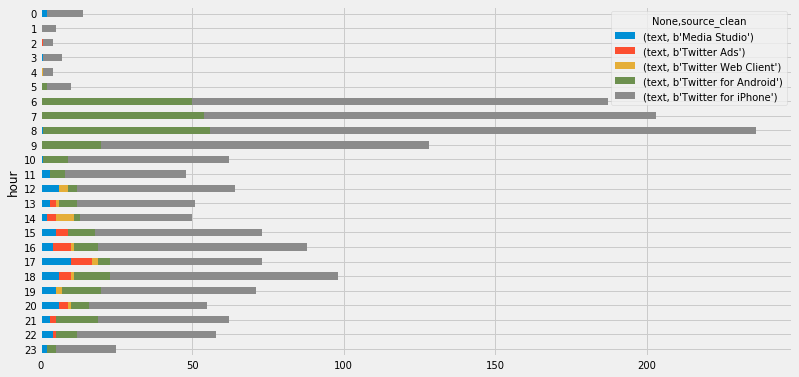

In [9]:
tweetsPerHour = tweets[['source_clean', 'hour', 'text']].pivot_table(
    index='hour', columns=['source_clean'], aggfunc='count')
tweetsPerHour.to_csv('output/tweets-per-hour-of-day.csv')
tweetsPerHour.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per day

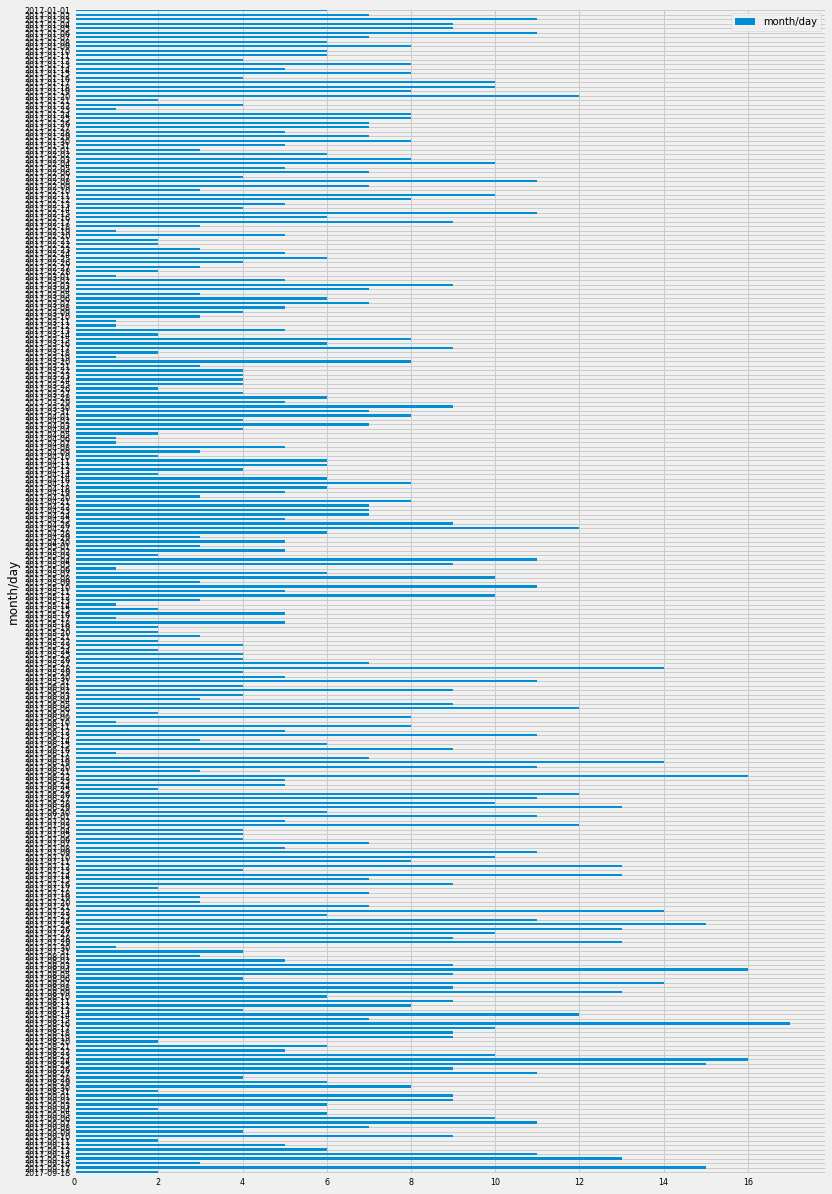

In [10]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
tweetsPerDay.iloc[::-1].plot(kind='barh', figsize=(12,20), fontsize=8)

In [11]:
tweetsPerDay.describe()

,month/day
count,259.000000
mean,6.471042
std,3.629409
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,17.000000


## Tweets per day of week

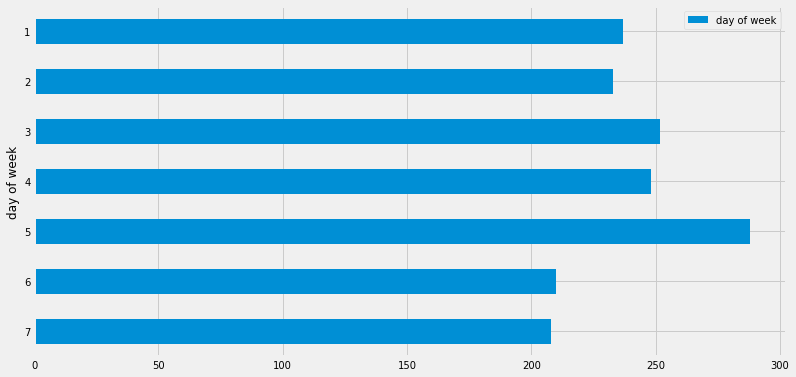

In [12]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')

## Tweets per month

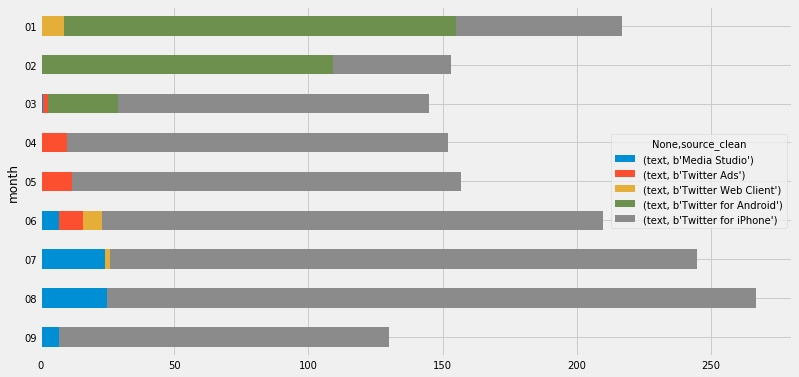

In [13]:
tweetsPerMonth = tweets[['source_clean', 'month', 'text']].pivot_table(index='month', columns=['source_clean'], aggfunc='count')
tweetsPerMonth.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per week

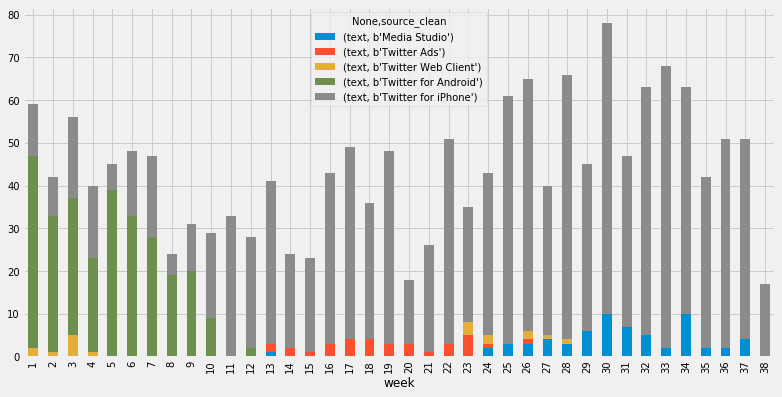

In [14]:
tweetsPerWeek = tweets[['source_clean', 'week', 'text']].pivot_table(index='week', columns=['source_clean'], aggfunc='count')
tweetsPerWeek.to_csv('output/tweetsperweek-by-device.csv', na_rep=0)
tweetsPerWeek.plot(kind='bar', stacked=True)

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
sentiment_fields = ['sentiment.compound'] #, 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

In [17]:
pd.set_option('display.width', 1000)
tweets.sort(columns='sentiment.compound')[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2017-04-18 10:38:59,-0.9735,Democrat Jon Ossoff would be a disaster in Con...
2017-06-13 10:35:55,-0.9544,The Fake News Media has never been so wrong or...
2017-02-07 12:04:01,-0.9370,"I don't know Putin, have no deals in Russia, a..."
2017-02-07 12:11:29,-0.9370,"I don't know Putin, have no deals in Russia, a..."
2017-01-15 22:46:33,-0.9354,.@NBCNews is bad but Saturday Night Live is th...


In [18]:
tweets.sort(columns='sentiment.compound', ascending=False)[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2017-09-07 12:33:12,0.9805,Hurricane Irma is raging but we have great tea...
2017-01-01 06:49:49,0.9765,RT @IvankaTrump: 2016 has been one of the most...
2017-08-25 00:21:42,0.9757,A GREAT HONOR to spend time with our BRAVE HER...
2017-07-27 22:49:05,0.9735,It was my great HONOR to present our nation's ...
2017-09-15 23:54:00,0.9733,HAPPY 70th BIRTHDAY to the @USAirForce! The Am...


In [19]:
tweets.sort(columns=['week', 'sentiment.compound'], ascending=False)[['week', 'sentiment.compound', 'text']].head(40)

,week,sentiment.compound,text
created_date,,,
2017-09-17 11:40:16,38,0.8860,Attorney General Bill Schuette will be a fanta...
2017-09-17 12:28:08,38,0.8221,My great honor! https://t.co/x25T9tQAnI
2017-09-17 12:05:59,38,0.8016,RT @glamourizes: @realDonaldTrump Only true Am...
2017-09-18 13:16:17,38,0.6114,Happy 70th Birthday @CIA! https://t.co/CU3gOZMf7J
2017-09-18 13:14:46,38,0.6114,Happy 70th Birthday @USAirForce! https://t.co/...
2017-09-17 12:16:31,38,0.5859,RT @Fuctupmind: @realDonaldTrump Donald Trump'...
2017-09-17 11:57:20,38,0.4199,Thank you! https://t.co/vs4MNwXtei
2017-09-17 12:29:57,38,0.2263,RT @markets: What Is Trump worth to Twitter? O...
2017-09-17 13:00:05,38,0.0516,Important meetings and calls scheduled for tod...


## By month

### Average

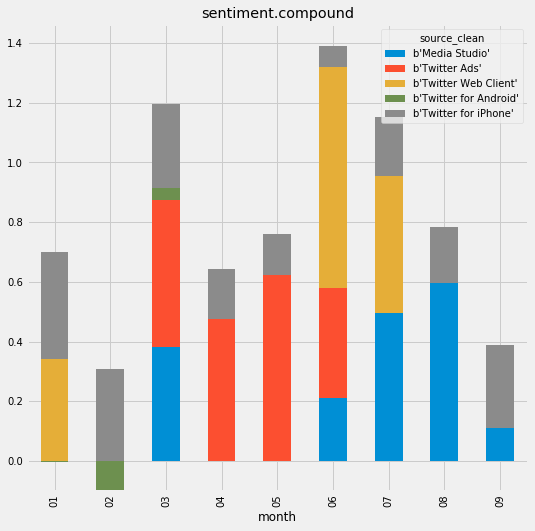

In [20]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

### Cumulative

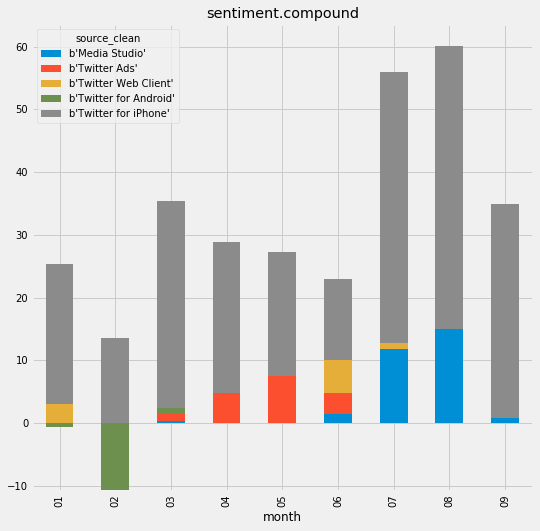

In [21]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

## By week

### Average

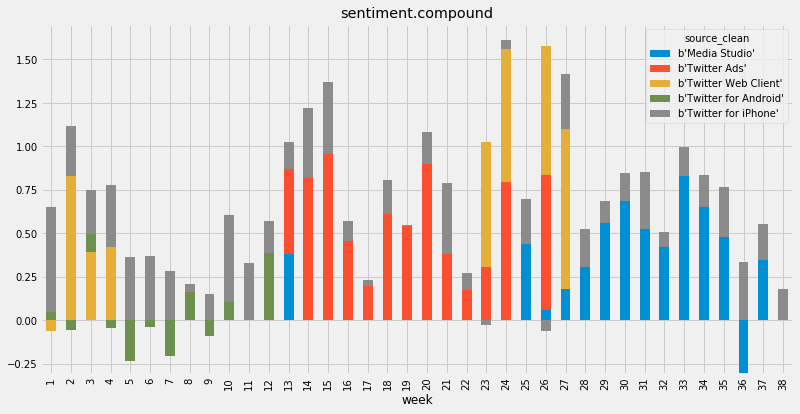

In [22]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.to_csv('output/sentiment-by-week-by-device.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Cumulative

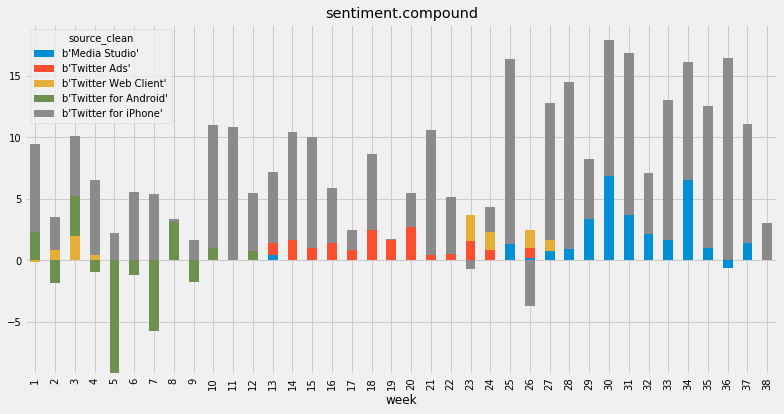

In [23]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Average, not broken down by device

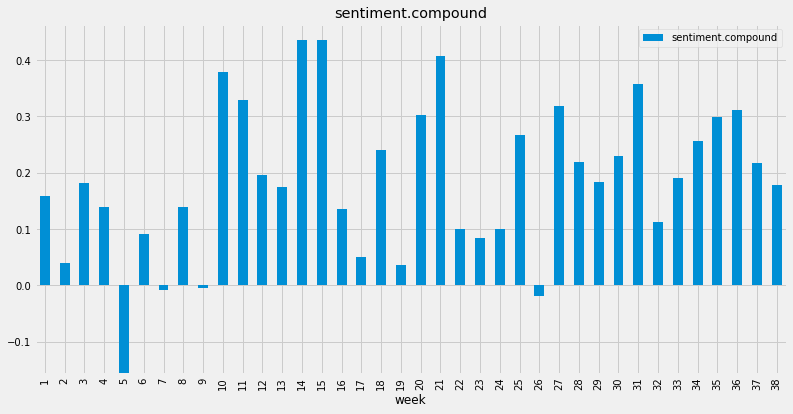

In [24]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['week', field]].groupby('week').mean()
    sentimentByMonth.to_csv('output/sentiment-by-week.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

## Every Tweet's sentiment analysis

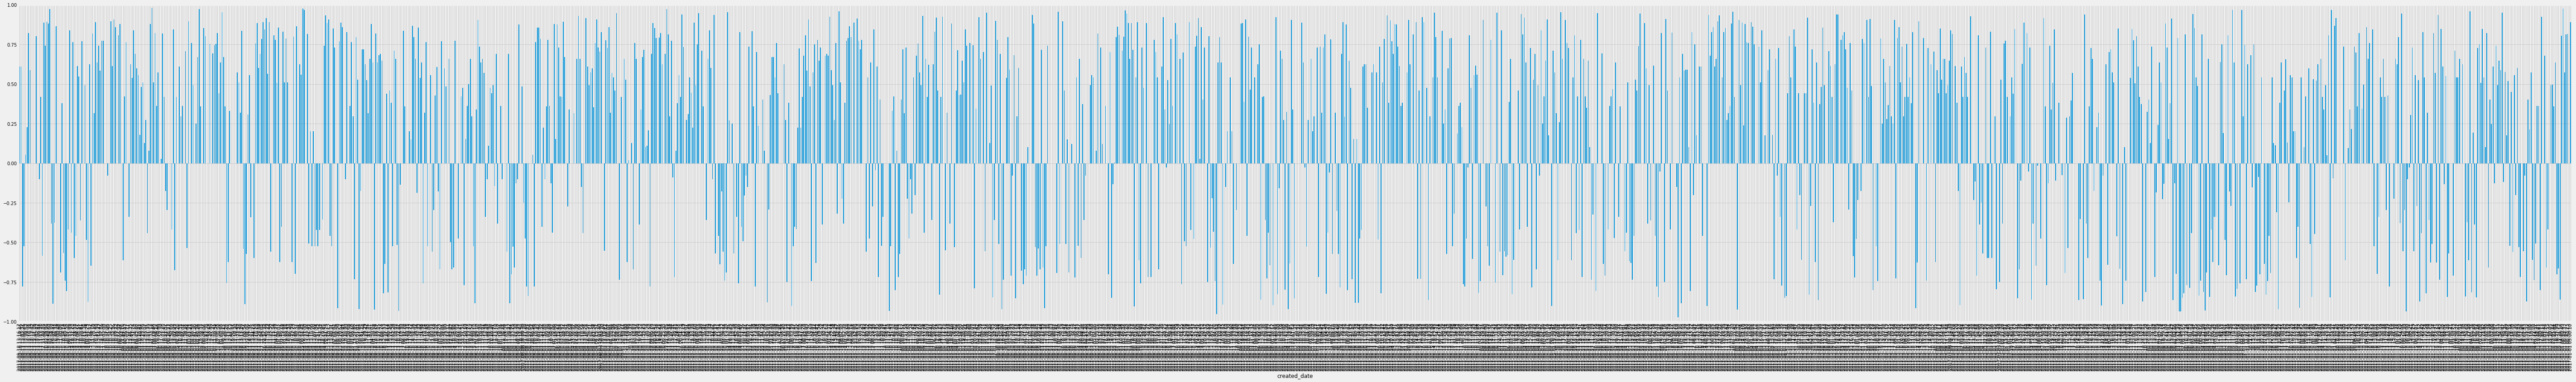

In [25]:
tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1], figsize=(90,12))

# Follower count

The strange drops in follower count are interesting here. The follower ceiling is strangely lacking in noise.

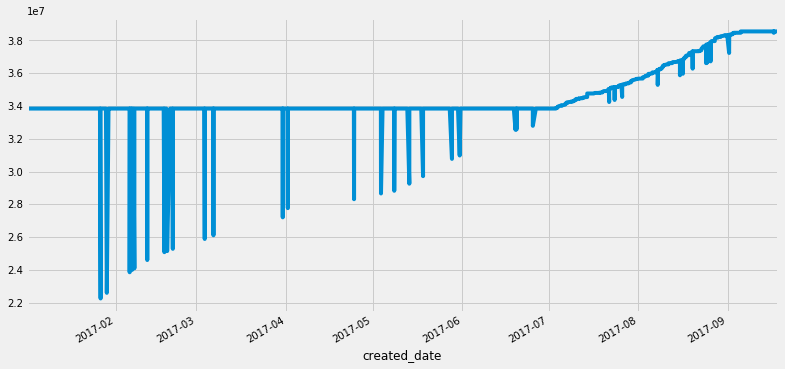

In [26]:
tweets['user.followers_count'].plot()

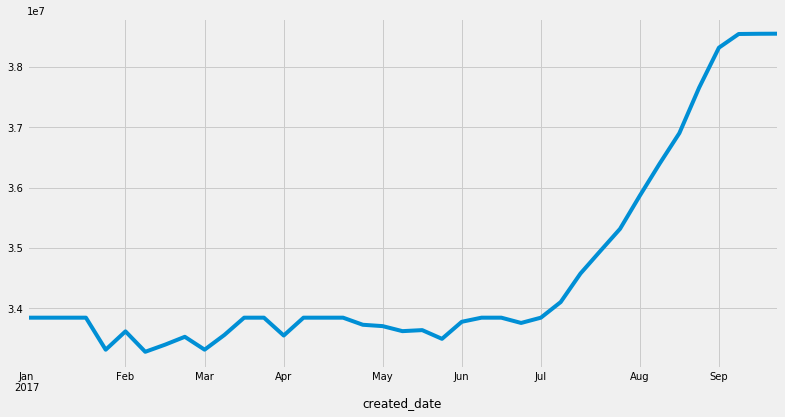

In [27]:
tweets['user.followers_count'].resample('W').plot()

# Per tweet sentiment

In [28]:
sortedSentimentPerTweet = tweets[['week', 'sentiment.compound', 'text', 'id']].sort(['week', 'sentiment.compound'], ascending=False)
# sortedSentimentPerTweet.to_csv('output/sentiment-per-tweet.csv')
sortedSentimentPerTweet

,week,sentiment.compound,text,id
created_date,,,,
2017-09-17 11:40:16,38,0.8860,Attorney General Bill Schuette will be a fanta...,909381488445190145
2017-09-17 12:28:08,38,0.8221,My great honor! https://t.co/x25T9tQAnI,909393531143380992
2017-09-17 12:05:59,38,0.8016,RT @glamourizes: @realDonaldTrump Only true Am...,909387958368784389
2017-09-18 13:16:17,38,0.6114,Happy 70th Birthday @CIA! https://t.co/CU3gOZMf7J,909768037787717633
2017-09-18 13:14:46,38,0.6114,Happy 70th Birthday @USAirForce! https://t.co/...,909767654432526336
2017-09-17 12:16:31,38,0.5859,RT @Fuctupmind: @realDonaldTrump Donald Trump'...,909390607650521088
2017-09-17 11:57:20,38,0.4199,Thank you! https://t.co/vs4MNwXtei,909385782275788800
2017-09-17 12:29:57,38,0.2263,RT @markets: What Is Trump worth to Twitter? O...,909393991635996672
2017-09-17 13:00:05,38,0.0516,Important meetings and calls scheduled for tod...,909401572341370881


In [29]:
df_sortedSentimentPerTweet = sortedSentimentPerTweet.reset_index()
df_sortedSentimentPerTweet['text-encoded'] = df_sortedSentimentPerTweet['text'].apply(encodeText)
df_sortedSentimentPerTweet = df_sortedSentimentPerTweet.drop('text', axis=1)
df_sortedSentimentPerTweet.to_csv('output/df_sortedSentimentPerTweet.csv')

# Text analysis

Common words.

In [30]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/ghing/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (tweets.text
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data = words_data.reset_index()
words_data['Word Encoded'] = words_data['Word'].apply(encodeText)
words_data.drop('Word', axis=1).to_csv('output/word-frequencies.csv')
words_data.head(top_N)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

,Word,Frequency,Word Encoded
0,&amp;,322,b'&amp;'
1,great,263,b'great'
2,',162,"b""'"""
3,!,130,b'!'
4,-,130,b'-'
5,fake,109,b'fake'
6,.,108,b'.'
7,thank,101,b'thank'
8,u..,97,b'u..'
9,news,95,b'news'


# Specific text searches

In [32]:
from IPython.display import display, Markdown

tweetsEnc = tweets.reset_index()

def analyzeText(search):
    display(Markdown('## Search: _{0}_'.format(search)))
    filtered = tweetsEnc[tweetsEnc['text'].str.contains(search, case=False)]
    count = len(filtered)
    percent = float(len(filtered))/len(tweetsEnc) * 100
    display(Markdown('Number of Tweets: {0}'.format(count)))
    display(Markdown('Percent of all Tweets: {0:.2f}%'.format(percent)))
    analyzedByWeek = filtered[['source_clean', 'week', 'text']].pivot_table(index='week', columns='source_clean', aggfunc='count')
    analyzedByWeek = analyzedByWeek.reindex(range(tweetsEnc['week'].min(), tweetsEnc['week'].max())).fillna(0)
    analyzedByWeek.to_csv('output/word-by-week-{0}.csv'.format(search))
    analyzedByWeekPlot = analyzedByWeek.plot(kind='bar', stacked=True, title='{0} by week'.format(search)) 
    plt.show()
    analyzedByHour = filtered[['source_clean', 'hour', 'text']].pivot_table(index='hour', columns='source_clean', aggfunc='count')
    analyzedByHour = analyzedByHour.reindex(range(0, 24)).fillna(0)
    analyzedByHour.to_csv('output/word-by-hour-{0}.csv'.format(search))
    analyzedByHourPlot = analyzedByHour.plot(kind='bar', stacked=True, title='{0} by hour of day'.format(search))
    plt.show()
    display(Markdown('### The Tweets'))
    for i, row in filtered.iterrows():
        display(Markdown('[{0}](https://twitter.com/realDonaldTrump/status/{2}): {1}'.format(row['human_date'], row['text'], row['id'])))
    display(Markdown('---'))

In [33]:
tweetsEnc

,created_date,contributors,coordinates,created_at,display_text_range,extended_entities.media,favorite_count,favorited,full_text,geo,...,user.verified,human_date,month/day,month,day,day of week,hour,week,text encoded,source_clean
0,2017-09-18 13:16:17,None,None,Mon Sep 18 13:16:17 +0000 2017,"[0, 25]",[{'additional_media_info': {'monetizable': Fal...,10992,False,Happy 70th Birthday @CIA! https://t.co/CU3gOZMf7J,None,...,True,"Monday, Sep 18, 2017 9:16 AM",2017-09-18,09,18,1,9,38,b'Happy 70th Birthday @CIA! https://t.co/CU3gO...,b'Twitter for iPhone'
1,2017-09-18 13:14:46,None,None,Mon Sep 18 13:14:46 +0000 2017,"[0, 32]",[{'additional_media_info': {'monetizable': Fal...,12228,False,Happy 70th Birthday @USAirForce! https://t.co/...,None,...,True,"Monday, Sep 18, 2017 9:14 AM",2017-09-18,09,18,1,9,38,b'Happy 70th Birthday @USAirForce! https://t.c...,b'Twitter for iPhone'
2,2017-09-17 13:03:32,None,None,Sun Sep 17 13:03:32 +0000 2017,"[0, 140]",NaN,0,False,RT @realDonaldTrump: Loser terrorists must be ...,None,...,True,"Sunday, Sep 17, 2017 9:03 AM",2017-09-17,09,17,7,9,38,b'RT @realDonaldTrump: Loser terrorists must b...,b'Twitter for iPhone'
3,2017-09-17 13:02:26,None,None,Sun Sep 17 13:02:26 +0000 2017,"[0, 139]",NaN,0,False,RT @realDonaldTrump: The travel ban into the U...,None,...,True,"Sunday, Sep 17, 2017 9:02 AM",2017-09-17,09,17,7,9,38,b'RT @realDonaldTrump: The travel ban into the...,b'Twitter for iPhone'
4,2017-09-17 13:00:05,None,None,Sun Sep 17 13:00:05 +0000 2017,"[0, 134]",NaN,59758,False,Important meetings and calls scheduled for tod...,None,...,True,"Sunday, Sep 17, 2017 9:00 AM",2017-09-17,09,17,7,9,38,b'Important meetings and calls scheduled for t...,b'Twitter for iPhone'
5,2017-09-17 12:29:57,None,None,Sun Sep 17 12:29:57 +0000 2017,"[0, 125]","[{'source_user_id': 69620713, 'source_status_i...",0,False,RT @markets: What Is Trump worth to Twitter? O...,None,...,True,"Sunday, Sep 17, 2017 8:29 AM",2017-09-17,09,17,7,8,38,b'RT @markets: What Is Trump worth to Twitter?...,b'Twitter for iPhone'
6,2017-09-17 12:28:08,None,None,Sun Sep 17 12:28:08 +0000 2017,"[0, 15]",NaN,61196,False,My great honor! https://t.co/x25T9tQAnI,None,...,True,"Sunday, Sep 17, 2017 8:28 AM",2017-09-17,09,17,7,8,38,b'My great honor! https://t.co/x25T9tQAnI',b'Twitter for iPhone'
7,2017-09-17 12:16:31,None,None,Sun Sep 17 12:16:31 +0000 2017,"[0, 106]","[{'source_user_id': 139499789, 'source_status_...",0,False,RT @Fuctupmind: @realDonaldTrump Donald Trump'...,None,...,True,"Sunday, Sep 17, 2017 8:16 AM",2017-09-17,09,17,7,8,38,"b""RT @Fuctupmind: @realDonaldTrump Donald Trum...",b'Twitter for iPhone'
8,2017-09-17 12:12:19,None,None,Sun Sep 17 12:12:19 +0000 2017,"[0, 59]","[{'source_user_id': 3580248555, 'source_status...",0,False,RT @Team_Trump45: @realDonaldTrump https://t....,None,...,True,"Sunday, Sep 17, 2017 8:12 AM",2017-09-17,09,17,7,8,38,b'RT @Team_Trump45: @realDonaldTrump https://...,b'Twitter for iPhone'
9,2017-09-17 12:12:02,None,None,Sun Sep 17 12:12:02 +0000 2017,"[0, 59]","[{'source_user_id': 3580248555, 'source_status...",0,False,RT @Team_Trump45: @realDonaldTrump https://t....,None,...,True,"Sunday, Sep 17, 2017 8:12 AM",2017-09-17,09,17,7,8,38,b'RT @Team_Trump45: @realDonaldTrump https://...,b'Twitter for iPhone'


## Search: _great_

Number of Tweets: 284

Percent of all Tweets: 16.95%

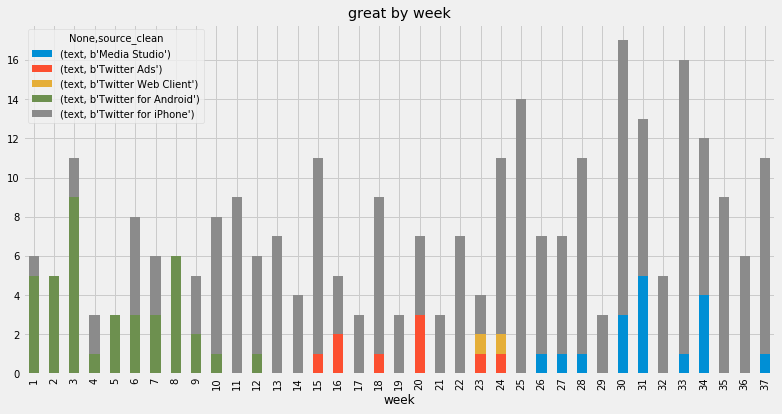

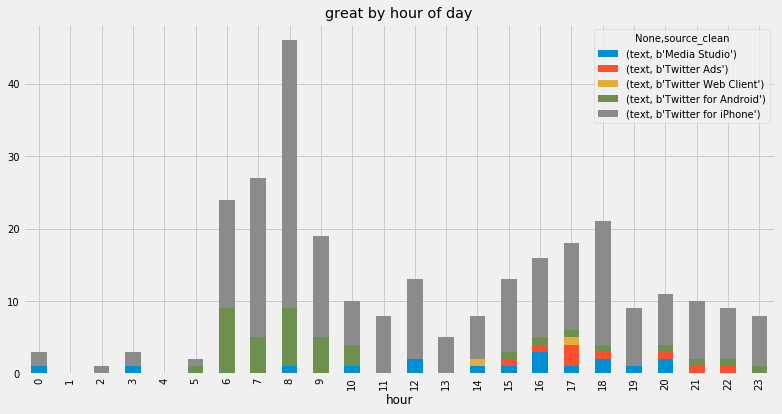

### The Tweets

[Sunday, Sep 17, 2017 8:28 AM](https://twitter.com/realDonaldTrump/status/909393531143380992): My great honor! https://t.co/x25T9tQAnI

[Sunday, Sep 17, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/909387958368784389): RT @glamourizes: @realDonaldTrump Only true Americans can see that president Trump is making America great. He's the only person who can! H…

[Sunday, Sep 17, 2017 7:40 AM](https://twitter.com/realDonaldTrump/status/909381488445190145): Attorney General Bill Schuette will be a fantastic Governor for the great State of Michigan. I am bringing back your jobs and Bill will help

[Saturday, Sep 16, 2017 7:04 PM](https://twitter.com/realDonaldTrump/status/909191177810915328): I will be in Huntsville, Alabama, on Saturday night to support Luther Strange for Senate. "Big Luther" is a great guy who gets things done!

[Saturday, Sep 16, 2017 6:59 PM](https://twitter.com/realDonaldTrump/status/909189931154771970): Attorney General Bill Shuette will be a fantastic Governor for the great State of Michigan. I am bringing back your jobs and Bill will help!

[Saturday, Sep 16, 2017 6:40 PM](https://twitter.com/realDonaldTrump/status/909185223887347712): A great deal of good things happening for our country. Jobs and Stock Market at all time highs, and I believe will be getting even better!

[Friday, Sep 15, 2017 12:49 PM](https://twitter.com/realDonaldTrump/status/908734537311678464): Frank “FX” Giaccio-
On behalf of @FLOTUS Melania &amp; myself, THANK YOU for doing a GREAT job this morning! @NatlParkService gives you an A+! https://t.co/135DxuapUI

[Thursday, Sep 14, 2017 3:04 PM](https://twitter.com/realDonaldTrump/status/908406085308096512): Just left Florida for D.C. The people and spirit in THAT GREAT STATE is unbelievable. Damage horrific but will be better than ever!

[Thursday, Sep 14, 2017 7:05 AM](https://twitter.com/realDonaldTrump/status/908285679335034880): Am leaving now for Florida to see our GREAT first responders and to thank the U.S. Coast Guard, FEMA etc. A real disaster, much work to do!

[Wednesday, Sep 13, 2017 7:34 AM](https://twitter.com/realDonaldTrump/status/907930425657626624): I will be traveling to Florida tomorrow to meet with our great Coast Guard, FEMA and many of the brave first responders &amp; others.

[Tuesday, Sep 12, 2017 4:12 PM](https://twitter.com/realDonaldTrump/status/907698529606541312): It was a great honor to welcome Prime Minister Najib Abdul Razak of Malaysia and his distinguished delegation to the @WhiteHouse today! https://t.co/3pWrBOh8dG

[Tuesday, Sep 12, 2017 9:11 AM](https://twitter.com/realDonaldTrump/status/907592460070768641): The devastation left by Hurricane Irma was far greater, at least in certain locations,than anyone thought - but amazing people working hard!

[Tuesday, Sep 12, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/907579024960098304): RT @LouDobbs: Making America Great Again- @Kellyannepolls: After #Irma @POTUS is focused on saving lives, not swamp shenanigans. #Dobbs #MA…

[Sunday, Sep 10, 2017 6:28 AM](https://twitter.com/realDonaldTrump/status/906826663484411905): RT @DonaldJTrumpJr: Great pic from a friend on @CBPflorida @CustomsBorder who have been helping with #harvey recovery and now with #irma. T…

[Friday, Sep 8, 2017 8:46 AM](https://twitter.com/realDonaldTrump/status/906136682952568832): ...never allow the Republicans to pass even great legislation. 8 Dems control - will rarely get 60 (vs. 51) votes. It is a Repub Death Wish!

[Thursday, Sep 7, 2017 8:51 AM](https://twitter.com/realDonaldTrump/status/905775458557538304): Thank you, our great honor! https://t.co/StrciEwuWs

[Thursday, Sep 7, 2017 8:33 AM](https://twitter.com/realDonaldTrump/status/905770927526432768): Hurricane Irma is raging but we have great teams of talented and brave people already in place and ready to help. Be careful, be safe! #FEMA

[Sunday, Sep 3, 2017 7:39 AM](https://twitter.com/realDonaldTrump/status/904307898213433344): ..North Korea is a rogue nation which has become a great threat and embarrassment to China, which is trying to help but with little success.

[Saturday, Sep 2, 2017 10:57 PM](https://twitter.com/realDonaldTrump/status/904176553621307396): Just got back to the White House from the Great States of Texas and Louisiana, where things are going well. Such cooperation &amp; coordination!

[Saturday, Sep 2, 2017 9:55 PM](https://twitter.com/realDonaldTrump/status/904160894661296130): Together, we will prevail in the GREAT state of Texas. We love you!

GOD BLESS TEXAS &amp; GOD BLESS THE USA🇺🇸 https://t.co/1rzmEenQIb

[Friday, Sep 1, 2017 8:34 PM](https://twitter.com/realDonaldTrump/status/903778130850131970): On behalf of @FLOTUS Melania &amp; myself, THANK YOU for today's update &amp; GREAT WORK! #SouthernBaptist @SendRelief, @RedCross &amp; @SalvationArmyUS https://t.co/DLgFNiCxN2

[Friday, Sep 1, 2017 8:03 PM](https://twitter.com/realDonaldTrump/status/903770196388831233): I will be going to Texas and Louisiana tomorrow with First Lady. Great progress being made! Spending weekend working at White House.

[Friday, Sep 1, 2017 8:58 AM](https://twitter.com/realDonaldTrump/status/903603043714957312): Texas is healing fast thanks to all of the great men &amp; women who have been working so hard. But still so much to do. Will be back tomorrow!

[Friday, Sep 1, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/903597166249246720): General John Kelly is doing a great job as Chief of Staff. I could not be happier or more impressed - and this Administration continues to..

[Friday, Sep 1, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/903585873614303234): Texas is heeling fast thanks to all of the great men &amp; women who have been working so hard. But still, so much to do. Will be back tomorrow!

[Wednesday, Aug 30, 2017 9:12 AM](https://twitter.com/realDonaldTrump/status/902881712010653697): After witnessing first hand the horror &amp; devastation caused by Hurricane Harvey,my heart goes out even more so to the great people of Texas!

[Sunday, Aug 27, 2017 8:25 AM](https://twitter.com/realDonaldTrump/status/901782823522185218): Many people are now saying that this is the worst storm/hurricane they have ever seen. Good news is that we have great talent on the ground.

[Sunday, Aug 27, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/901777333513854976): Great coordination between agencies at all levels of government. Continuing rains and flash floods are being dealt with. Thousands rescued.

[Sunday, Aug 27, 2017 7:45 AM](https://twitter.com/realDonaldTrump/status/901772550405070848): A great book by a great guy, highly recommended! https://t.co/3jbDDN8YmJ

[Saturday, Aug 26, 2017 6:57 PM](https://twitter.com/realDonaldTrump/status/901579350662938624): Wonderful coordination between Federal, State and Local Governments in the Great State of Texas - TEAMWORK! Record setting rainfall.

[Saturday, Aug 26, 2017 3:46 PM](https://twitter.com/realDonaldTrump/status/901531320052051971): THANK YOU to all of the great volunteers helping out with #HurricaneHarvey relief in Texas! https://t.co/Ds95oSgo8f

[Saturday, Aug 26, 2017 7:52 AM](https://twitter.com/realDonaldTrump/status/901411986302488576): Closely monitoring #HurricaneHarvey from Camp David. We are leaving nothing to chance. City, State and Federal Govs. working great together!

[Saturday, Aug 26, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/901404330024218624): You are doing a great job - the world is watching! Be safe. https://t.co/PJLdxy3hD9

[Thursday, Aug 24, 2017 8:21 PM](https://twitter.com/realDonaldTrump/status/900875799292776448): A GREAT HONOR to spend time with our BRAVE HEROES at the @USMC Air Station Yuma. THANK YOU for your service to the United States of America! https://t.co/4lJ94nxODu

[Thursday, Aug 24, 2017 6:39 PM](https://twitter.com/realDonaldTrump/status/900850201384157184): A great honor to spend time with our brave HEROES at the @USMC Air Station Yuma. THANK YOU for your service to the United Staes of America! https://t.co/FUtGBoTJLo

[Wednesday, Aug 23, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/900488148194516992): A great honor to sign the Veterans Appeals Improvement &amp; Modernization Act into law w/ @AmericanLegion @SecShulkin.
🎥https://t.co/fr2sf9oRvd https://t.co/bICsRm1tQx

[Wednesday, Aug 23, 2017 3:10 PM](https://twitter.com/realDonaldTrump/status/900435023517499392): As long as we have faith in each other and confidence in our values, then there is no challenge too great for us to conquer! #ALConv2017 https://t.co/tsIAgHbFM7

[Wednesday, Aug 23, 2017 9:20 AM](https://twitter.com/realDonaldTrump/status/900346953120141312): Phoenix crowd last night was amazing - a packed house. I love the Great State of Arizona. Not a fan of Jeff Flake, weak on crime &amp; border!

[Wednesday, Aug 23, 2017 3:01 AM](https://twitter.com/realDonaldTrump/status/900251514324647936): MAKE AMERICA GREAT AGAIN! https://t.co/RzePiucV3h

[Tuesday, Aug 22, 2017 8:20 PM](https://twitter.com/realDonaldTrump/status/900150814081036288): THANK YOU to all of the great men and women at the U.S. Customs and Border Protection facility in Yuma, Arizona &amp; around the United States! https://t.co/tjFx8XjhDz

[Tuesday, Aug 22, 2017 6:46 AM](https://twitter.com/realDonaldTrump/status/899945866991206400): Was with great people last night in Fort Myer, Virginia. The future of our country is strong!

[Saturday, Aug 19, 2017 4:41 PM](https://twitter.com/realDonaldTrump/status/899008381226299392): Our great country has been divided for decades. Sometimes you need protest in order to heal, &amp; we will heal, &amp; be stronger than ever before!

[Saturday, Aug 19, 2017 4:34 PM](https://twitter.com/realDonaldTrump/status/899006740410269696): Our great country has been divided for decades. Sometimes you need protest in order to heel, &amp; we will heel, &amp; be stronger than ever before!

[Saturday, Aug 19, 2017 3:29 PM](https://twitter.com/realDonaldTrump/status/898990321387925504): Great job by all law enforcement officers and Boston Mayor @Marty_Walsh.

[Saturday, Aug 19, 2017 7:33 AM](https://twitter.com/realDonaldTrump/status/898870621584596993): I want to thank Steve Bannon for his service. He came to the campaign during my run against Crooked Hillary Clinton - it was great! Thanks S

[Friday, Aug 18, 2017 7:17 PM](https://twitter.com/realDonaldTrump/status/898685249726578688): Just returned to Bedminster, NJ from Camp David. GREAT meeting on National Security, the Border and the Military! #MAGA🇺🇸 https://t.co/Hjmcnnse9j

[Thursday, Aug 17, 2017 9:21 AM](https://twitter.com/realDonaldTrump/status/898172999945392131): ...the beauty that is being taken out of our cities, towns and parks will be greatly missed and never able to be comparably replaced!

[Thursday, Aug 17, 2017 9:07 AM](https://twitter.com/realDonaldTrump/status/898169407213645824): Sad to see the history and culture of our great country being ripped apart with the removal of our beautiful statues and monuments. You.....

[Thursday, Aug 17, 2017 8:59 AM](https://twitter.com/realDonaldTrump/status/898167282727366656): Many meetings today in Bedminster including with Secretary Linda M and Small Business. Job numbers are looking great!

[Thursday, Aug 17, 2017 6:56 AM](https://twitter.com/realDonaldTrump/status/898136462385979392): Great to see that Dr. Kelli Ward is running against Flake Jeff Flake, who is WEAK on borders, crime and a non-factor in Senate. He's toxic!

[Wednesday, Aug 16, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/897799882802704385): MAKE AMERICA GREAT AGAIN!

[Wednesday, Aug 16, 2017 7:32 AM](https://twitter.com/realDonaldTrump/status/897783159038910466): RT @FoxNews: .@POTUS: "Our infrastructure will again be the best in the world. We used to have the greatest infrastructure anywhere in the…

[Wednesday, Aug 16, 2017 6:12 AM](https://twitter.com/realDonaldTrump/status/897763049226084352): Amazon is doing great damage to tax paying retailers. Towns, cities and states throughout the U.S. are being hurt - many jobs being lost!

[Tuesday, Aug 15, 2017 8:08 AM](https://twitter.com/realDonaldTrump/status/897429670278385664): Big day in Alabama. Vote for Luther Strange, he will be great!

[Tuesday, Aug 15, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/897405235924275200): Senator Luther Strange, who is doing a great job for the people of Alabama, will be on @foxandfriends at 7:15. Tough on crime, borders etc.

[Monday, Aug 14, 2017 6:17 PM](https://twitter.com/realDonaldTrump/status/897220584211439616): Big day in Washington, D.C., even though White House &amp; Oval Office are being renovated. Great trade deals coming for American workers!

[Monday, Aug 14, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/897044700124909569): Luther Strange of the Great State of Alabama has my endorsement. He is strong on Border &amp; Wall, the military, tax cuts &amp; law enforcement.

[Thursday, Aug 10, 2017 12:40 PM](https://twitter.com/realDonaldTrump/status/895686351529672704): Mitch, get back to work and put Repeal &amp; Replace, Tax Reform &amp; Cuts and a great Infrastructure Bill on my desk for signing. You can do it!

[Tuesday, Aug 8, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/895091395379245056): Senator Luther Strange has done a great job representing the people of the Great State of Alabama. He has my complete and total endorsement!

[Monday, Aug 7, 2017 2:18 PM](https://twitter.com/realDonaldTrump/status/894623814079975425): RT @realDonaldTrump: On #PurpleHeartDay💜I thank all the brave men and women who have sacrificed in battle for this GREAT NATION! #USA🇺🇸 htt…

[Monday, Aug 7, 2017 2:03 PM](https://twitter.com/realDonaldTrump/status/894620077634592769): On #PurpleHeartDay💜I thank all the brave men and women who have sacrificed in battle for this GREAT NATION! #USA🇺🇸 https://t.co/QmfdLSLp6p

[Sunday, Aug 6, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/894185208924262401): MAKE AMERICA GREAT AGAIN! https://t.co/g4ELhh9joH

[Saturday, Aug 5, 2017 6:58 PM](https://twitter.com/realDonaldTrump/status/893969438139191296): After many years of LEAKS going on in Washington, it is great to see the A.G. taking action! For National Security, the tougher the better!

[Friday, Aug 4, 2017 5:38 PM](https://twitter.com/realDonaldTrump/status/893587008312016896): Great work being done by @FEMA @DHSgov w/state &amp; local leaders to prepare for hurricane season. Preparedness is an investment in our future! https://t.co/e4rbchY3zM

[Friday, Aug 4, 2017 9:21 AM](https://twitter.com/realDonaldTrump/status/893461771813564416): RT @paultdove: @FoxBusiness Republican Senators who are opposing the President, look at the great economic news: Americans Are Noticing!

[Friday, Aug 4, 2017 6:02 AM](https://twitter.com/realDonaldTrump/status/893411790868160514): Toyota &amp; Mazda to build a new $1.6B plant here in the U.S.A. and create 4K new American jobs. A great investment in American manufacturing!

[Friday, Aug 4, 2017 12:19 AM](https://twitter.com/realDonaldTrump/status/893325503020642305): Thank you West Virginia! All across the country, Americans of every kind are coming together w/one simple goal: to MAKE AMERICA GREAT AGAIN! https://t.co/thRh7htVbH

[Thursday, Aug 3, 2017 6:52 PM](https://twitter.com/realDonaldTrump/status/893243147580473344): Just arrived in West Virginia for a MAKE AMERICA GREAT AGAIN rally in Huntington at 7:00pmE. Massive crowd expected - tune in! #MAGA🇺🇸

[Thursday, Aug 3, 2017 3:07 PM](https://twitter.com/realDonaldTrump/status/893186623193718784): Our GREAT VETERANS can now connect w/ their VA healthcare team from anywhere, using #VAVideoConnect - available at: https://t.co/WFFHLWn8nF. https://t.co/Dmq4htSps9

[Thursday, Aug 3, 2017 2:03 PM](https://twitter.com/realDonaldTrump/status/893170489820151808): Today, I  announced another historic breakthrough for the VA. We are working tirelessly to keep our promises to our GREAT VETERANS! #USA https://t.co/LexSINeM1J

[Thursday, Aug 3, 2017 12:04 PM](https://twitter.com/realDonaldTrump/status/893140445294940160): See you tonight Huntington, West Virginia!
#MakeAmericaGreatAgain🇺🇸
Tickets: https://t.co/ERU0xUWdCr https://t.co/obtDsdV94t

[Thursday, Aug 3, 2017 8:12 AM](https://twitter.com/realDonaldTrump/status/893082107081244672): I am continuing to get rid of costly and unnecessary regulations. Much work left to do but effect will be great! Business &amp; jobs will grow.

[Thursday, Aug 3, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/893080287755849729): RT @JacobAWohl: @realDonaldTrump The #MAGA great again movement is WINNING, and the left-wing media can't stand it!

[Wednesday, Aug 2, 2017 10:09 AM](https://twitter.com/realDonaldTrump/status/892749228291874816): It was my great honor to pay tribute to a VET who went above &amp; beyond the call of duty to PROTECT our COMRADES, our COUNTRY, &amp; OUR FREEDOM! https://t.co/YS6y1WR30G

[Monday, Jul 31, 2017 6:19 PM](https://twitter.com/realDonaldTrump/status/892147656319004672): A great day at the White House!

[Saturday, Jul 29, 2017 12:19 PM](https://twitter.com/realDonaldTrump/status/891332290474848257): After seven years of "talking" Repeal &amp; Replace, the people of our great country are still being forced to live with imploding ObamaCare!

[Saturday, Jul 29, 2017 7:39 AM](https://twitter.com/realDonaldTrump/status/891261878005092353): ....8 Dems totally control the U.S. Senate. Many great Republican bills will never pass, like Kate's Law and complete Healthcare. Get smart!

[Friday, Jul 28, 2017 4:54 PM](https://twitter.com/realDonaldTrump/status/891039237319143424): ...and a Great Leader. John has also done a spectacular job at Homeland Security. He has been a true star of my Administration

[Friday, Jul 28, 2017 4:49 PM](https://twitter.com/realDonaldTrump/status/891038014314598400): I am pleased to inform you that I have just named General/Secretary John F Kelly as White House Chief of Staff. He is a Great American....

[Friday, Jul 28, 2017 10:00 AM](https://twitter.com/realDonaldTrump/status/890935044474380288): ...Even though parts of healthcare could pass at 51, some really good things need 60. So many great future bills &amp; budgets need 60 votes....

[Friday, Jul 28, 2017 9:46 AM](https://twitter.com/realDonaldTrump/status/890931465885798400): If Republicans are going to pass great future legislation in the Senate, they must immediately go to a 51 vote majority, not senseless 60...

[Thursday, Jul 27, 2017 10:43 PM](https://twitter.com/realDonaldTrump/status/890764622852173826): Go Republican Senators, Go! Get there after waiting for 7 years. Give America great healthcare!

[Thursday, Jul 27, 2017 6:49 PM](https://twitter.com/realDonaldTrump/status/890705628716466176): It was my great HONOR to present our nation's highest award for a public safety officer - THE MEDAL OF VALOR to FIVE AMERICAN HEROES! https://t.co/j7ceXuBZ3f

[Wednesday, Jul 26, 2017 4:54 PM](https://twitter.com/realDonaldTrump/status/890314337696579584): Congratulations to Boys and Girls Nation. It was my great honor to welcome you to the WH today! Full Remarks: https://t.co/Pb5FTTOyWf https://t.co/U6tfV93dDG

[Wednesday, Jul 26, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/890168183079960576): Senator @lisamurkowski of the Great State of Alaska really let the Republicans, and our country, down yesterday. Too bad!

[Wednesday, Jul 26, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/890162144884514820): The crowd in Ohio was amazing last night - broke all records. We all had a great time in a great State. Will be back soon!

[Wednesday, Jul 26, 2017 12:05 AM](https://twitter.com/realDonaldTrump/status/890060370861334529): It was my great honor to join our wonderful Veterans at AMVETS Post 44 in Youngstown, Ohio this evening. A grateful nation salutes you! https://t.co/RxobYHP1oR

[Tuesday, Jul 25, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/889972487844491265): Just arrived in Youngstown, Ohio with @FLOTUS Melania!
#MakeAmericaGreatAgain🇺🇸
🎥https://t.co/A1mrxSksR3 https://t.co/jWX9yBlX8z

[Tuesday, Jul 25, 2017 8:29 AM](https://twitter.com/realDonaldTrump/status/889824817473605632): Will be traveling to the Great State of Ohio tonight. Big crowd expected. See you there!

[Tuesday, Jul 25, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/889822411356602369): This will be a very interesting day for HealthCare.The Dems are obstructionists but the Republicans can have a great victory for the people!

[Tuesday, Jul 25, 2017 6:44 AM](https://twitter.com/realDonaldTrump/status/889798407228989441): So great that John McCain is coming back to vote. Brave - American hero! Thank you John.

[Sunday, Jul 23, 2017 8:01 PM](https://twitter.com/realDonaldTrump/status/889274373689028609): If Republicans don't Repeal and Replace the disastrous ObamaCare, the repercussions will be far greater than any of them understand!

[Thursday, Jul 20, 2017 1:27 PM](https://twitter.com/realDonaldTrump/status/888088029428150272): Departing The Pentagon after meetings with @VP Pence, Secretary James Mattis, and our great teams. #MAGA🇺🇸 https://t.co/5d1MSzhjQS

[Tuesday, Jul 18, 2017 7:58 AM](https://twitter.com/realDonaldTrump/status/887280380423938048): As I have always said, let ObamaCare fail and then come together and do a great healthcare plan. Stay tuned!

[Saturday, Jul 15, 2017 11:04 PM](https://twitter.com/realDonaldTrump/status/886421324637380609): The women played great today at the @USGA #USWomensOpen🇺🇸 I look forward to being there tomorrow for the final round! https://t.co/2oWyptgfIY

[Saturday, Jul 15, 2017 4:19 PM](https://twitter.com/realDonaldTrump/status/886319322154586112): MAKE AMERICA GREAT AGAIN! https://t.co/3eYF3nir4B

[Saturday, Jul 15, 2017 12:21 PM](https://twitter.com/realDonaldTrump/status/886259363412926464): Stock Market at new all-time high! Working on new trade deals that will be great for U.S. and its workers!

[Friday, Jul 14, 2017 11:02 PM](https://twitter.com/realDonaldTrump/status/886058483392622592): I will be at the @USGA #USWomensOpen in Bedminster, NJ tomorrow. Big crowds expected &amp; the women are playing great-should be very exciting!

[Friday, Jul 14, 2017 9:47 AM](https://twitter.com/realDonaldTrump/status/885858247277727746): Great conversations with President @EmmanuelMacron and his representatives on trade, military and security.

[Friday, Jul 14, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/885817217455140864): It was a great honor to represent the United States at the magnificent #BastilleDay parade. Congratulations President @EmmanuelMacron! https://t.co/1J4vZiy98y

[Friday, Jul 14, 2017 3:56 AM](https://twitter.com/realDonaldTrump/status/885769944482414593): Great evening with President @EmmanuelMacron &amp; Mrs. Macron. Went to Eiffel Tower for dinner. Relationship with France stronger than ever. https://t.co/ib1pdUYoEU

[Thursday, Jul 13, 2017 3:20 PM](https://twitter.com/realDonaldTrump/status/885579818875670528): Great bilateral meetings at Élysée Palace w/ President @EmmanuelMacron. The friendship between our two nations and ourselves is unbreakable. https://t.co/IOSoC0MdPv

[Wednesday, Jul 12, 2017 6:19 AM](https://twitter.com/realDonaldTrump/status/885081181980590084): My son Donald did a good job last night. He was open, transparent and innocent. This is the greatest Witch Hunt in political history. Sad!

[Tuesday, Jul 11, 2017 8:24 PM](https://twitter.com/realDonaldTrump/status/884931352201756672): My son, Donald, will be interviewed by @seanhannity tonight at 10:00 P.M. He is a great person who loves our country!

[Sunday, Jul 9, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/884033889613828096): MAKE AMERICA GREAT AGAIN! https://t.co/NVDVRrWLs4

[Sunday, Jul 9, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/884008221970763776): The G 20 Summit was a great success for the U.S. - Explained that the U.S. must fix the many bad trade deals it has made. Will get done!

[Friday, Jul 7, 2017 7:33 PM](https://twitter.com/realDonaldTrump/status/883469033059864578): Great first day with world leaders at the #G20Summit here in Hamburg, Germany. Looking forward to day two! #USA https://t.co/bLKgZKQemw

[Friday, Jul 7, 2017 3:07 AM](https://twitter.com/realDonaldTrump/status/883220875444715520): After Poland had a great meeting with Chancellor Merkel and then with PM Shinzō Abe of Japan &amp; President Moon of South Korea.

[Friday, Jul 7, 2017 2:59 AM](https://twitter.com/realDonaldTrump/status/883218784663818241): My experience yesterday in Poland was a great one. Thank you to everyone, including the haters, for the great reviews of the speech!

[Monday, Jul 3, 2017 4:54 PM](https://twitter.com/realDonaldTrump/status/881979394373406720): Really great numbers on jobs &amp; the economy! Things are starting to kick in now, and we have just begun! Don't like steel &amp; aluminum dumping!

[Monday, Jul 3, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/881847676232503297): At some point the Fake News will be forced to discuss our great jobs numbers, strong economy, success with ISIS, the border &amp; so much else!

[Sunday, Jul 2, 2017 4:04 PM](https://twitter.com/realDonaldTrump/status/881604490041995271): The dishonest media will NEVER keep us from accomplishing our objectives on behalf of our GREAT AMERICAN PEOPLE!… https://t.co/EwnwCeuGMv

[Sunday, Jul 2, 2017 12:47 AM](https://twitter.com/realDonaldTrump/status/881373634585079808): We will always take care of our GREAT VETERANS. You have shed your blood, poured your love, and bared your soul, in… https://t.co/bTPuerxLOr

[Saturday, Jul 1, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/881281755017355264): My use of social media is not Presidential - it’s MODERN DAY PRESIDENTIAL. Make America Great Again!

[Saturday, Jul 1, 2017 5:38 PM](https://twitter.com/realDonaldTrump/status/881265792700035073): Getting rdy to leave for tonight's Celebrate Freedom Concert honoring our GREAT VETERANS w/ so many of my evangelic… https://t.co/shfTAoMJry

[Saturday, Jul 1, 2017 8:44 AM](https://twitter.com/realDonaldTrump/status/881131368520056832): Happy Canada Day to all of the great people of Canada and to your Prime Minister and my new found friend @JustinTrudeau. #Canada150

[Wednesday, Jun 28, 2017 5:06 PM](https://twitter.com/realDonaldTrump/status/880170602690215936): It was my great honor to welcome the 2016 World Series Champion Chicago @Cubs ⚾️ to the @WhiteHouse this afternoon.… https://t.co/GvPhJ9hZdv

[Wednesday, Jun 28, 2017 4:19 PM](https://twitter.com/realDonaldTrump/status/880158771762286592): #ICYMI- on Monday, I had the great honor of welcoming India's Prime Minister @narendramodi to the WH. Full Remarks:… https://t.co/7IIQEh7xXv

[Tuesday, Jun 27, 2017 6:27 PM](https://twitter.com/realDonaldTrump/status/879828637733793793): I just finished a great meeting with the Republican Senators concerning HealthCare. They really want to get it right, unlike OCare!

[Monday, Jun 26, 2017 10:31 PM](https://twitter.com/realDonaldTrump/status/879527520957325314): Great day for America's future Security and Safety, courtesy of the U.S. Supreme Court. I will keep fighting for the American people, &amp; WIN!

[Saturday, Jun 24, 2017 5:23 PM](https://twitter.com/realDonaldTrump/status/878725385235701761): MAKE AMERICA GREAT AGAIN!

[Thursday, Jun 22, 2017 7:12 PM](https://twitter.com/realDonaldTrump/status/878027873650475008): Together, we are going to MAKE AMERICA GREAT AGAIN!
#AmericaFirst🇺🇸 https://t.co/MVJbs44AtR

[Thursday, Jun 22, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/877846483021602816): Great night in Iowa - special people. Thank you!

[Wednesday, Jun 21, 2017 7:48 PM](https://twitter.com/realDonaldTrump/status/877674738364989440): Thank you Kirkwood Community College. Heading to the U.S. Cellular Center now for an 8pmE MAKE AMERICA GREAT AGAIN… https://t.co/n6LS32a6Zn

[Tuesday, Jun 20, 2017 11:48 PM](https://twitter.com/realDonaldTrump/status/877372660455546880): Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0

[Tuesday, Jun 20, 2017 11:12 PM](https://twitter.com/realDonaldTrump/status/877363446530007040): Ralph Norman ran a fantastic race to win in the Great State of South Carolina's 5th District. We are all honored by your success tonight!

[Tuesday, Jun 20, 2017 10:21 PM](https://twitter.com/realDonaldTrump/status/877350761742688256): Things are looking great for Karen H!

[Tuesday, Jun 20, 2017 9:42 PM](https://twitter.com/realDonaldTrump/status/877341043171241984): It was a great honor to welcome President Petro Poroshenko of Ukraine to the @WhiteHouse today with @VP Pence.
➡️… https://t.co/J1ulOd6pYQ

[Tuesday, Jun 20, 2017 2:38 PM](https://twitter.com/realDonaldTrump/status/877234140483121152): While I greatly appreciate the efforts of President Xi &amp; China to help with North Korea, it has not worked out. At least I know China tried!

[Tuesday, Jun 20, 2017 6:02 AM](https://twitter.com/realDonaldTrump/status/877104262463008771): KAREN HANDEL FOR CONGRESS. She will fight for lower taxes, great healthcare strong security-a hard worker who will never give up! VOTE TODAY

[Monday, Jun 19, 2017 5:53 PM](https://twitter.com/realDonaldTrump/status/876921011668738050): It was my great honor to welcome President @JC_Varela &amp; Mrs. Varela from Panama this afternoon.🇺🇸🇵🇦
➡️… https://t.co/770OJj2uYb

[Monday, Jun 19, 2017 4:27 PM](https://twitter.com/realDonaldTrump/status/876899250071904256): ....getting great border security and healthcare. #VoteRalphNorman tomorrow!

[Sunday, Jun 18, 2017 6:46 AM](https://twitter.com/realDonaldTrump/status/876390681056600066): ...massive regulation cuts, 36 new legislative bills signed, great new S.C.Justice, and Infrastructure, Healthcare and Tax Cuts in works!

[Sunday, Jun 18, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/876388733607694336): The MAKE AMERICA GREAT AGAIN agenda is doing very well despite the distraction of the Witch Hunt. Many new jobs, high business enthusiasm,..

[Friday, Jun 16, 2017 11:12 AM](https://twitter.com/realDonaldTrump/status/875732813278048256): Great news! #MAGA https://t.co/pirHR7lAyT

[Friday, Jun 16, 2017 8:54 AM](https://twitter.com/realDonaldTrump/status/875698062030778368): Despite the phony Witch Hunt going on in America, the economic &amp; jobs numbers are great. Regulations way down, jobs and enthusiasm way up!

[Thursday, Jun 15, 2017 5:43 PM](https://twitter.com/realDonaldTrump/status/875468769212149760): Thank you Wisconsin! Tuesday was a great success for #WorkforceWeek at @WCTC w/ @IvankaTrump &amp; @GovWalker. 
Remarks… https://t.co/L8o396yYKX

[Thursday, Jun 15, 2017 7:57 AM](https://twitter.com/realDonaldTrump/status/875321478849363968): You are witnessing the single greatest WITCH HUNT in American political history - led by some very bad and conflicted people!  #MAGA

[Wednesday, Jun 14, 2017 9:41 PM](https://twitter.com/realDonaldTrump/status/875166406417010688): Just left hospital. Rep. Steve Scalise, one of the truly great people, is in very tough shape - but he is a real fighter. Pray for Steve!

[Tuesday, Jun 13, 2017 10:53 PM](https://twitter.com/realDonaldTrump/status/874822136782880768): Just got back from Wisconsin. Great day, great people!

[Tuesday, Jun 13, 2017 7:18 PM](https://twitter.com/realDonaldTrump/status/874767922295705600): The passage of the @DeptVetAffairs Accountability and Whistleblower Protection Act is GREAT news for veterans! I lo… https://t.co/k45aci25BT

[Tuesday, Jun 13, 2017 9:29 AM](https://twitter.com/realDonaldTrump/status/874619861019840512): Heading to the Great State of Wisconsin to talk about JOBS, JOBS, JOBS! Big progress being made as the Real News is reporting.

[Monday, Jun 12, 2017 5:10 PM](https://twitter.com/realDonaldTrump/status/874373283919089664): Finally held our first full @Cabinet meeting today. With this great team, we can restore American prosperity and br… https://t.co/b0roksHTFE

[Sunday, Jun 11, 2017 10:14 PM](https://twitter.com/realDonaldTrump/status/874087477807599616): Great numbers on the economy. All of our work, including the passage of many bills &amp; regulation killing Executive Orders, now kicking in!

[Sunday, Jun 11, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/873878061778907137): The #FakeNews MSM doesn't report the great economic news since Election Day. #DOW up 16%. #NASDAQ up 19.5%. Drilling &amp; energy sector...

[Friday, Jun 9, 2017 2:48 PM](https://twitter.com/realDonaldTrump/status/873250570508922880): A great honor to host and welcome leaders from around America to the @WhiteHouse Infrastructure Summit.… https://t.co/5f6cN3HboQ

[Friday, Jun 9, 2017 6:54 AM](https://twitter.com/realDonaldTrump/status/873131235614347264): Great reporting by @foxandfriends and so many others. Thank you!

[Wednesday, Jun 7, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/872427222392504320): Getting ready to leave for Cincinnati, in the GREAT STATE of OHIO, to meet with ObamaCare victims and talk Healthcare &amp; also Infrastructure!

[Tuesday, Jun 6, 2017 8:06 PM](https://twitter.com/realDonaldTrump/status/872243414930264065): Great meeting with @HouseGOP and @SenateGOP leaders, including @SpeakerRyan, @SenateMajLdr, @GOPLeader, @JohnCornyn… https://t.co/G03W8CEtCS

[Friday, Jun 2, 2017 2:30 PM](https://twitter.com/realDonaldTrump/status/870709271477932032): #MakeAmericaGreatAgain🇺🇸
https://t.co/eJxeVZ3A1r

[Friday, Jun 2, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/870590911222349824): RT @EricTrump: #MakeAmericaGreatAgain!!! 🇺🇸🇺🇸 https://t.co/MStWl628xe

[Thursday, Jun 1, 2017 9:00 PM](https://twitter.com/realDonaldTrump/status/870445001125355522): MAKE AMERICA GREAT AGAIN!

[Wednesday, May 31, 2017 9:05 PM](https://twitter.com/realDonaldTrump/status/870083798981111808): I will be announcing my decision on Paris Accord, Thursday at 3:00 P.M.  The White House Rose Garden.  MAKE AMERICA GREAT AGAIN!

[Wednesday, May 31, 2017 9:08 AM](https://twitter.com/realDonaldTrump/status/869903459511918592): I will be announcing my decision on the Paris Accord over the next few days. MAKE AMERICA GREAT AGAIN!

[Monday, May 29, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/869166145894535169): North Korea has shown great disrespect for their neighbor, China, by shooting off yet another ballistic missile...but China is trying hard!

[Sunday, May 28, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/868801710038372352): Just returned from Europe. Trip was a great success for America. Hard work but big results!

[Saturday, May 27, 2017 12:16 PM](https://twitter.com/realDonaldTrump/status/868501243823575040): Just left the #G7Summit. Had great meetings on everything, especially on trade where....

[Thursday, May 25, 2017 4:06 PM](https://twitter.com/realDonaldTrump/status/867834190078906370): Thank you for your support. Together, we will MAKE AMERICA SAFE AND GREAT AGAIN!
#POTUSAbroad #USA🇺🇸 https://t.co/42vCwr5GkA

[Tuesday, May 23, 2017 11:47 AM](https://twitter.com/realDonaldTrump/status/867044286352809984): Israel, Saudi Arabia and the Middle East were great. Trying hard for PEACE. Doing well. Heading to Vatican &amp; Pope, then #G7 and #NATO.

[Saturday, May 20, 2017 5:44 AM](https://twitter.com/realDonaldTrump/status/865865814099939328): Great to be in Riyadh, Saudi Arabia. Looking forward to the afternoon and evening ahead. #POTUSAbroad https://t.co/JJOra0KfyR

[Thursday, May 18, 2017 6:45 PM](https://twitter.com/realDonaldTrump/status/865337513245913089): A great honor to welcome President Juan Manuel Santos of Colombia to the White House today!🇺🇸🇨🇴
Joint Press Conf➡️… https://t.co/uWfiQEdsaY

[Thursday, May 18, 2017 7:52 AM](https://twitter.com/realDonaldTrump/status/865173176854204416): This is the single greatest witch hunt of a politician in American history!

[Wednesday, May 17, 2017 4:36 PM](https://twitter.com/realDonaldTrump/status/864942610191978496): It was my great honor to deliver the #CGACommencement17 at the @USCGAcademy. CONGRATULATIONS to the Class of 2017!… https://t.co/ehQanQXiSy

[Tuesday, May 16, 2017 3:38 PM](https://twitter.com/realDonaldTrump/status/864565791076872192): It was a great honor to welcome the President of Turkey, Recep Tayyip Erdoğan, to the @WhiteHouse today! https://t.co/4BWjOCgnNv

[Tuesday, May 16, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/864438529472049152): ...to terrorism and airline flight safety. Humanitarian reasons, plus I want Russia to greatly step up their fight against ISIS &amp; terrorism.

[Sunday, May 14, 2017 11:13 AM](https://twitter.com/realDonaldTrump/status/863774341921742848): Wishing @FLOTUS Melania and all of the great mothers out there a wonderful day ahead with family and friends! 

Happy #MothersDay

[Wednesday, May 10, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/862283792559616000): years, as a pol in Connecticut, Blumenthal would talk of his great bravery and conquests in Vietnam - except he was never there. When....

[Wednesday, May 10, 2017 8:24 AM](https://twitter.com/realDonaldTrump/status/862282202188566529): Watching Senator Richard Blumenthal speak of Comey is a joke. "Richie" devised one of the greatest military frauds in U.S. history. For....

[Monday, May 8, 2017 7:32 AM](https://twitter.com/realDonaldTrump/status/861544307043467264): Congratulations to @PGA_JohnDaly on his big win yesterday. John is a great guy who never gave up - and now a winner again!

[Friday, May 5, 2017 7:34 PM](https://twitter.com/realDonaldTrump/status/860638890570416132): Great jobs report today - It is all beginning to work!

[Friday, May 5, 2017 3:13 PM](https://twitter.com/realDonaldTrump/status/860573284462669824): Of course the Australians have better healthcare than we do --everybody does. ObamaCare is dead! But our healthcare will soon be great.

[Friday, May 5, 2017 8:52 AM](https://twitter.com/realDonaldTrump/status/860477328882905089): Big win in the House - very exciting! But when everything comes together with the inclusion of Phase 2, we will have truly great healthcare!

[Thursday, May 4, 2017 10:55 PM](https://twitter.com/realDonaldTrump/status/860326946147840001): It was a GREAT day for the United States of America! This is a great plan that is a repeal &amp; replace of ObamaCare.… https://t.co/0TnmLn55Lm

[Thursday, May 4, 2017 1:56 PM](https://twitter.com/realDonaldTrump/status/860191508619722752): Insurance companies are fleeing ObamaCare - it is dead. Our healthcare plan will lower premiums &amp; deductibles - and be great healthcare!

[Tuesday, May 2, 2017 11:06 PM](https://twitter.com/realDonaldTrump/status/859604996236742656): ...Trump/Russia story was an excuse used by the Democrats as justification for losing the election. Perhaps Trump just ran a great campaign?

[Tuesday, May 2, 2017 5:08 PM](https://twitter.com/realDonaldTrump/status/859514893418082310): Congratulations to the winners of the Commander-in-Chief's Trophy, the great Air Force Falcons! 
Watch:… https://t.co/HyxxFCfaUh

[Sunday, Apr 30, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/858653541094879232): Big excitement last night in the Great State of Pennsylvania! Fantastic crowd and people. MAKE AMERICA GREAT AGAIN!

[Sunday, Apr 30, 2017 7:33 AM](https://twitter.com/realDonaldTrump/status/858645405252374528): I will be interviewed on @FaceTheNation this morning at 10:00 A.M. Have a great day!

[Saturday, Apr 29, 2017 1:39 PM](https://twitter.com/realDonaldTrump/status/858375278686613504): Mainstream (FAKE) media refuses to state our long list of achievements, including 28 legislative signings, strong borders &amp; great optimism!

[Saturday, Apr 29, 2017 11:35 AM](https://twitter.com/realDonaldTrump/status/858343980823703553): Looking forward to RALLY in the Great State of Pennsylvania tonight at 7:30. Big crowd, big energy!

[Wednesday, Apr 26, 2017 6:27 PM](https://twitter.com/realDonaldTrump/status/857360510534209536): A great great honor to welcome &amp; recognize the National Teacher of the Year, as well as the Teacher of the Year fro… https://t.co/pUGl7RDoVX

[Saturday, Apr 22, 2017 12:05 PM](https://twitter.com/realDonaldTrump/status/855814859069558784): Getting ready to visit Walter Reed Medical Center with Melania. Looking forward to seeing our bravest and greatest Americans!

[Thursday, Apr 20, 2017 5:35 PM](https://twitter.com/realDonaldTrump/status/855172998747348998): A great honor to host PM Paolo Gentiloni of Italy at the White House this afternoon! #ICYMI- Joint Press Conference… https://t.co/lJAvEZJV1F

[Wednesday, Apr 19, 2017 9:34 PM](https://twitter.com/realDonaldTrump/status/854870777287634944): A great honor to host the @SuperBowl Champion New England @Patriots at the White House today. Congratulations!… https://t.co/tQ5XEPaIxn

[Wednesday, Apr 19, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/854676780527079425): Dems failed in Kansas and are now failing in Georgia. Great job Karen Handel! It is now Hollywood vs. Georgia on June 20th.

[Monday, Apr 17, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/853944453538750464): A great book for your reading enjoyment: "REASONS TO VOTE FOR DEMOCRATS" by Michael J. Knowles.

[Thursday, Apr 13, 2017 11:18 PM](https://twitter.com/realDonaldTrump/status/852722680851779584): RT @DRUDGE_REPORT: GREAT AGAIN: FEDS ARREST MURDER SUSPECT IN 'FAST AND FURIOUS' SCANDAL... https://t.co/clOLxTE3D4

[Thursday, Apr 13, 2017 3:21 PM](https://twitter.com/realDonaldTrump/status/852602568433950720): It was a great honor to welcome Atlanta's heroic first responders to the White House this afternoon! https://t.co/ZtC14AJ0xs

[Thursday, Apr 13, 2017 9:08 AM](https://twitter.com/realDonaldTrump/status/852508752142114816): I have great confidence that China will properly deal with North Korea. If they are unable to do so, the U.S., with its allies, will! U.S.A.

[Wednesday, Apr 12, 2017 8:32 PM](https://twitter.com/realDonaldTrump/status/852318522139168769): Jobs are returning, illegal immigration is plummeting, law, order and justice are being restored. We are truly making America great again!

[Wednesday, Apr 12, 2017 5:48 PM](https://twitter.com/realDonaldTrump/status/852277347587952640): Great meeting w/ NATO Sec. Gen. We agreed on the importance of getting countries to pay their fair share &amp; focus on… https://t.co/G9TdjWezmH

[Wednesday, Apr 12, 2017 8:37 AM](https://twitter.com/realDonaldTrump/status/852138509355933697): Great win in Kansas last night for Ron Estes, easily winning the Congressional race against the Dems, who spent heavily &amp; predicted victory!

[Tuesday, Apr 11, 2017 4:27 PM](https://twitter.com/realDonaldTrump/status/851894518014238720): Great Strategic &amp; Policy CEO Forum today with my Cabinet Secretaries and top CEO's from around the United States.… https://t.co/pmGIL08OpP

[Tuesday, Apr 11, 2017 8:59 AM](https://twitter.com/realDonaldTrump/status/851781714028494849): Ron Estes is running TODAY for Congress in the Great State of Kansas. A wonderful guy, I need his help on Healthcare &amp; Tax Cuts (Reform).

[Tuesday, Apr 11, 2017 8:03 AM](https://twitter.com/realDonaldTrump/status/851767718248361986): North Korea is looking for trouble. If China decides to help, that would be great. If not, we will solve the problem without them!  U.S.A.

[Monday, Apr 10, 2017 5:59 PM](https://twitter.com/realDonaldTrump/status/851555178910064640): Congratulations to Justice Neil Gorsuch on his elevation to the United States Supreme Court. A great day for Americ… https://t.co/RM9lfTaePS

[Sunday, Apr 9, 2017 11:20 AM](https://twitter.com/realDonaldTrump/status/851092500056072198): So sad to hear of the terrorist attack in Egypt. U.S. strongly condemns. I have great...

[Saturday, Apr 8, 2017 3:58 PM](https://twitter.com/realDonaldTrump/status/850800045012201473): Judge Gorsuch will be sworn in at the Rose Garden of the White House on Monday at 11:00 A.M. He will be a great Justice. Very proud of him!

[Saturday, Apr 8, 2017 10:54 AM](https://twitter.com/realDonaldTrump/status/850723509370327040): Congratulations to our great military men and women for representing the United States, and the world, so well in the Syria attack.

[Saturday, Apr 8, 2017 10:50 AM](https://twitter.com/realDonaldTrump/status/850722648883638272): It was a great honor to have President Xi Jinping and Madame Peng Liyuan of China as our guests in the United States. Tremendous...

[Tuesday, Apr 4, 2017 5:03 PM](https://twitter.com/realDonaldTrump/status/849366930133839872): Great to talk jobs with #NABTU2017. Tremendous spirit &amp; optimism - we will deliver! https://t.co/6lRuQZZHrc

[Friday, Mar 31, 2017 1:28 PM](https://twitter.com/realDonaldTrump/status/847863243200753666): Great meeting with a wonderful woman today, former Secretary of State, Condoleezza Rice! #USA🇺🇸 https://t.co/ZuriIC3YwG

[Thursday, Mar 30, 2017 9:43 PM](https://twitter.com/realDonaldTrump/status/847625389908217856): Only by enlisting the full potential of women in our society will we be truly able to #MakeAmericaGreatAgain🇺🇸… https://t.co/cxhgYaxiek

[Thursday, Mar 30, 2017 5:20 PM](https://twitter.com/realDonaldTrump/status/847559239149158401): If @RepMarkMeadows, @Jim_Jordan and @Raul_Labrador would get on board we would have both great healthcare and massive tax cuts &amp; reform.

[Thursday, Mar 30, 2017 5:18 PM](https://twitter.com/realDonaldTrump/status/847558790358728705): If @RepMarkMeadows, @Jim_Jordan and Raul_Labrador would get on board we would have both great healthcare and massive tax cuts &amp; reform.

[Thursday, Mar 30, 2017 5:17 PM](https://twitter.com/realDonaldTrump/status/847558426557337600): Great op-ed from @RepKenBuck. Looks like some in the Freedom Caucus are helping me end #Obamacare. https://t.co/Y2vTnIBTBZ

[Wednesday, Mar 29, 2017 8:21 AM](https://twitter.com/realDonaldTrump/status/847061031293779969): If the people of our great country could only see how viciously and inaccurately my administration is covered by certain media!

[Sunday, Mar 26, 2017 9:04 PM](https://twitter.com/realDonaldTrump/status/846166053663191040): General Kelly is doing a great job at the border. Numbers are way down. Many are not even trying to come in anymore.

[Saturday, Mar 25, 2017 6:37 PM](https://twitter.com/realDonaldTrump/status/845766504608120833): Thanks you for all of the Trump Rallies today. Amazing support. We will all MAKE AMERICA GREAT AGAIN!

[Saturday, Mar 25, 2017 10:37 AM](https://twitter.com/realDonaldTrump/status/845645916732358656): ObamaCare will explode and we will all get together and piece together a great healthcare plan for THE PEOPLE. Do not worry!

[Friday, Mar 24, 2017 8:14 AM](https://twitter.com/realDonaldTrump/status/845247455868391425): After seven horrible years of ObamaCare (skyrocketing premiums &amp; deductibles, bad healthcare), this is finally your chance for a great plan!

[Thursday, Mar 23, 2017 11:16 AM](https://twitter.com/realDonaldTrump/status/844930836663357440): A great American, Kurt Cochran, was killed in the London terror attack. My prayers and condolences are with his family and friends.

[Tuesday, Mar 21, 2017 2:12 PM](https://twitter.com/realDonaldTrump/status/844250273740738562): Today on #NationalAgDay, we honor our great American farmers &amp; ranchers. Their hard work &amp; dedication are ingrained… https://t.co/IpGRhly2zj

[Monday, Mar 20, 2017 10:18 PM](https://twitter.com/realDonaldTrump/status/844010257454153729): Thank you Louisville, Kentucky. Together, we will MAKE AMERICA SAFE AND GREAT AGAIN! https://t.co/qGgWEWUvek

[Saturday, Mar 18, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/843088518339612673): Despite what you have heard from the FAKE NEWS, I had a GREAT meeting with German Chancellor Angela Merkel. Nevertheless, Germany owes.....

[Friday, Mar 17, 2017 11:39 AM](https://twitter.com/realDonaldTrump/status/842762240184999936): Great meeting with the @RepublicanStudy Committee this morning at the @WhiteHouse! https://t.co/8Y2UoHoYaY

[Friday, Mar 17, 2017 8:12 AM](https://twitter.com/realDonaldTrump/status/842710123852320770): Happy Lá Fheile Phadraig to all of my great Irish friends!

[Thursday, Mar 16, 2017 6:43 PM](https://twitter.com/realDonaldTrump/status/842506649122279425): My representatives had a great meeting w/ the Hispanic Chamber of Commerce at the WH today. Look forward to tremendous growth &amp; future mtgs!

[Thursday, Mar 16, 2017 5:54 PM](https://twitter.com/realDonaldTrump/status/842494190990901248): Great progress on healthcare. Improvements being made - Republicans coming together!

[Wednesday, Mar 15, 2017 8:03 PM](https://twitter.com/realDonaldTrump/status/842164356297175040): In Nashville, Tennessee! Lets MAKE AMERICA GREAT AGAIN! https://t.co/m5UR4vv6UH

[Wednesday, Mar 15, 2017 7:29 AM](https://twitter.com/realDonaldTrump/status/841974528683192320): Looking forward to a big rally in Nashville, Tennessee, tonight. Big crowd of great people expected. Will be fun!

[Tuesday, Mar 14, 2017 12:12 PM](https://twitter.com/realDonaldTrump/status/841683431398469632): Great optimism in America – and the results will be even better! https://t.co/SYBl47CsZn

[Monday, Mar 13, 2017 4:57 PM](https://twitter.com/realDonaldTrump/status/841392683625172992): Proud to welcome our great Cabinet this afternoon for our first meeting. Unfortunately 4 seats were empty because S… https://t.co/bMYph832hF

[Saturday, Mar 11, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/840572799202783233): We are making great progress with healthcare. ObamaCare is imploding and will only get worse. Republicans coming together to get job done!

[Friday, Mar 10, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/840196801009451009): RT @DRUDGE_REPORT: GREAT AGAIN:  +235,000 https://t.co/GkockGNdtC

[Thursday, Mar 9, 2017 12:01 PM](https://twitter.com/realDonaldTrump/status/839883804315684864): Despite what you hear in the press, healthcare is coming along great. We are talking to many groups and it will end in a beautiful picture!

[Wednesday, Mar 8, 2017 6:54 PM](https://twitter.com/realDonaldTrump/status/839625347524096000): Great news. We are only just beginning. Together, we are going to #MAGA! https://t.co/BSp685Q9Qf https://t.co/K7yeBZsf6r

[Wednesday, Mar 8, 2017 6:50 PM](https://twitter.com/realDonaldTrump/status/839624377826230272): Met with @RepCummings today at the @WhiteHouse. Great discussion!

[Tuesday, Mar 7, 2017 7:14 PM](https://twitter.com/realDonaldTrump/status/839268048313929729): I feel sure that my friend @RandPaul will come along with the new and great health care program because he knows Obamacare is a disaster!

[Tuesday, Mar 7, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/839116941956640768): Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!

[Sunday, Mar 5, 2017 12:30 PM](https://twitter.com/realDonaldTrump/status/838441522546769923): Thank you for the great rallies all across the country. Tremendous support. Make America Great Again!

[Saturday, Mar 4, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/838016045222854656): Arnold Schwarzenegger isn't voluntarily leaving the Apprentice, he was fired by his bad (pathetic) ratings, not by me. Sad end to great show

[Saturday, Mar 4, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/837994257566863360): I'd bet a good lawyer could make a great case out of the fact that President Obama was tapping my phones in October, just prior to Election!

[Friday, Mar 3, 2017 5:13 PM](https://twitter.com/realDonaldTrump/status/837787963027144706): MAKE AMERICA GREAT AGAIN! https://t.co/kuQiZDz4rA

[Friday, Mar 3, 2017 3:48 PM](https://twitter.com/realDonaldTrump/status/837766616603586560): We must fix our education system for our kids to Make America Great Again. Wonderful day at Saint Andrew in Orlando. https://t.co/OTJaHcvLzf

[Monday, Feb 27, 2017 12:06 PM](https://twitter.com/realDonaldTrump/status/836261209540288513): Great meeting with CEOs of leading U.S. health insurance companies who provide great healthcare to the American peo… https://t.co/60jigi6ffS

[Saturday, Feb 25, 2017 4:53 PM](https://twitter.com/realDonaldTrump/status/835608648625836032): I will not be attending the White House Correspondents' Association Dinner this year. Please wish everyone well and have a great evening!

[Saturday, Feb 25, 2017 8:27 AM](https://twitter.com/realDonaldTrump/status/835481237879926784): Great optimism for future of U.S. business, AND JOBS, with the DOW having an 11th straight record close. Big tax &amp; regulation cuts coming!

[Saturday, Feb 25, 2017 7:25 AM](https://twitter.com/realDonaldTrump/status/835465719970217984): Maybe the millions of people who voted to MAKE AMERICA GREAT AGAIN should have their own rally. It would be the biggest of them all!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Wednesday, Feb 22, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/834384982495940613): Very much enjoyed my tour of the Smithsonian's National Museum of African American History and Culture...A great job done by amazing people!

[Monday, Feb 20, 2017 9:33 AM](https://twitter.com/realDonaldTrump/status/833686030679207936): HAPPY PRESIDENTS DAY - MAKE AMERICA GREAT AGAIN!

[Friday, Feb 17, 2017 6:43 AM](https://twitter.com/realDonaldTrump/status/832555987299082242): Thank you for all of the nice statements on the Press Conference yesterday. Rush Limbaugh said one of greatest ever. Fake media not happy!

[Thursday, Feb 16, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/832191485701451777): Stock market hits new high with longest winning streak in decades. Great level of confidence and optimism - even before tax plan rollout!

[Wednesday, Feb 15, 2017 11:34 AM](https://twitter.com/realDonaldTrump/status/831904516316479489): Great listening session with CEO's of the Retail Industry Leaders Association this morning! https://t.co/sy6xJcWfcF

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Tuesday, Feb 14, 2017 3:21 PM](https://twitter.com/realDonaldTrump/status/831599387906301952): Great parent-teacher listening session this morning with @VP Pence &amp; @usedgov Secretary @BetsyDeVos. Watch:… https://t.co/nuLTs513Ot

[Sunday, Feb 12, 2017 10:41 AM](https://twitter.com/realDonaldTrump/status/830804130692268032): Congratulations Stephen Miller- on representing me this morning on the various Sunday morning shows. Great job!

[Saturday, Feb 11, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/830555911559249926): Played golf today with Prime Minister Abe of Japan and @TheBig_Easy, Ernie Els, and had a great time. Japan is very well represented!

[Saturday, Feb 11, 2017 6:07 PM](https://twitter.com/realDonaldTrump/status/830553970225590277): Playef golf today with Prime Minister Abe of Japan and @TheBig_Easy, Ernie Els, and had a great time. Japan is very well represented!

[Saturday, Feb 11, 2017 1:28 PM](https://twitter.com/realDonaldTrump/status/830483672096768001): Having a great time hosting Prime Minister Shinzo Abe in the United States! 
https://t.co/Fvjsac89qS… https://t.co/hKqbMB2aQ9

[Saturday, Feb 11, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/830405706255912960): I am reading that the great border WALL will cost more than the government originally thought, but I have not gotten involved in the.....

[Wednesday, Feb 8, 2017 2:22 PM](https://twitter.com/realDonaldTrump/status/829410107406614534): Thank you Brian Krzanich, CEO of @Intel. A great investment ($7 BILLION) in American INNOVATION and JOBS!… https://t.co/oicfDsPKHQ

[Wednesday, Feb 8, 2017 10:51 AM](https://twitter.com/realDonaldTrump/status/829356871848951809): My daughter Ivanka has been treated so unfairly by @Nordstrom. She is a great person -- always pushing me to do the right thing! Terrible!

[Wednesday, Feb 8, 2017 10:23 AM](https://twitter.com/realDonaldTrump/status/829349943613734912): Thank you to our great Police Chiefs &amp; Sheriffs for your leadership &amp; service. You have a true friend in the… https://t.co/Lysnv8ZR1h

[Sunday, Feb 5, 2017 5:49 PM](https://twitter.com/realDonaldTrump/status/828375073006444544): Enjoy the #SuperBowl and then we continue: MAKE AMERICA GREAT AGAIN!

[Saturday, Feb 4, 2017 9:26 AM](https://twitter.com/realDonaldTrump/status/827885966509604865): MAKE AMERICA GREAT AGAIN!

[Friday, Feb 3, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/827483841589891073): Professional anarchists, thugs and paid protesters are proving the point of the millions of people who voted to MAKE AMERICA GREAT AGAIN!

[Thursday, Feb 2, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/827115768202534913): Attending Chief Ryan Owens' Dignified Transfer yesterday with my daughter Ivanka was my great honor. To a great and brave man - thank you!

[Tuesday, Jan 24, 2017 7:46 PM](https://twitter.com/realDonaldTrump/status/824055927200423936): Great meeting with Ford CEO Mark Fields and General Motors CEO Mary Barra at the @WhiteHouse today. https://t.co/T0eIgO6LP8

[Tuesday, Jan 24, 2017 12:04 PM](https://twitter.com/realDonaldTrump/status/823939422743830528): Great meeting with automobile industry leaders at the @WhiteHouse this morning. Together, we will #MAGA! https://t.co/OXdiLOkGsZ

[Sunday, Jan 22, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/823146987117772800): Had a great meeting at CIA Headquarters yesterday, packed house, paid great respect to Wall, long standing ovations, amazing people. WIN!

[Saturday, Jan 21, 2017 6:53 AM](https://twitter.com/realDonaldTrump/status/822774162011910144): A fantastic day and evening in Washington D.C.Thank you to @FoxNews and so many other news outlets for the GREAT reviews of the speech!

[Friday, Jan 20, 2017 11:56 PM](https://twitter.com/realDonaldTrump/status/822669114237943808): THANK YOU for another wonderful evening in Washington, D.C. TOGETHER, we will MAKE AMERICA GREAT AGAIN🇺🇸 https://t.co/V3aoj9RUh4

[Thursday, Jan 19, 2017 3:18 PM](https://twitter.com/realDonaldTrump/status/822176438627536897): Great Concert at 4:00 P.M. today at Lincoln Memorial. Enjoy!

[Thursday, Jan 19, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/822066653953458177): the American people. I have no doubt that we will, together, MAKE AMERICA GREAT AGAIN!

[Thursday, Jan 19, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/822066132307808256): Getting ready to leave for Washington, D.C. The journey begins and I will be working and fighting very hard to make it a great journey for..

[Wednesday, Jan 18, 2017 8:54 PM](https://twitter.com/realDonaldTrump/status/821898525432811520): Great seeing @TheLeeGreenwood  and Kimberly at this evenings VP dinner! #GodBlessTheUSA https://t.co/SxVmaWvOFT

[Wednesday, Jan 18, 2017 9:03 AM](https://twitter.com/realDonaldTrump/status/821719763214880769): .@TheAlabamaBand was great last night in D.C. playing for 147 Diplomats and Ambassadors from countries around the world. Thanks Alabama!

[Tuesday, Jan 17, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/821342600322043905): People are pouring into Washington in record numbers. Bikers for Trump are on their way. It will be a great Thursday, Friday and Saturday!

[Monday, Jan 16, 2017 9:08 PM](https://twitter.com/realDonaldTrump/status/821177307708661761): "@drgoodspine: @realDonaldTrump @Ivanka Trump is great, a woman with real character and class."

[Monday, Jan 16, 2017 8:49 PM](https://twitter.com/realDonaldTrump/status/821172595869577220): At 9:00 P.M. @CNN, of all places, is doing a Special Report on my daughter, Ivanka. Considering it is CNN, can't imagine it will be great!

[Monday, Jan 16, 2017 8:54 AM](https://twitter.com/realDonaldTrump/status/820992721120854016): Celebrate Martin Luther King Day and all of the many wonderful things that he stood for. Honor him for being the great man that he was!

[Friday, Jan 13, 2017 5:49 AM](https://twitter.com/realDonaldTrump/status/819858926455967744): All of my Cabinet nominee are looking good and doing a great job. I want them to be themselves and express their own thoughts, not mine!

[Thursday, Jan 12, 2017 8:50 AM](https://twitter.com/realDonaldTrump/status/819541997325316096): Thank you to Linda Bean of L.L.Bean for your great support and courage. People will support you even more now. Buy L.L.Bean. @LBPerfectMaine

[Wednesday, Jan 11, 2017 11:01 PM](https://twitter.com/realDonaldTrump/status/819393877174087682): We had a great News Conference at Trump Tower today. A couple of FAKE NEWS organizations were there but the people truly get what's going on

[Wednesday, Jan 11, 2017 7:44 AM](https://twitter.com/realDonaldTrump/status/819162968592183298): I win an election easily, a great "movement" is verified, and crooked opponents try to belittle our victory with FAKE NEWS. A sorry state!

[Monday, Jan 9, 2017 6:17 AM](https://twitter.com/realDonaldTrump/status/818416446527172608): Rupert Murdoch is a great guy who likes me much better as a very successful candidate than he ever did as a very successful developer!

[Saturday, Jan 7, 2017 10:21 AM](https://twitter.com/realDonaldTrump/status/817753083707015168): both countries will, perhaps, work together to solve some of the many great and pressing problems and issues of the WORLD!

[Friday, Jan 6, 2017 7:05 AM](https://twitter.com/realDonaldTrump/status/817341196251070464): Hopefully, all supporters, and those who want to MAKE AMERICA GREAT AGAIN, will go to D.C. on January 20th. It will be a GREAT SHOW!

[Friday, Jan 6, 2017 6:19 AM](https://twitter.com/realDonaldTrump/status/817329823374831617): The dishonest media does not report that any money spent on building the Great Wall (for sake of speed), will be paid back by Mexico later!

[Tuesday, Jan 3, 2017 12:00 PM](https://twitter.com/realDonaldTrump/status/816328314759606272): Instead of driving jobs and wealth away, AMERICA will become the world's great magnet for INNOVATION &amp; JOB CREATION.
https://t.co/siXrptsOrt

[Tuesday, Jan 3, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/816300003442495488): ........may be, their number one act and priority. Focus on tax reform, healthcare and so many other things of far greater importance! #DTS

[Monday, Jan 2, 2017 9:40 AM](https://twitter.com/realDonaldTrump/status/815930688889352192): Well, the New Year begins. We will, together, MAKE AMERICA GREAT AGAIN!

---

## Search: _fake_

Number of Tweets: 125

Percent of all Tweets: 7.46%

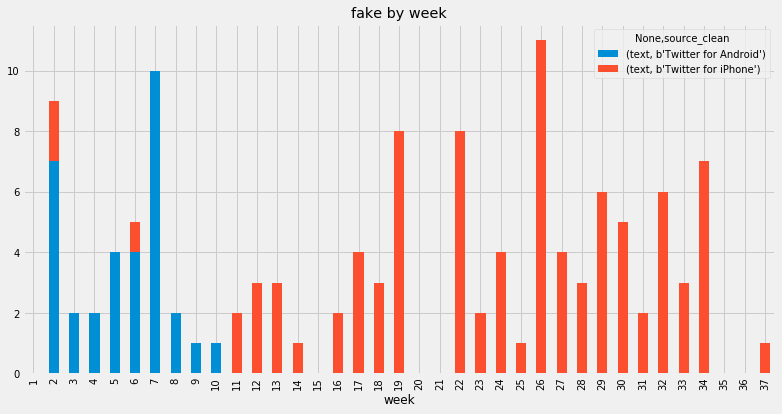

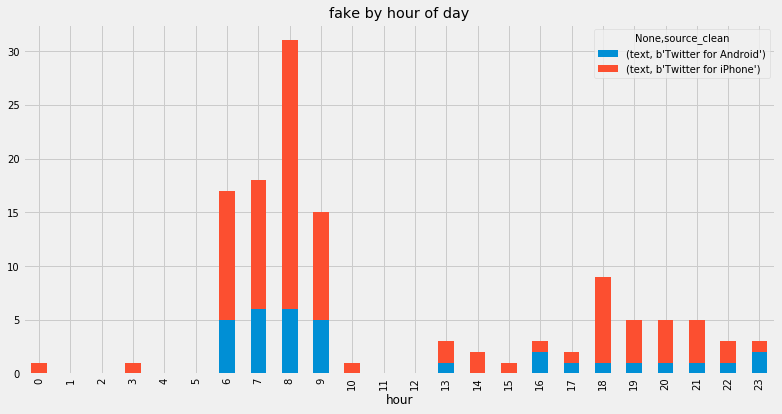

### The Tweets

[Tuesday, Sep 12, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/907588803161939968): Fascinating to watch people writing books and major articles about me and yet they know nothing about me &amp; have zero access. #FAKE NEWS!

[Friday, Aug 25, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/901031532164468736): General John Kelly is doing a fantastic job as Chief of Staff. There is tremendous spirit and talent in the W.H. Don't believe the Fake News

[Thursday, Aug 24, 2017 9:07 AM](https://twitter.com/realDonaldTrump/status/900706146943717377): The Fake News is now complaining about my different types of back to back speeches. Well, there was Afghanistan (somber), the big Rally.....

[Thursday, Aug 24, 2017 8:41 AM](https://twitter.com/realDonaldTrump/status/900699520304066561): The Fake News is now complaining about my different types of back to back speeches. Well, their was Afghanistan (somber), the big Rally.....

[Wednesday, Aug 23, 2017 9:40 AM](https://twitter.com/realDonaldTrump/status/900352052068401154): Last night in Phoenix I read the things from my statements on Charlottesville that the Fake News Media didn't cover fairly. People got it!

[Monday, Aug 21, 2017 9:32 AM](https://twitter.com/realDonaldTrump/status/899625157421039616): Thank you, the very dishonest Fake News Media is out of control! https://t.co/8J7y900VGK

[Monday, Aug 21, 2017 9:27 AM](https://twitter.com/realDonaldTrump/status/899623926082535425): Jerry Falwell of Liberty University was fantastic on @foxandfriends. The Fake News should listen to what he had to say. Thanks Jerry!

[Sunday, Aug 20, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/899411254061694979): Heading back to Washington after working hard and watching some of the worst and most dishonest Fake News reporting I have ever seen!

[Saturday, Aug 19, 2017 1:47 PM](https://twitter.com/realDonaldTrump/status/898964640817983488): Steve Bannon will be a tough and smart new voice at @BreitbartNews...maybe even better than ever before. Fake News needs the competition!

[Thursday, Aug 17, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/898130328916824064): The public is learning (even more so) how dishonest the Fake News is. They totally misrepresent what I say about hate, bigotry etc. Shame!

[Monday, Aug 14, 2017 6:29 PM](https://twitter.com/realDonaldTrump/status/897223558073602049): Made additional remarks on Charlottesville and realize once again that the #Fake News Media will never be satisfied...truly bad people!

[Tuesday, Aug 8, 2017 2:10 PM](https://twitter.com/realDonaldTrump/status/894984126582972416): After 200 days, rarely has any Administration achieved what we have achieved..not even close! Don't believe the Fake News Suppression Polls!

[Monday, Aug 7, 2017 4:15 PM](https://twitter.com/realDonaldTrump/status/894653195112378368): The Fake News Media will not talk about the importance of the United Nations Security Council's 15-0 vote in favor of sanctions on N. Korea!

[Monday, Aug 7, 2017 7:18 AM](https://twitter.com/realDonaldTrump/status/894518002795900928): Hard to believe that with 24/7 #Fake News on CNN, ABC, NBC, CBS, NYTIMES &amp; WAPO, the Trump base is getting stronger!

[Monday, Aug 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/894514535062790144): ...and West Virginia. The fact is the Fake News Russian collusion story, record Stock Market, border security, military strength, jobs.....

[Monday, Aug 7, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/894512983384129536): The Trump base is far bigger &amp;  stronger than ever before (despite some phony Fake News polling). Look at rallies in Penn, Iowa, Ohio.......

[Sunday, Aug 6, 2017 9:18 PM](https://twitter.com/realDonaldTrump/status/894367017054208001): The Fake News refuses to report the success of the first 6 months: S.C., surging economy &amp; jobs,border &amp; military security,ISIS &amp; MS-13 etc.

[Wednesday, Aug 2, 2017 9:29 PM](https://twitter.com/realDonaldTrump/status/892920397162848257): I love the White House, one of the most beautiful buildings (homes) I have ever seen. But Fake News said I called it a dump - TOTALLY UNTRUE

[Tuesday, Aug 1, 2017 9:55 AM](https://twitter.com/realDonaldTrump/status/892383242535481344): Only the Fake News Media and Trump enemies want me to stop using Social Media (110 million people). Only way for me to get the truth out!

[Saturday, Jul 29, 2017 7:15 PM](https://twitter.com/realDonaldTrump/status/891437168798965761): I love reading about all of the "geniuses" who were so instrumental in my election success. Problem is, most don't exist. #Fake News! MAGA

[Thursday, Jul 27, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/890568797941362690): ...about then candidate Trump." Catherine Herridge @FoxNews. So why doesn't Fake News report this? Witch Hunt! Purposely phony reporting.

[Monday, Jul 24, 2017 10:36 PM](https://twitter.com/realDonaldTrump/status/889675644396867584): Is Fake News Washington Post being used as a lobbyist weapon against Congress to keep Politicians from looking into Amazon no-tax monopoly?

[Monday, Jul 24, 2017 10:28 PM](https://twitter.com/realDonaldTrump/status/889673743873843200): So many stories about me in the @washingtonpost are Fake News. They are as bad as ratings challenged @CNN. Lobbyist for Amazon and taxes?

[Monday, Jul 24, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/889435104841523201): Drain the Swamp should be changed to Drain the Sewer - it's actually much worse than anyone ever thought, and it begins with the Fake News!

[Saturday, Jul 22, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/888724194820857857): While all agree the U. S. President has the complete power to pardon, why think of that when only crime so far is LEAKS against us.FAKE NEWS

[Friday, Jul 21, 2017 9:46 PM](https://twitter.com/realDonaldTrump/status/888575966259314691): Sean Spicer is a wonderful person who took tremendous abuse from the Fake News Media - but his future is bright!

[Tuesday, Jul 18, 2017 8:59 PM](https://twitter.com/realDonaldTrump/status/887477071160762369): The Fake News is becoming more and more dishonest! Even a dinner arranged for top 20 leaders in Germany is made to look sinister!

[Tuesday, Jul 18, 2017 8:53 PM](https://twitter.com/realDonaldTrump/status/887475373981696000): Fake News story of secret dinner with Putin is "sick." All G 20 leaders, and spouses, were invited by the Chancellor of Germany. Press knew!

[Sunday, Jul 16, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/886544734788997125): With all of its phony unnamed sources &amp; highly slanted &amp; even fraudulent reporting, #Fake News is DISTORTING DEMOCRACY in our country!

[Sunday, Jul 16, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/886534810575020032): HillaryClinton can illegally get the questions to the Debate &amp; delete 33,000 emails but my son Don is being scorned by the Fake News Media?

[Wednesday, Jul 12, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/885084555421634561): Remember, when you hear the words "sources say" from the Fake Media, often times those sources are made up and do not exist.

[Monday, Jul 10, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/884378624660582405): If Chelsea Clinton were asked to hold the seat for her mother,as her mother gave our country away, the Fake News would say CHELSEA FOR PRES!

[Sunday, Jul 9, 2017 8:06 AM](https://twitter.com/realDonaldTrump/status/884020939264073728): ...have it. Fake News said 17 intel agencies when actually 4 (had to apologize). Why did Obama do NOTHING when he had info before election?

[Saturday, Jul 8, 2017 2:17 PM](https://twitter.com/realDonaldTrump/status/883751888491098112): We will fight the #FakeNews with you! https://t.co/zOMiXTeLJq

[Friday, Jul 7, 2017 3:44 AM](https://twitter.com/realDonaldTrump/status/883230130885324802): I will represent our country well and fight for its interests! Fake News Media will never cover me accurately but who cares! We will #MAGA!

[Monday, Jul 3, 2017 5:10 PM](https://twitter.com/realDonaldTrump/status/881983493533822976): Dow hit a new intraday all-time high! I wonder whether or not the Fake News Media will so report?

[Monday, Jul 3, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/881847676232503297): At some point the Fake News will be forced to discuss our great jobs numbers, strong economy, success with ISIS, the border &amp; so much else!

[Saturday, Jul 1, 2017 6:08 PM](https://twitter.com/realDonaldTrump/status/881273362454118400): I am thinking about changing the name #FakeNews CNN to #FraudNewsCNN!

[Saturday, Jul 1, 2017 6:02 PM](https://twitter.com/realDonaldTrump/status/881271809433374721): ....the 2016 election with interviews, speeches and social media. I had to beat #FakeNews, and did. We will continue to WIN!

[Saturday, Jul 1, 2017 6:02 PM](https://twitter.com/realDonaldTrump/status/881271748280365056): The FAKE &amp; FRAUDULENT NEWS MEDIA is working hard to convince Republicans and others I should not use social media - but remember, I won....

[Saturday, Jul 1, 2017 9:12 AM](https://twitter.com/realDonaldTrump/status/881138485905772549): I am extremely pleased to see that @CNN has finally been exposed as #FakeNews and garbage journalism. It's about time!

[Friday, Jun 30, 2017 8:55 AM](https://twitter.com/realDonaldTrump/status/880771685460344832): Watched low rated @Morning_Joe for first time in long time. FAKE NEWS. He called me to stop a National Enquirer article. I said no! Bad show

[Wednesday, Jun 28, 2017 9:06 AM](https://twitter.com/realDonaldTrump/status/880049704620494848): The #AmazonWashingtonPost, sometimes referred to as the guardian of Amazon not paying internet taxes (which they should) is FAKE NEWS!

[Wednesday, Jun 28, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/880017678978736129): Some of the Fake News Media likes to say that I am not totally engaged in healthcare. Wrong, I know the subject well &amp; want victory for U.S.

[Wednesday, Jun 28, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/880015261004435456): The failing @nytimes writes false story after false story about me. They don't even call to verify the facts of a story. A Fake News Joke!

[Tuesday, Jun 27, 2017 8:47 AM](https://twitter.com/realDonaldTrump/status/879682547235651584): So they caught Fake News CNN cold, but what about NBC, CBS &amp; ABC? What about the failing @nytimes &amp; @washingtonpost? They are all Fake News!

[Tuesday, Jun 27, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/879678356450676736): Fake News CNN is looking at big management changes now that they got caught falsely pushing their phony Russian stories. Ratings way down!

[Tuesday, Jun 27, 2017 6:33 AM](https://twitter.com/realDonaldTrump/status/879648931172556802): Wow, CNN had to retract big story on "Russia," with 3 employees forced to resign. What about all the other phony stories they do? FAKE NEWS!

[Tuesday, Jun 20, 2017 11:48 PM](https://twitter.com/realDonaldTrump/status/877372660455546880): Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0

[Friday, Jun 16, 2017 8:23 AM](https://twitter.com/realDonaldTrump/status/875690204564258816): The Fake News Media hates when I use what has turned out to be my very powerful Social Media - over 100 million people! I can go around them

[Tuesday, Jun 13, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/874609480301936640): Fake News is at an all time high. Where is their apology to me for all of the incorrect stories???

[Tuesday, Jun 13, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/874576057579565056): The Fake News Media has never been so wrong or so dirty. Purposely incorrect stories and phony sources to meet their agenda of hate. Sad!

[Sunday, Jun 11, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/873878061778907137): The #FakeNews MSM doesn't report the great economic news since Election Day. #DOW up 16%. #NASDAQ up 19.5%. Drilling &amp; energy sector...

[Tuesday, Jun 6, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/872064426568036353): Sorry folks, but if I would have relied on the Fake News of CNN, NBC, ABC, CBS, washpost or nytimes, I would have had ZERO chance winning WH

[Tuesday, Jun 6, 2017 7:58 AM](https://twitter.com/realDonaldTrump/status/872059997429022722): The FAKE MSM is working so hard trying to get me not to use Social Media. They hate that I can get the honest and unfiltered message out.

[Tuesday, May 30, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/869509894688387072): Russian officials must be laughing at the U.S. &amp; how a lame excuse for why the Dems lost the election has taken over the Fake News.

[Sunday, May 28, 2017 8:20 PM](https://twitter.com/realDonaldTrump/status/868985285207629825): The Fake News Media works hard at disparaging &amp; demeaning my use of social media because they don't want America to hear the real story!

[Sunday, May 28, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/868810522942164993): Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered

[Sunday, May 28, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/868810404335673344): ....it is very possible that those sources don't exist but are made up by fake news writers. #FakeNews is the enemy!

[Sunday, May 28, 2017 8:40 AM](https://twitter.com/realDonaldTrump/status/868809214365487104): Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered

[Sunday, May 28, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/868807940744126464): ....it is very possible that those sources don't exsist but are made up by fake news writers. #FakeNews is the enemy!

[Sunday, May 28, 2017 8:34 AM](https://twitter.com/realDonaldTrump/status/868807754231820291): Whenever you see the words 'sources say' in the fake news media, and they don't mention names....

[Sunday, May 28, 2017 8:33 AM](https://twitter.com/realDonaldTrump/status/868807327130025984): It is my opinion that many of the leaks coming out of the White House are fabricated lies made up by the #FakeNews media.

[Friday, May 12, 2017 7:53 AM](https://twitter.com/realDonaldTrump/status/862999243560288256): The Fake Media is working overtime today!

[Wednesday, May 10, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/862290442129461249): The Roger Stone report on @CNN is false - Fake News. Have not spoken to Roger in a long time - had nothing to do with my decision.

[Monday, May 8, 2017 6:50 PM](https://twitter.com/realDonaldTrump/status/861715019674910721): Biggest story today between Clapper &amp; Yates is on surveillance. Why doesn't the media report on this? #FakeNews!

[Monday, May 8, 2017 6:43 PM](https://twitter.com/realDonaldTrump/status/861713233786404864): Sally Yates made the fake media extremely unhappy today --- she said nothing but old news!

[Monday, May 8, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/861712617299210240): Director Clapper reiterated what everybody, including the fake media already knows- there is "no evidence" of collusion w/ Russia and Trump.

[Monday, May 8, 2017 7:57 AM](https://twitter.com/realDonaldTrump/status/861550676505219073): General Flynn was given the highest security clearance by the Obama Administration - but the Fake News seldom likes talking about that.

[Sunday, May 7, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/861178291671244800): RT @FoxNews: .@POTUS: "I'm not against the media. I'm against the FAKE media." #CashinIn https://t.co/F7mBIj7iVL

[Sunday, May 7, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/861177649179373569): When will the Fake Media ask about the Dems dealings with Russia &amp; why the DNC wouldn't allow the FBI to check their server or investigate?

[Friday, May 5, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/860637673744195584): Why is it that the Fake News rarely reports Ocare is on its last legs and that insurance companies are fleeing for their lives? It's dead!

[Friday, May 5, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/860635815277453313): Wow,the Fake News media did everything in its power to make the Republican Healthcare victory look as bad as possible.Far better than Ocare!

[Thursday, May 4, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/860087334519414784): The Fake News media is officially out of control. They will do or say anything in order to get attention - never been a time like this!

[Saturday, Apr 29, 2017 1:39 PM](https://twitter.com/realDonaldTrump/status/858375278686613504): Mainstream (FAKE) media refuses to state our long list of achievements, including 28 legislative signings, strong borders &amp; great optimism!

[Tuesday, Apr 25, 2017 8:36 AM](https://twitter.com/realDonaldTrump/status/856849388026687492): Don't let the fake media tell you that I have changed my position on the WALL. It will get built and help stop drugs, human trafficking etc.

[Monday, Apr 24, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/856481786938916865): The two fake news polls released yesterday, ABC &amp; NBC, while containing some very positive info, were totally wrong in General E. Watch!

[Sunday, Apr 23, 2017 3:48 PM](https://twitter.com/realDonaldTrump/status/856233279841849344): New polls out today are very good considering that much of the media is FAKE and almost always negative. Would still beat Hillary in .....

[Wednesday, Apr 19, 2017 12:09 AM](https://twitter.com/realDonaldTrump/status/854547423464759296): Despite major outside money, FAKE media support and eleven Republican candidates, BIG "R" win with runoff in Georgia. Glad to be of help!

[Monday, Apr 17, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/853945633903923200): The Fake Media (not Real Media) has gotten even worse since the election. Every story is badly slanted. We have to hold them to the truth!

[Sunday, Apr 2, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/848519587675201538): Anybody (especially  Fake News media) who thinks that Repeal &amp; Replace of ObamaCare is dead does not know the love and strength in R Party!

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

[Saturday, Apr 1, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/848153860602507264): When will Sleepy Eyes Chuck Todd and @NBCNews start talking about the Obama SURVEILLANCE SCANDAL and stop with the Fake Trump/Russia story?

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Thursday, Mar 23, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/844886082663698436): Just watched the totally biased and fake news reports of the so-called Russia story on NBC and ABC. Such dishonesty!

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Monday, Mar 20, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/843772976151642112): James Clapper and others stated that there is no evidence Potus colluded with Russia. This story is FAKE NEWS and everyone knows it!

[Saturday, Mar 18, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/843088518339612673): Despite what you have heard from the FAKE NEWS, I had a GREAT meeting with German Chancellor Angela Merkel. Nevertheless, Germany owes.....

[Wednesday, Mar 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/841966077005463553): Does anybody really believe that a reporter, who nobody ever heard of, "went to his mailbox" and found my tax returns? @NBCNews  FAKE NEWS!

[Tuesday, Mar 7, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/839116941956640768): Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Monday, Feb 20, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/833681539997253636): Give the public a break - The FAKE NEWS media is trying to say that large scale immigration in Sweden is working out just beautifully. NOT!

[Saturday, Feb 18, 2017 8:31 AM](https://twitter.com/realDonaldTrump/status/832945737625387008): Don't believe the main stream (fake news) media.The White House is running VERY WELL. I inherited a MESS and am in the process of fixing it.

[Friday, Feb 17, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/832730328108134402): "One of the most effective press conferences I've ever seen!" says Rush Limbaugh. Many agree.Yet FAKE MEDIA  calls it differently! Dishonest

[Friday, Feb 17, 2017 4:48 PM](https://twitter.com/realDonaldTrump/status/832708293516632065): The FAKE NEWS media (failing @nytimes, @NBCNews, @ABC, @CBS, @CNN) is not my enemy, it is the enemy of the American People!

[Friday, Feb 17, 2017 4:32 PM](https://twitter.com/realDonaldTrump/status/832704292993847296): The FAKE NEWS media (failing @nytimes, @CNN, @NBCNews and many more)    is not my enemy, it is the enemy of the American people. SICK!

[Friday, Feb 17, 2017 6:43 AM](https://twitter.com/realDonaldTrump/status/832555987299082242): Thank you for all of the nice statements on the Press Conference yesterday. Rush Limbaugh said one of greatest ever. Fake media not happy!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Thursday, Feb 16, 2017 9:10 AM](https://twitter.com/realDonaldTrump/status/832230758299340800): FAKE NEWS media, which makes up stories and "sources," is far more effective than the discredited Democrats - but they are fading fast!

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Sunday, Feb 12, 2017 5:19 PM](https://twitter.com/realDonaldTrump/status/830904083519242241): Just leaving Florida. Big crowds of enthusiastic supporters lining the road that the FAKE NEWS media refuses to mention. Very dishonest!

[Sunday, Feb 12, 2017 7:14 AM](https://twitter.com/realDonaldTrump/status/830751875578355713): While on FAKE NEWS @CNN, Bernie Sanders was cut off for using the term fake news to describe the network. They said technical difficulties!

[Friday, Feb 10, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/830047626414477312): The failing @nytimes does major FAKE NEWS China story saying "Mr.Xi has not spoken to Mr. Trump since Nov.14." We spoke at length yesterday!

[Thursday, Feb 9, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/829681034564341760): Chris Cuomo, in his interview with Sen. Blumenthal, never asked him about his long-term lie about his brave "service" in Vietnam. FAKE NEWS!

[Wednesday, Feb 8, 2017 10:54 AM](https://twitter.com/realDonaldTrump/status/829357626798530561): '16 Fake News Stories Reporters Have Run Since Trump Won' https://t.co/0dHld5kiVc

[Monday, Feb 6, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/828575949268606977): I call my own shots, largely based on an accumulation of data, and everyone knows it. Some FAKE NEWS media, in order to marginalize, lies!

[Monday, Feb 6, 2017 7:01 AM](https://twitter.com/realDonaldTrump/status/828574430800539648): Any negative polls are fake news, just like the CNN, ABC, NBC polls in the election. Sorry, people want border security and extreme vetting.

[Saturday, Feb 4, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/827874208021639168): After being forced to apologize for its bad and inaccurate coverage of me after winning the election, the FAKE NEWS @nytimes is still lost!

[Friday, Feb 3, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/827480386120929280): Thank you to Prime Minister of Australia for telling the truth about our very civil conversation that FAKE NEWS media lied about. Very nice!

[Tuesday, Jan 31, 2017 6:21 AM](https://twitter.com/realDonaldTrump/status/826390034693623809): Nancy Pelosi and Fake Tears Chuck Schumer held a rally  at the steps of The Supreme Court and mic did not work (a mess)-just like Dem party!

[Sunday, Jan 29, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/825690087857995776): Somebody with aptitude and conviction should buy the FAKE NEWS and failing @nytimes and either run it correctly or let it fold with dignity!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

[Tuesday, Jan 24, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/824078417213747200): Congratulations to @FoxNews for being number one in inauguration ratings. They were many times higher than FAKE NEWS @CNN - public is smart!

[Wednesday, Jan 18, 2017 7:44 AM](https://twitter.com/realDonaldTrump/status/821699672687448064): to the U.S., but had nothing to do with TRUMP, is more FAKE NEWS. Ask top CEO's of those companies for real facts. Came back because of me!

[Sunday, Jan 15, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/820789938887294977): much worse - just look at Syria (red line), Crimea, Ukraine and the build-up of Russian nukes. Not good! Was this the leaker of Fake News?

[Friday, Jan 13, 2017 6:11 AM](https://twitter.com/realDonaldTrump/status/819864373988573184): Totally made up facts by sleazebag political operatives, both Democrats and Republicans - FAKE NEWS! Russia says nothing exists. Probably...

[Thursday, Jan 12, 2017 9:22 AM](https://twitter.com/realDonaldTrump/status/819550083742109696): .@CNN is in a total meltdown with their FAKE NEWS because their ratings are tanking since election and their credibility will soon be gone!

[Wednesday, Jan 11, 2017 11:01 PM](https://twitter.com/realDonaldTrump/status/819393877174087682): We had a great News Conference at Trump Tower today. A couple of FAKE NEWS organizations were there but the people truly get what's going on

[Wednesday, Jan 11, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/819164172781060096): Intelligence agencies should never have allowed this fake news to "leak" into the public. One last shot at me.Are we living in Nazi Germany?

[Wednesday, Jan 11, 2017 7:44 AM](https://twitter.com/realDonaldTrump/status/819162968592183298): I win an election easily, a great "movement" is verified, and crooked opponents try to belittle our victory with FAKE NEWS. A sorry state!

[Tuesday, Jan 10, 2017 9:00 PM](https://twitter.com/realDonaldTrump/status/819000924207251456): 'BuzzFeed Runs Unverifiable Trump-Russia Claims' #FakeNews 
https://t.co/d6daCFZHNh

[Tuesday, Jan 10, 2017 8:35 PM](https://twitter.com/realDonaldTrump/status/818994757569564673): RT @MichaelCohen212: I have never been to Prague in my life. #fakenews https://t.co/CMil9Rha3D

[Tuesday, Jan 10, 2017 8:19 PM](https://twitter.com/realDonaldTrump/status/818990655418617856): FAKE NEWS - A TOTAL POLITICAL WITCH HUNT!

[Sunday, Jan 8, 2017 11:05 PM](https://twitter.com/realDonaldTrump/status/818307689323368448): Dishonest media says Mexico won't be paying for the wall if they pay a little later so the wall can be built more quickly. Media is fake!

---

## Search: _mexic_

Number of Tweets: 20

Percent of all Tweets: 1.19%

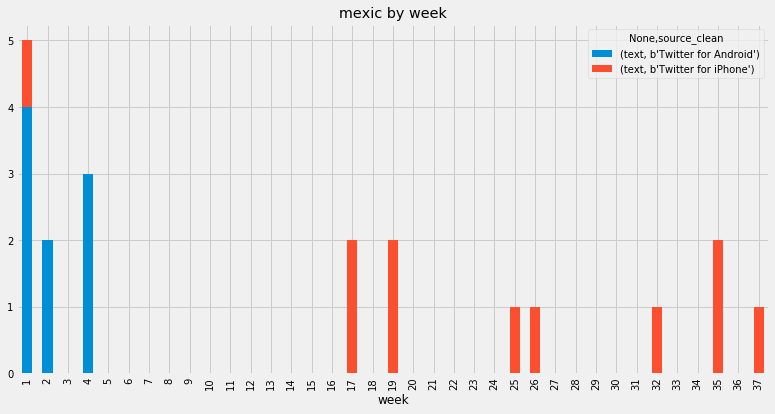

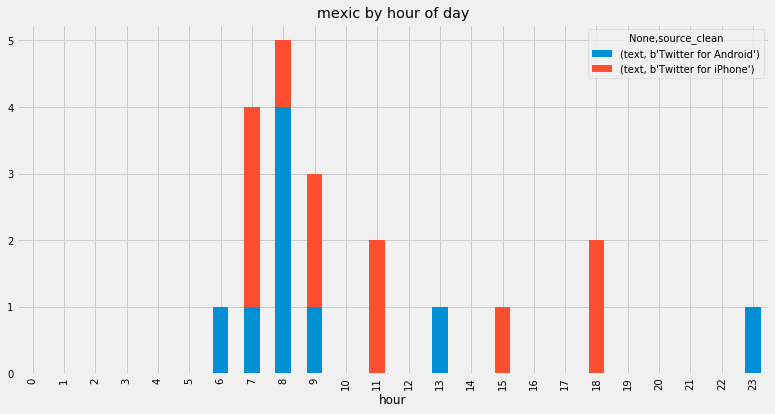

### The Tweets

[Thursday, Sep 14, 2017 3:18 PM](https://twitter.com/realDonaldTrump/status/908409572943126528): Spoke to President of Mexico to give condolences on terrible earthquake. Unable to reach for 3 days b/c of his cell phone reception at site.

[Sunday, Aug 27, 2017 9:51 AM](https://twitter.com/realDonaldTrump/status/901804388649500672): We are in the NAFTA (worst trade deal ever made) renegotiation process with Mexico &amp; Canada.Both being very difficult,may have to terminate?

[Sunday, Aug 27, 2017 9:44 AM](https://twitter.com/realDonaldTrump/status/901802524981817344): With Mexico being one of the highest crime Nations in the world, we must have THE WALL. Mexico will pay for it through reimbursement/other.

[Wednesday, Aug 9, 2017 7:22 AM](https://twitter.com/realDonaldTrump/status/895244004803194880): RT @foxandfriends: Millions of gallons of Mexican waste threaten Border Patrol agents https://t.co/yGAq4IgHOs

[Thursday, Jun 29, 2017 8:27 AM](https://twitter.com/realDonaldTrump/status/880402366373269504): New Sugar deal negotiated with Mexico is a very good one for both Mexico and the U.S. Had no deal for many years which hurt U.S. badly.

[Thursday, Jun 22, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/878013639613186049): Mexico was just ranked the second deadliest country in the world, after only Syria. Drug trade is largely the cause. We will BUILD THE WALL!

[Wednesday, May 10, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/862266225157689349): RT @DRUDGE_REPORT: MEXICO 2ND DEADLIEST COUNTRY; TOPS AFGHAN, IRAQ... https://t.co/i4FtSpLiHV

[Sunday, May 7, 2017 6:58 PM](https://twitter.com/realDonaldTrump/status/861354654856249344): Rexnord of Indiana made a deal during the Obama Administration to move to Mexico. Fired their employees. Tax product big that's sold in U.S.

[Thursday, Apr 27, 2017 7:12 AM](https://twitter.com/realDonaldTrump/status/857552956836786177): I received calls from the President of Mexico and the Prime Minister of Canada asking to renegotiate NAFTA rather than terminate. I agreed..

[Sunday, Apr 23, 2017 11:44 AM](https://twitter.com/realDonaldTrump/status/856172056932700164): Eventually, but at a later date so we can get started early, Mexico will be paying, in some form, for the badly needed border wall.

[Friday, Jan 27, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/824970003153842176): Mexico has taken advantage of the U.S. for long enough. Massive trade deficits &amp; little help on the very weak border must change, NOW!

[Thursday, Jan 26, 2017 8:55 AM](https://twitter.com/realDonaldTrump/status/824616644370714627): of jobs and companies lost. If Mexico is unwilling to pay for the badly needed wall, then it would be better to cancel the upcoming meeting.

[Thursday, Jan 26, 2017 8:51 AM](https://twitter.com/realDonaldTrump/status/824615820391305216): The U.S. has a 60 billion dollar trade deficit with Mexico. It has been a one-sided deal from the beginning of NAFTA with massive numbers...

[Monday, Jan 9, 2017 9:16 AM](https://twitter.com/realDonaldTrump/status/818461467766824961): Ford said last week that it will expand in Michigan and U.S. instead of building a BILLION dollar plant in Mexico. Thank you Ford &amp; Fiat C!

[Sunday, Jan 8, 2017 11:05 PM](https://twitter.com/realDonaldTrump/status/818307689323368448): Dishonest media says Mexico won't be paying for the wall if they pay a little later so the wall can be built more quickly. Media is fake!

[Friday, Jan 6, 2017 6:19 AM](https://twitter.com/realDonaldTrump/status/817329823374831617): The dishonest media does not report that any money spent on building the Great Wall (for sake of speed), will be paid back by Mexico later!

[Thursday, Jan 5, 2017 1:14 PM](https://twitter.com/realDonaldTrump/status/817071792711942145): Toyota Motor said will build a new plant in Baja, Mexico, to build Corolla cars for U.S. NO WAY! Build plant in U.S. or pay big border tax.

[Wednesday, Jan 4, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/816635078067490816): Thank you to Ford for scrapping a new plant in Mexico and creating 700 new jobs in the U.S. This is just the beginning - much more to follow

[Tuesday, Jan 3, 2017 11:44 AM](https://twitter.com/realDonaldTrump/status/816324295781740544): "@DanScavino: Ford to scrap Mexico plant, invest in Michigan due to Trump policies"
https://t.co/137nUo03Gl

[Tuesday, Jan 3, 2017 7:30 AM](https://twitter.com/realDonaldTrump/status/816260343391514624): General Motors is sending Mexican made model of Chevy Cruze to U.S. car dealers-tax free across border. Make in U.S.A.or pay big border tax!

---

## Search: _fox_

Number of Tweets: 118

Percent of all Tweets: 7.04%

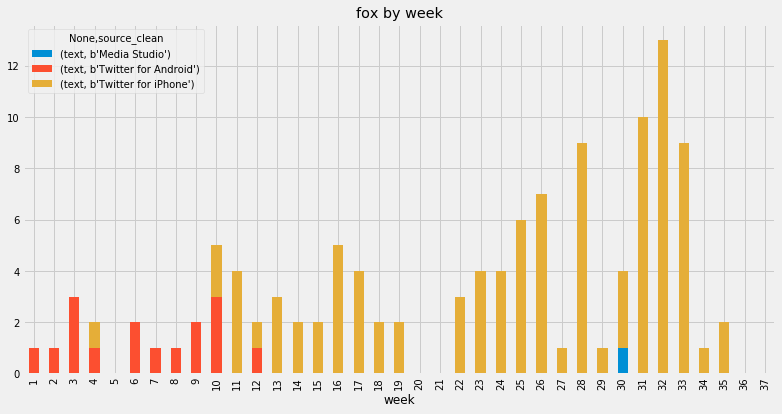

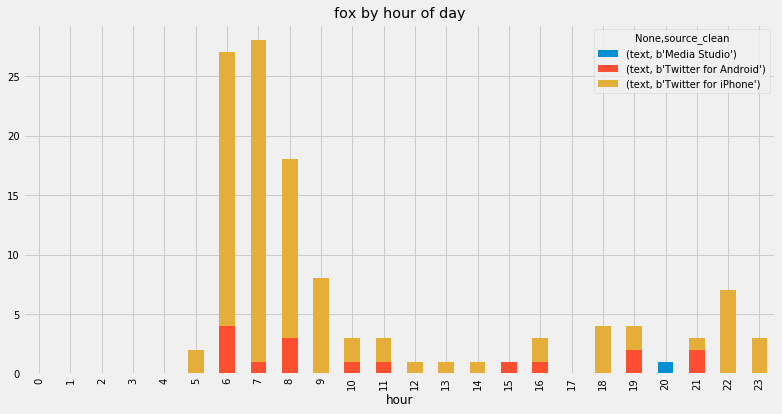

### The Tweets

[Thursday, Aug 31, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/903234878124249090): RT @FoxNews: .@KellyannePolls on Harvey recovery: We hope when it comes to basic Hurricane Harvey funding that we can rely upon a nonpartis…

[Tuesday, Aug 29, 2017 8:26 AM](https://twitter.com/realDonaldTrump/status/902507855584092160): .@foxandfriends   We are not looking to fill all of those positions. Don't need many of them - reduce size of government. @IngrahamAngle

[Monday, Aug 21, 2017 9:27 AM](https://twitter.com/realDonaldTrump/status/899623926082535425): Jerry Falwell of Liberty University was fantastic on @foxandfriends. The Fake News should listen to what he had to say. Thanks Jerry!

[Wednesday, Aug 16, 2017 7:32 AM](https://twitter.com/realDonaldTrump/status/897783159038910466): RT @FoxNews: .@POTUS: "Our infrastructure will again be the best in the world. We used to have the greatest infrastructure anywhere in the…

[Wednesday, Aug 16, 2017 7:23 AM](https://twitter.com/realDonaldTrump/status/897780828134141952): RT @CLewandowski_: Please watch @foxandfriends today at 7:30 AM to watch me discuss @realDonaldTrump.

[Tuesday, Aug 15, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/897413442696597505): RT @MikeHolden42: @foxandfriends @realDonaldTrump He's a fascist, so not unusual.

[Tuesday, Aug 15, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/897413405002387456): RT @SLandinSoCal: @foxandfriends @realDonaldTrump Nothing can stop the #TrumpTrain‼️ https://t.co/PprEMbiZQa

[Tuesday, Aug 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/897411536460886016): RT @foxandfriends: FOX NEWS EXCLUSIVE: President Trump 'seriously considering' a pardon for ex-Sheriff Joe Arpaio https://t.co/Rgw8l7i9Xl

[Tuesday, Aug 15, 2017 6:54 AM](https://twitter.com/realDonaldTrump/status/897411177583702016): @foxandfriends According to report just out, President Obama knew about Russian interference 3 years ago but he didn't want to anger Russia!

[Tuesday, Aug 15, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/897405235924275200): Senator Luther Strange, who is doing a great job for the people of Alabama, will be on @foxandfriends at 7:15. Tough on crime, borders etc.

[Monday, Aug 14, 2017 10:38 PM](https://twitter.com/realDonaldTrump/status/897286242886463489): RT @foxandfriends: Sec. Mattis: If North Korea fires missile at US, it's 'game on' https://t.co/CfPL9u2I2G

[Sunday, Aug 13, 2017 6:01 PM](https://twitter.com/realDonaldTrump/status/896854197114732544): RT @FoxNews: .@AlanDersh: Trump Has 'More Credibility' Than Obama With North Korea https://t.co/0w1L01EL0q https://t.co/9Q3FYUmNy1

[Friday, Aug 11, 2017 7:12 AM](https://twitter.com/realDonaldTrump/status/895966256813268994): RT @foxandfriends: Trump fires new warning shot at McConnell, leaves door open on whether he should step down https://t.co/tJIRc0usWl

[Friday, Aug 11, 2017 7:12 AM](https://twitter.com/realDonaldTrump/status/895966080690257920): RT @foxandfriends: Senators learn the hard way about the fallout from turning on Trump https://t.co/wq8Im1cHpy

[Friday, Aug 11, 2017 7:08 AM](https://twitter.com/realDonaldTrump/status/895965025931808768): RT @foxandfriends: FOX NEWS ALERT: 2 US drone strikes in Somalia target Al Qaeda and Al-Shabaab https://t.co/MqrY7zbMy2

[Thursday, Aug 10, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/895604995537678336): RT @foxandfriends: FOX NEWS ALERT: North Korea responds to U.S. with Guam attack plan as Secretary Mattis warns Kim Jung Un “he is grossly…

[Wednesday, Aug 9, 2017 7:26 AM](https://twitter.com/realDonaldTrump/status/895244964904542208): RT @foxandfriends: President Trump vows America will respond to North Korean threats with "fire &amp; fury" in a warning to the rogue nation ht…

[Wednesday, Aug 9, 2017 7:24 AM](https://twitter.com/realDonaldTrump/status/895244450053726209): RT @foxandfriends: France vehicle attack leaves at least six soldiers injured

https://t.co/bm7gevcQi2

[Wednesday, Aug 9, 2017 7:23 AM](https://twitter.com/realDonaldTrump/status/895244121241255936): RT @foxandfriends: Trump vows U.S. 'power' will meet North Korean threat https://t.co/od7Ohr51XD

[Wednesday, Aug 9, 2017 7:22 AM](https://twitter.com/realDonaldTrump/status/895244004803194880): RT @foxandfriends: Millions of gallons of Mexican waste threaten Border Patrol agents https://t.co/yGAq4IgHOs

[Wednesday, Aug 9, 2017 7:22 AM](https://twitter.com/realDonaldTrump/status/895243804013416449): RT @foxandfriends: U.S. Air Force jets take off from Guam for training, ensuring they can 'fight tonight' https://t.co/E4EGIyNSHP

[Tuesday, Aug 8, 2017 2:11 PM](https://twitter.com/realDonaldTrump/status/894984483291750401): RT @FoxNews: Jobs added during @POTUS' time in office. https://t.co/zD0FkFvHVx

[Tuesday, Aug 8, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/894875690423726080): RT @foxandfriends: OPIOID CRISIS: Worse than we thought, with a new study showing overdose deaths were under reported https://t.co/27kLJKRX…

[Tuesday, Aug 8, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/894875602045607936): RT @foxandfriends: Anthem announces it will withdraw from ObamaCare Exchange in Nevada https://t.co/d0CxeHQKwz

[Tuesday, Aug 8, 2017 6:41 AM](https://twitter.com/realDonaldTrump/status/894871302250668032): RT @foxandfriends: U.S. spy satellites detect North Korea moving anti-ship cruise missiles to patrol boat https://t.co/BPFXsLffgy

[Saturday, Aug 5, 2017 7:01 PM](https://twitter.com/realDonaldTrump/status/893970139565129730): Thank you Nicole! https://t.co/KlWN05uFOx

[Saturday, Aug 5, 2017 7:12 AM](https://twitter.com/realDonaldTrump/status/893791726896381952): RT @FoxNews: More than 1 million jobs added since @POTUS took office. https://t.co/ZVsC9oi9Ds https://t.co/NNL1FwNMLU

[Friday, Aug 4, 2017 9:21 AM](https://twitter.com/realDonaldTrump/status/893461771813564416): RT @paultdove: @FoxBusiness Republican Senators who are opposing the President, look at the great economic news: Americans Are Noticing!

[Friday, Aug 4, 2017 9:20 AM](https://twitter.com/realDonaldTrump/status/893461607275270144): RT @Bet22325450ste: @FoxBusiness @foxandfriends Come on America. Get on the Trump Train. The winners already have boarded! The losers are w…

[Friday, Aug 4, 2017 9:18 AM](https://twitter.com/realDonaldTrump/status/893461264474804224): RT @FoxBusiness: #BreakingNews: U.S. employers added 209,000 jobs in July, unemployment rate down to 4.3% #JobsReport https://t.co/mWaTLMg1…

[Friday, Aug 4, 2017 9:18 AM](https://twitter.com/realDonaldTrump/status/893461175278718976): RT @foxandfriends: .@JudgeJeanine: There will be an uproar in this country if they end up with an indictment against a Trump family member…

[Friday, Aug 4, 2017 6:21 AM](https://twitter.com/realDonaldTrump/status/893416615504748544): ....and don't forget that Foxconn will be spending up to 10 billion dollars on a top of the line plant/plants in Wisconsin.

[Thursday, Aug 3, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/893079018605621248): RT @foxandfriends: Insurers seeking huge premium hikes on ObamaCare plans https://t.co/YrUwvMKlyb

[Tuesday, Aug 1, 2017 9:03 AM](https://twitter.com/realDonaldTrump/status/892370324616089600): "Corporations have NEVER made as much money as they are making now." Thank you Stuart Varney @foxandfriends Jobs are starting to roar,watch!

[Monday, Jul 31, 2017 8:29 AM](https://twitter.com/realDonaldTrump/status/891999166074847232): RT @foxandfriends: .@Suffolk_Sheriff praises President Trump for making gang eradication a priority https://t.co/uNY7jBhleE

[Thursday, Jul 27, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/890568797941362690): ...about then candidate Trump." Catherine Herridge @FoxNews. So why doesn't Fake News report this? Witch Hunt! Purposely phony reporting.

[Thursday, Jul 27, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/890524387773997056): Wow, the Failing @nytimes said about @foxandfriends "....the most powerful T.V. show in America."

[Wednesday, Jul 26, 2017 8:01 PM](https://twitter.com/realDonaldTrump/status/890361489126805504): Thank you Foxconn, for investing $10 BILLION DOLLARS with the potential for up to 13K new jobs in Wisconsin! MadeInTheUSA🇺🇸 https://t.co/jJghVeb63s

[Wednesday, Jul 26, 2017 6:44 AM](https://twitter.com/realDonaldTrump/status/890160810294685696): RT @foxandfriends: Sen. John McCain making his return to the Senate ahead of health care vote https://t.co/VuojpRpcLM

[Tuesday, Jul 18, 2017 9:03 PM](https://twitter.com/realDonaldTrump/status/887478019346051075): RT @FoxNews: U.S. Markets since election. https://t.co/rlWSt30GUd

[Wednesday, Jul 12, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/885086466061340674): RT @foxandfriends: Getting the job done! Sen. Mitch McConnell delays August recess to work on health care bill https://t.co/wBjha8ldeK

[Wednesday, Jul 12, 2017 5:55 AM](https://twitter.com/realDonaldTrump/status/885075206905188352): RT @FoxNews: .@jessebwatters on @DonaldJTrumpJr meeting with Russian attorney: "I believe Don Jr. is the victim here." #TheFive https://t.c…

[Tuesday, Jul 11, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/884758617282531329): RT @foxandfriends: FOX NEWS ALERT: U.S. flexes its defense muscles, destroys incoming test missile off coast of Alaska https://t.co/gdpnc6a…

[Tuesday, Jul 11, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/884726279014100992): RT @foxandfriends: SEN. CRUZ: It's crazy to go an August recess without having Obamacare repealed. We should work every day until it is don…

[Tuesday, Jul 11, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/884726129910853634): RT @foxandfriends: White House calls out Senate Democrats for obstructing nominees https://t.co/O6Rsx5i2CZ

[Monday, Jul 10, 2017 7:54 AM](https://twitter.com/realDonaldTrump/status/884380352436985856): RT @foxandfriends: Head of the NYPD union slams Mayor de Blasio for skipping vigil for assassinated cop Miosotis Familia https://t.co/nVWLb…

[Monday, Jul 10, 2017 7:54 AM](https://twitter.com/realDonaldTrump/status/884380242936254464): RT @foxandfriends: .@jasoninthehouse: Comey went silent when I asked him about his memos, which raised a lot of eyebrows. https://t.co/BfSP…

[Monday, Jul 10, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/884360051808448512): RT @foxandfriends: Report accuses material James Comey leaked to a friend contained top secret information https://t.co/Hkg4cAb6o9

[Monday, Jul 10, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/884359576996511745): RT @foxandfriends: .@carriesheffield: The mainstream media is neglecting their duty to represent the public. They've failed to represent ha…

[Monday, Jul 3, 2017 4:44 PM](https://twitter.com/realDonaldTrump/status/881976958556549120): Thank you to Shawn Steel for the nice words on @FoxNews.

[Wednesday, Jun 28, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/880018828603912194): RT @foxandfriends: HAPPENING TODAY: House to vote on immigration bills including 'Kate’s Law' and 'No Sanctuary for Criminals Act' https://…

[Tuesday, Jun 27, 2017 7:23 AM](https://twitter.com/realDonaldTrump/status/879661481360588800): RT @foxandfriends: President Trump officially nominates former Assistant Attorney General Christopher Wray to head the FBI https://t.co/ld7…

[Tuesday, Jun 27, 2017 7:19 AM](https://twitter.com/realDonaldTrump/status/879660494218547202): RT @foxandfriends: Another Dem 'queasy' over claim of Loretta Lynch meddling in Clinton case https://t.co/wdQ9MduxOO

[Tuesday, Jun 27, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/879655772111679488): RT @foxandfriends: Hannity: Russia allegations 'boomeranging back' on Democrats https://t.co/lvdrpxpcp9

[Tuesday, Jun 27, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/879655576803913728): RT @foxandfriends: Mark Levin: The collusion is among the Democrats https://t.co/Qrca7r01BI

[Monday, Jun 26, 2017 10:24 PM](https://twitter.com/realDonaldTrump/status/879525817361068032): From @FoxNews "Bombshell: In 2016, Obama dismissed idea that anyone could rig an American election."  Check out his statement - Witch Hunt!

[Sunday, Jun 25, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/878947806442119168): I am on @foxandfriends - Enjoy!

[Friday, Jun 23, 2017 6:07 AM](https://twitter.com/realDonaldTrump/status/878192867847675904): Will be on @foxandfriends. Enjoy!

[Thursday, Jun 22, 2017 11:02 PM](https://twitter.com/realDonaldTrump/status/878085811941539849): RT @foxandfriends: POTUS the predictor? President Trump foretold housing upswing in 2012 https://t.co/N3LMDZKTK1

[Thursday, Jun 22, 2017 11:00 PM](https://twitter.com/realDonaldTrump/status/878085201494147076): RT @foxnation: .@SenTedCruz: I want to Get to a 'Yes' Vote: https://t.co/g0vafw4ef2

[Tuesday, Jun 20, 2017 10:33 PM](https://twitter.com/realDonaldTrump/status/877353797760286720): Thank you @FoxNews "Huge win for President Trump and GOP in Georgia Congressional Special Election."

[Monday, Jun 19, 2017 7:56 PM](https://twitter.com/realDonaldTrump/status/876951845880688644): RT @FoxNews: New Poll Shows @POTUS Approval at 50 Percent
https://t.co/FRWlSVvxzQ

[Monday, Jun 19, 2017 7:59 AM](https://twitter.com/realDonaldTrump/status/876771526208626688): Jay Sekulow on @foxandfriends now.

[Monday, Jun 12, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/874218586155479040): Ivanka on @foxandfriends now!

[Sunday, Jun 11, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/874086142425083904): RT @foxandfriends: .@GeraldoRivera: Chances of impeachment went from 3% to 0% with Comey's testimony https://t.co/kfeXKdpJGe

[Sunday, Jun 11, 2017 10:07 PM](https://twitter.com/realDonaldTrump/status/874085723762286592): RT @foxandfriends: "Yesterday's hearings provided zero evidence of collusion between our campaign and the Russians because there wasn't any…

[Sunday, Jun 11, 2017 10:02 PM](https://twitter.com/realDonaldTrump/status/874084433460154368): My daughter, Ivanka, will be on @foxandfriends tomorrow morning. Enjoy!

[Friday, Jun 9, 2017 6:54 AM](https://twitter.com/realDonaldTrump/status/873131235614347264): Great reporting by @foxandfriends and so many others. Thank you!

[Tuesday, Jun 6, 2017 6:43 AM](https://twitter.com/realDonaldTrump/status/872041195618349056): RT @foxandfriends: FOX NEWS ALERT: ISIS claims responsibility for hostage siege in Melbourne, Australia that killed 1 person and injured 3…

[Tuesday, Jun 6, 2017 6:41 AM](https://twitter.com/realDonaldTrump/status/872040726120550404): RT @foxandfriends: Sen. Ted Cruz: Trump's air traffic control plan is a 'win-win' for Democrats and Republicans https://t.co/TsggUEfOO2

[Monday, Jun 5, 2017 9:35 AM](https://twitter.com/realDonaldTrump/status/871722020278587393): .@foxandfriends  Dems are taking forever to approve my people, including Ambassadors. They are nothing but OBSTRUCTIONISTS! Want approvals.

[Friday, Jun 2, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/870589692294647808): RT @HeyTammyBruce: Coming up at 720a ET on @foxandfriends! See you there! 🇺🇸 #maga

[Friday, Jun 2, 2017 6:08 AM](https://twitter.com/realDonaldTrump/status/870582867084050432): RT @foxandfriends: Wall Street hits record highs after Trump pulls out of Climate pact https://t.co/PDmwj13Lus

[Tuesday, May 30, 2017 10:01 AM](https://twitter.com/realDonaldTrump/status/869554306806157312): RT @foxandfriends: Jared Kushner didn't suggest Russian communications channel in meeting, source says https://t.co/nF6bM1FEt1

[Saturday, May 13, 2017 1:54 PM](https://twitter.com/realDonaldTrump/status/863452412459307009): Will be interviewed by @JudgeJeanine on @FoxNews at 9:00 P.M. (Saturday night). Enjoy!

[Sunday, May 7, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/861178291671244800): RT @FoxNews: .@POTUS: "I'm not against the media. I'm against the FAKE media." #CashinIn https://t.co/F7mBIj7iVL

[Thursday, May 4, 2017 7:09 AM](https://twitter.com/realDonaldTrump/status/860088977277235201): RT @foxandfriends: President Trump to sign an executive order on religious liberty today, the National Day of Prayer | @kevincorke https://…

[Thursday, May 4, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/860088511202029569): Congratulations to @foxandfriends on its unbelievable ratings hike.

[Friday, Apr 28, 2017 10:34 PM](https://twitter.com/realDonaldTrump/status/858147464846729217): RT @foxnation: . @TuckerCarlson : #Dems Don't Really Believe #Trump Is a Pawn of #Russia - That's Just Their Political Tool  https://t.co/K…

[Friday, Apr 28, 2017 6:31 PM](https://twitter.com/realDonaldTrump/status/858086278037950464): I will be interviewed by @MarthaMaccallum on @FoxNews tonight at 7pm. Enjoy!

[Friday, Apr 28, 2017 8:12 AM](https://twitter.com/realDonaldTrump/status/857930456767111168): RT @foxandfriends: Former President Obama's $400K Wall Street speech stuns liberal base; Sen. Warren saying she "was troubled by that" http…

[Sunday, Apr 23, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/856147612952612864): Thank you Lake Worth, Florida. @foxandfriends

[Saturday, Apr 22, 2017 11:18 AM](https://twitter.com/realDonaldTrump/status/855803080310390784): RT @foxandfriends: Israeli PM Netanyahu praises U.S. policy changes during meeting with Defense. Sec Mattis https://t.co/v2C9oaq3uY

[Saturday, Apr 22, 2017 11:18 AM](https://twitter.com/realDonaldTrump/status/855802920956243969): RT @foxandfriends: Chicago approves new plan to hide illegal immigrants from the feds, plus give them access to city services https://t.co/…

[Friday, Apr 21, 2017 6:11 AM](https://twitter.com/realDonaldTrump/status/855363343607103489): RT @foxandfriends: NYT editor apologizes for misleading tweet about New England Patriots' visit to the White House (via @FoxFriendsFirst) h…

[Tuesday, Apr 18, 2017 5:48 AM](https://twitter.com/realDonaldTrump/status/854270321620287490): I will be interviewed on @foxandfriends by @ainsleyearhardt starting at 6:00 A.M. Enjoy!

[Monday, Apr 17, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/853942936337350656): "The first 90 days of my presidency has exposed the total failure of the last eight years of foreign policy!" So true. @foxandfriends

[Tuesday, Apr 11, 2017 11:16 PM](https://twitter.com/realDonaldTrump/status/851997299454742528): I will be interviewed by @MariaBartiromo at 6:00 A.M. @FoxBusiness. Enjoy!

[Tuesday, Apr 11, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/851763890786635776): RT @foxnation: Grateful Syrians React To @realDonaldTrump Strike: 'I'll Name My Son Donald' https://t.co/7KexXsXLUx #SyrianStrikes

[Monday, Apr 3, 2017 8:51 AM](https://twitter.com/realDonaldTrump/status/848880519458717698): .@FoxNews from multiple sources: "There was electronic surveillance of Trump, and people close to Trump. This is unprecedented." @FBI

[Monday, Apr 3, 2017 6:15 AM](https://twitter.com/realDonaldTrump/status/848841326183534594): Such amazing reporting on unmasking and the crooked scheme against us by @foxandfriends. "Spied on before nomination." The real story.

[Saturday, Apr 1, 2017 12:50 PM](https://twitter.com/realDonaldTrump/status/848216035153121285): Wow, @FoxNews just reporting big news. Source: "Official behind unmasking is high up. Known Intel official is responsible. Some unmasked....

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Tuesday, Mar 28, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/846682464215076866): Watch @foxandfriends now on Podesta and Russia!

[Saturday, Mar 25, 2017 10:41 AM](https://twitter.com/realDonaldTrump/status/845646761704243200): Watch @JudgeJeanine on @FoxNews tonight at 9:00 P.M.

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Friday, Mar 17, 2017 8:34 AM](https://twitter.com/realDonaldTrump/status/842715710765830147): RT @foxandfriends: FOX NEWS ALERT: Jihadis using religious visa to enter US, experts warn (via @FoxFriendsFirst) https://t.co/pwXeR9OMQC

[Friday, Mar 17, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/842714739365105664): RT @foxandfriends: VIDEO: Rep. Scalise — GOP agrees on over 85 percent of health care bill https://t.co/05dtfjAUbx

[Friday, Mar 17, 2017 8:20 AM](https://twitter.com/realDonaldTrump/status/842712210896052225): RT @FoxNews: Jobs created in February. https://t.co/sOaMDxxTA8

[Wednesday, Mar 15, 2017 4:55 PM](https://twitter.com/realDonaldTrump/status/842117164144431104): I will be interviewed by @TuckerCarlson tonight at 9:00 P.M. on @FoxNews. Enjoy!

[Friday, Mar 10, 2017 8:32 AM](https://twitter.com/realDonaldTrump/status/840193545046773760): RT @foxandfriends: "Never give up....that's the worst thing you could do. There's always a chance." -Kyle Coddington's message to those als…

[Thursday, Mar 9, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/839826581354921984): RT @foxnation: .@realDonaldTrump's First Full Month in Office Sees Biggest Jobs Gain 'In Years': Report: https://t.co/rx4bgI1MWK

[Tuesday, Mar 7, 2017 8:41 AM](https://twitter.com/realDonaldTrump/status/839108868584124417): Don't worry, getting rid of state lines, which will promote competition, will be in phase 2 &amp; 3 of healthcare rollout. @foxandfriends

[Tuesday, Mar 7, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/839101660886614016): For eight years Russia "ran over" President Obama, got stronger and stronger, picked-off Crimea and added missiles. Weak! @foxandfriends

[Sunday, Mar 5, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/838353481526312961): Who was it that secretly said to Russian President, "Tell Vladimir that after the election I'll have more flexibility?" @foxandfriends

[Friday, Mar 3, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/837633820417482754): Nick Adams new book, Green Card Warrior, is a must read. The merit-based system is the way to go. Canada, Australia! @foxandfriends

[Monday, Feb 27, 2017 9:43 PM](https://twitter.com/realDonaldTrump/status/836406328369242113): I will be interviewed on @foxandfriends at 6:00 A.M. Enjoy!

[Sunday, Feb 19, 2017 4:57 PM](https://twitter.com/realDonaldTrump/status/833435244451753984): My statement as to what's happening in Sweden was in reference to a story that was broadcast on @FoxNews concerning immigrants &amp; Sweden.

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Sunday, Feb 5, 2017 3:47 PM](https://twitter.com/realDonaldTrump/status/828344301381939200): I will be interviewed by @oreillyfactor at 4:00 P.M. (prior to the #SuperBowl Pre-game Show) on Fox Network. Enjoy!

[Saturday, Feb 4, 2017 7:34 PM](https://twitter.com/realDonaldTrump/status/828039143318024194): Interview with @oreillyfactor on Fox Network - 4:00 P.M. (prior to Super Bowl). Enjoy!

[Thursday, Jan 26, 2017 6:45 PM](https://twitter.com/realDonaldTrump/status/824765229527605248): Will be interviewed by @SeanHannity on @FoxNews at 10:00pm tonight. Enjoy!

[Tuesday, Jan 24, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/824078417213747200): Congratulations to @FoxNews for being number one in inauguration ratings. They were many times higher than FAKE NEWS @CNN - public is smart!

[Saturday, Jan 21, 2017 6:53 AM](https://twitter.com/realDonaldTrump/status/822774162011910144): A fantastic day and evening in Washington D.C.Thank you to @FoxNews and so many other news outlets for the GREAT reviews of the speech!

[Wednesday, Jan 18, 2017 6:53 AM](https://twitter.com/realDonaldTrump/status/821686928680583169): Will be interviewed by @ainsleyearhardt on @foxandfriends - Enjoy!

[Sunday, Jan 15, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/820786730257285120): .@FoxNews "Outgoing CIA Chief, John Brennan, blasts Pres-Elect Trump on Russia threat. Does not fully understand." Oh really, couldn't do...

[Sunday, Jan 8, 2017 11:39 AM](https://twitter.com/realDonaldTrump/status/818134981344165888): "@FoxNews: "We certainly don’t want intelligence interfering with politics and we don’t want politics interfe… https://t.co/bwDjEg1d7S"

[Wednesday, Jan 4, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/816632793862176769): "@FoxNews: Julian Assange on U.S. media coverage: “It’s very dishonest.” #Hannity https://t.co/ADcPRQifH9" More dishonest than anyone knows

---

## Search: _terror_

Number of Tweets: 29

Percent of all Tweets: 1.73%

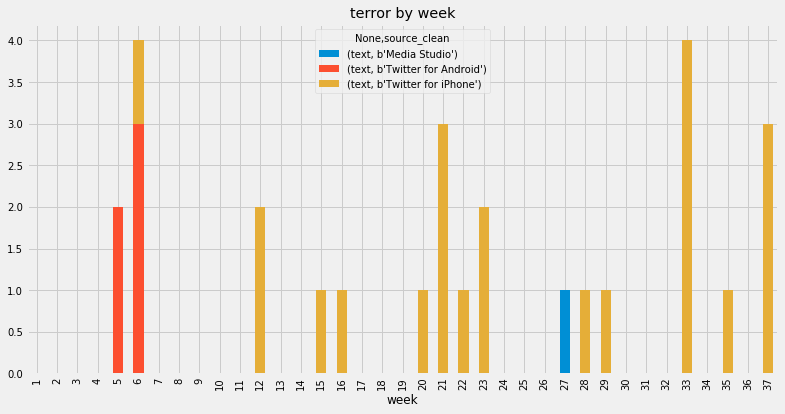

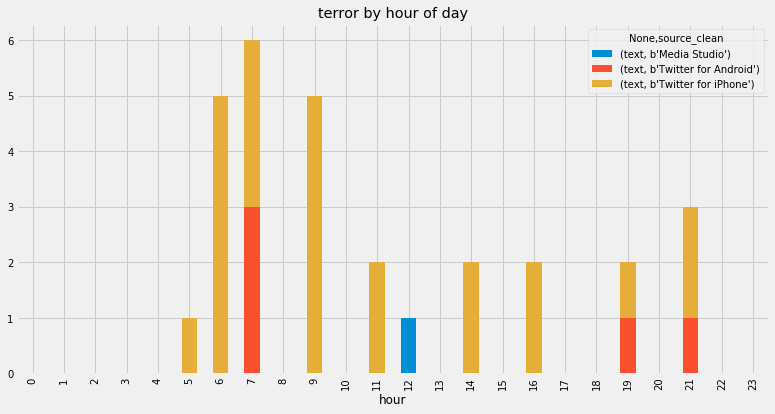

### The Tweets

[Sunday, Sep 17, 2017 9:03 AM](https://twitter.com/realDonaldTrump/status/909402439643750400): RT @realDonaldTrump: Loser terrorists must be dealt with in a much tougher manner.The internet is their main recruitment tool which we must…

[Friday, Sep 15, 2017 4:54 PM](https://twitter.com/realDonaldTrump/status/908796281002307584): Our hearts &amp; prayers go out to the people of London, who suffered a vicious terrorist attack.... https://t.co/Q2hTBV2l5t

[Friday, Sep 15, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/908643633901039617): Loser terrorists must be dealt with in a much tougher manner.The internet is their main recruitment tool which we must cut off &amp; use better!

[Friday, Sep 15, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/908642277987356673): Another attack in London by a loser terrorist.These are sick and demented people who were in the sights of Scotland Yard. Must be proactive!

[Monday, Aug 28, 2017 9:08 AM](https://twitter.com/realDonaldTrump/status/902156034348904450): RT @KatiePavlich: Your boss pardoned a traitor who gave U.S. enemies state secrets, he also pardoned a terrorist who killed Americans. Spar…

[Friday, Aug 18, 2017 9:30 PM](https://twitter.com/realDonaldTrump/status/898718902200418306): Today, I signed the Global War on Terrorism War Memorial Act (#HR873.) The bill authorizes....cont➡️https://t.co/c3zIkdtowc https://t.co/re6n0MS0cj

[Friday, Aug 18, 2017 9:06 AM](https://twitter.com/realDonaldTrump/status/898531481185689600): Radical Islamic Terrorism must be stopped by whatever means necessary! The courts must give us back our protective rights. Have to be tough!

[Thursday, Aug 17, 2017 2:45 PM](https://twitter.com/realDonaldTrump/status/898254409511129088): Study what General Pershing of the United States did to terrorists when caught. There was no more Radical Islamic Terror for 35 years!

[Thursday, Aug 17, 2017 2:00 PM](https://twitter.com/realDonaldTrump/status/898243270169563136): The United States condemns the terror attack in Barcelona, Spain, and will do whatever is necessary to help. Be tough &amp; strong, we love you!

[Saturday, Jul 22, 2017 6:45 AM](https://twitter.com/realDonaldTrump/status/888711488717934592): The Failing New York Times foiled U.S. attempt to kill the single most wanted terrorist,Al-Baghdadi.Their sick agenda over National Security

[Friday, Jul 14, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/885856351557210112): The United States mourns for the victims of Nice, France. We pledge our solidarity with France against terror. 🇺🇸🇫🇷 https://t.co/7irbz08oT3

[Thursday, Jul 6, 2017 12:02 PM](https://twitter.com/realDonaldTrump/status/882993144194838528): America is proud to stand shoulder-to-shoulder with Poland in the fight to eradicate the evils of terrorism and extremism. #POTUSinPoland https://t.co/MHxRmVvtsh

[Tuesday, Jun 6, 2017 9:44 AM](https://twitter.com/realDonaldTrump/status/872086906804240384): ...extremism, and all reference was pointing to Qatar. Perhaps this will be the beginning of the end to the horror of terrorism!

[Sunday, Jun 4, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/871328428963901440): At least 7 dead and 48 wounded in terror attack and Mayor of London says there is "no reason to be alarmed!"

[Saturday, Jun 3, 2017 7:01 PM](https://twitter.com/realDonaldTrump/status/871139911298101248): RT @DRUDGE_REPORT: Fears of new terror attack after van 'mows down 20 people' on London Bridge...

[Saturday, May 27, 2017 5:58 AM](https://twitter.com/realDonaldTrump/status/868406076995235840): Big G7 meetings today. Lots of very important matters under discussion. First on the list, of course, is terrorism. #G7Taormina

[Friday, May 26, 2017 4:26 PM](https://twitter.com/realDonaldTrump/status/868201805934678017): Terrorists are engaged in a war against civilization- it is up to all who value life to confront &amp; defeat this evil➡️https://t.co/haeuvCIF6I

[Friday, May 26, 2017 6:14 AM](https://twitter.com/realDonaldTrump/status/868047612301148160): Getting ready to engage G7 leaders on many issues including economic growth, terrorism, and security.

[Tuesday, May 16, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/864438529472049152): ...to terrorism and airline flight safety. Humanitarian reasons, plus I want Russia to greatly step up their fight against ISIS &amp; terrorism.

[Friday, Apr 21, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/855368516920332289): Another terrorist attack in Paris. The people of France will not take much more of this. Will have a big effect on presidential election!

[Sunday, Apr 9, 2017 11:20 AM](https://twitter.com/realDonaldTrump/status/851092500056072198): So sad to hear of the terrorist attack in Egypt. U.S. strongly condemns. I have great...

[Thursday, Mar 23, 2017 11:16 AM](https://twitter.com/realDonaldTrump/status/844930836663357440): A great American, Kurt Cochran, was killed in the London terror attack. My prayers and condolences are with his family and friends.

[Wednesday, Mar 22, 2017 9:33 PM](https://twitter.com/realDonaldTrump/status/844723847094026242): Spoke to U.K. Prime Minister Theresa May today to offer condolences on the terrorist attack in London. She is strong and doing very well.

[Tuesday, Feb 7, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/828939235499638784): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1 in terror, no problem!

[Tuesday, Feb 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/828937357147635713): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1in terror, no problem!

[Monday, Feb 6, 2017 9:49 PM](https://twitter.com/realDonaldTrump/status/828797801630937089): The threat from radical Islamic terrorism is very real, just look at what is happening in Europe and the Middle-East. Courts must act fast!

[Saturday, Feb 4, 2017 7:48 PM](https://twitter.com/realDonaldTrump/status/828042506851934209): The judge opens up our country to potential terrorists and others that do not have our best interests at heart. Bad people are very happy!

[Friday, Feb 3, 2017 7:51 AM](https://twitter.com/realDonaldTrump/status/827499871011819520): A new radical Islamic terrorist has just attacked in Louvre Museum in Paris. Tourists were locked down. France on edge again. GET SMART U.S.

[Monday, Jan 30, 2017 7:27 AM](https://twitter.com/realDonaldTrump/status/826044059647107073): There is nothing nice about searching for terrorists before they can enter our country. This was a big part of my campaign. Study the world!

---

## Search: _ivanka_

Number of Tweets: 19

Percent of all Tweets: 1.13%

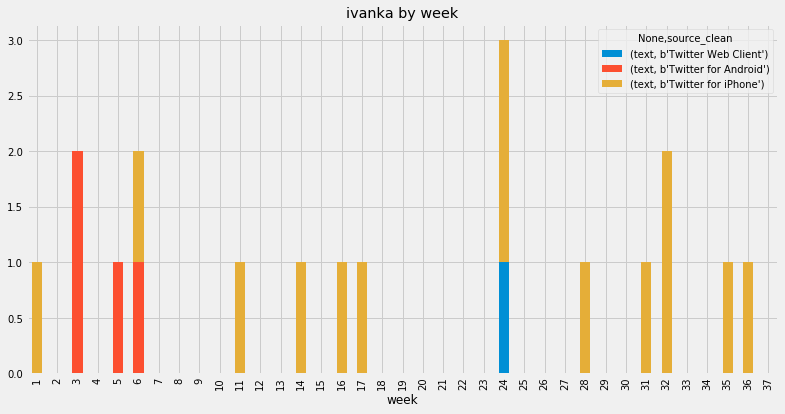

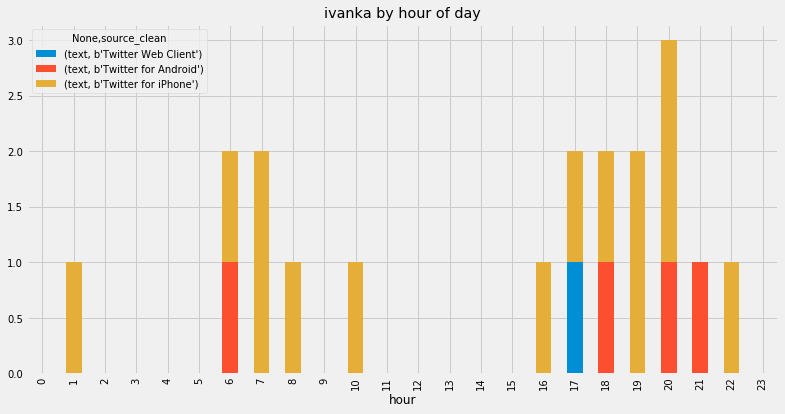

### The Tweets

[Thursday, Sep 7, 2017 8:53 AM](https://twitter.com/realDonaldTrump/status/905775939862310912): RT @GOP: .@IvankaTrump: This administration is committed to keeping working families at the forefront of our agenda.
https://t.co/rHqFqUJGWI

[Wednesday, Aug 30, 2017 8:50 PM](https://twitter.com/realDonaldTrump/status/903057301032108032): RT @IvankaTrump: We must reform our tax code so that all Americans can succeed in our modern economy &amp; achieve the American Dream! #TaxRefo…

[Thursday, Aug 10, 2017 4:18 PM](https://twitter.com/realDonaldTrump/status/895741164103639042): .@IvankaTrump will lead the U.S. delegation to India this fall, supporting women’s entrepreneurship globally.
#GES2017 @narendramodi

[Sunday, Aug 6, 2017 6:43 PM](https://twitter.com/realDonaldTrump/status/894328101949374465): RT @IvankaTrump: The Administration is committed to supporting military spouses in the workforce. Thanks Kim for sharing your story! https:…

[Friday, Aug 4, 2017 7:30 PM](https://twitter.com/realDonaldTrump/status/893615145053716480): RT @IvankaTrump: Since @realDonaldTrump inauguration, over 1 million net new jobs have been created in the American economy! #MAGA

[Monday, Jul 10, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/884374529660903424): When I left Conference Room for short meetings with Japan and other countries, I asked Ivanka to hold seat. Very standard. Angela M agrees!

[Thursday, Jun 15, 2017 5:43 PM](https://twitter.com/realDonaldTrump/status/875468769212149760): Thank you Wisconsin! Tuesday was a great success for #WorkforceWeek at @WCTC w/ @IvankaTrump &amp; @GovWalker. 
Remarks… https://t.co/L8o396yYKX

[Monday, Jun 12, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/874218586155479040): Ivanka on @foxandfriends now!

[Sunday, Jun 11, 2017 10:02 PM](https://twitter.com/realDonaldTrump/status/874084433460154368): My daughter, Ivanka, will be on @foxandfriends tomorrow morning. Enjoy!

[Tuesday, Apr 25, 2017 7:23 AM](https://twitter.com/realDonaldTrump/status/856830933709750272): Proud of @IvankaTrump for her leadership on these important issues. Looking forward to hearing her speak at the W20! https://t.co/e6Uajrm8zp

[Friday, Apr 21, 2017 8:19 PM](https://twitter.com/realDonaldTrump/status/855576880048738304): RT @Scavino45: .@POTUS @realDonaldTrump, @IvankaTrump, Jared Kushner, &amp; Dina Powell in the Oval Office today w/ Aya &amp; her brother Basel.
#W…

[Friday, Apr 7, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/850489084221018113): RT @IvankaTrump: Very proud of Arabella and Joseph for their performance in honor of President Xi Jinping and Madame Peng Liyuan's official…

[Thursday, Mar 16, 2017 5:43 PM](https://twitter.com/realDonaldTrump/status/842491443675611138): RT @USHCC: USHCC was delighted to host @IvankaTrump for a roundtable discussion w/ Hispanic women biz owners today in Washington #USHCCLegi…

[Saturday, Feb 11, 2017 6:00 PM](https://twitter.com/realDonaldTrump/status/830552079240409089): I am so proud of my daughter Ivanka. To be abused and treated so badly by the media, and to still hold her head so high, is truly wonderful!

[Wednesday, Feb 8, 2017 10:51 AM](https://twitter.com/realDonaldTrump/status/829356871848951809): My daughter Ivanka has been treated so unfairly by @Nordstrom. She is a great person -- always pushing me to do the right thing! Terrible!

[Thursday, Feb 2, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/827115768202534913): Attending Chief Ryan Owens' Dignified Transfer yesterday with my daughter Ivanka was my great honor. To a great and brave man - thank you!

[Monday, Jan 16, 2017 9:08 PM](https://twitter.com/realDonaldTrump/status/821177307708661761): "@drgoodspine: @realDonaldTrump @Ivanka Trump is great, a woman with real character and class."

[Monday, Jan 16, 2017 8:49 PM](https://twitter.com/realDonaldTrump/status/821172595869577220): At 9:00 P.M. @CNN, of all places, is doing a Special Report on my daughter, Ivanka. Considering it is CNN, can't imagine it will be great!

[Sunday, Jan 1, 2017 1:49 AM](https://twitter.com/realDonaldTrump/status/815449933453127681): RT @IvankaTrump: 2016 has been one of the most eventful and exciting years of my life. I wish you peace, joy, love and laughter. Happy New…

---

## Search: _ms 13_

Number of Tweets: 3

Percent of all Tweets: 0.18%

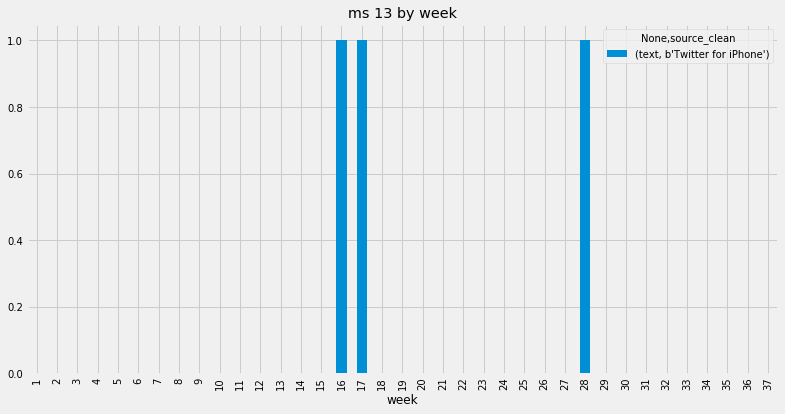

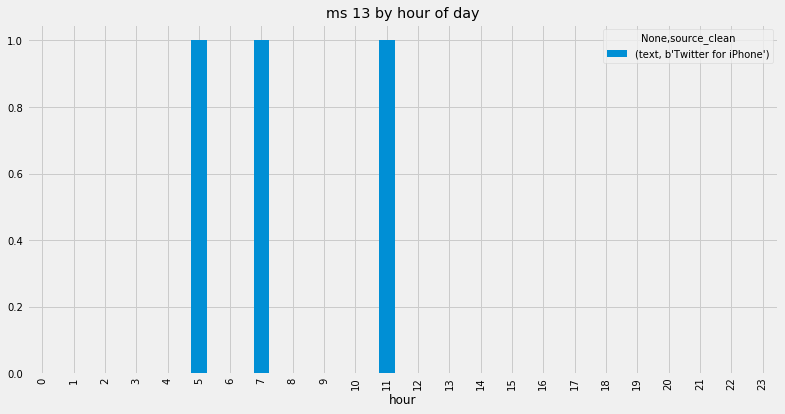

### The Tweets

[Wednesday, Jul 12, 2017 7:05 AM](https://twitter.com/realDonaldTrump/status/885092844511387654): ISIS is on the run &amp; will soon be wiped out of Syria &amp; Iraq, illegal border crossings are way down (75%) &amp; MS 13 gangs are being removed.

[Sunday, Apr 23, 2017 11:42 AM](https://twitter.com/realDonaldTrump/status/856171332521820165): The Democrats don't want money from budget going to border wall despite the fact that it will stop drugs and very bad MS 13 gang members.

[Tuesday, Apr 18, 2017 5:39 AM](https://twitter.com/realDonaldTrump/status/854268119774367745): The weak illegal immigration policies of the Obama Admin. allowed bad MS 13 gangs to form in cities across U.S. We are removing them fast!

---

## Search: _russia_

Number of Tweets: 87

Percent of all Tweets: 5.19%

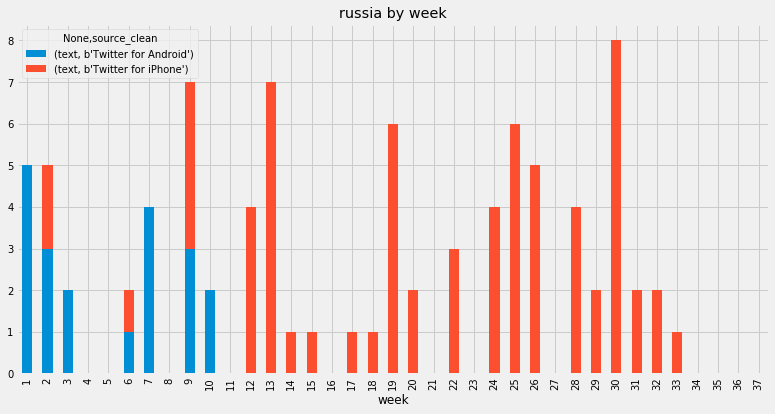

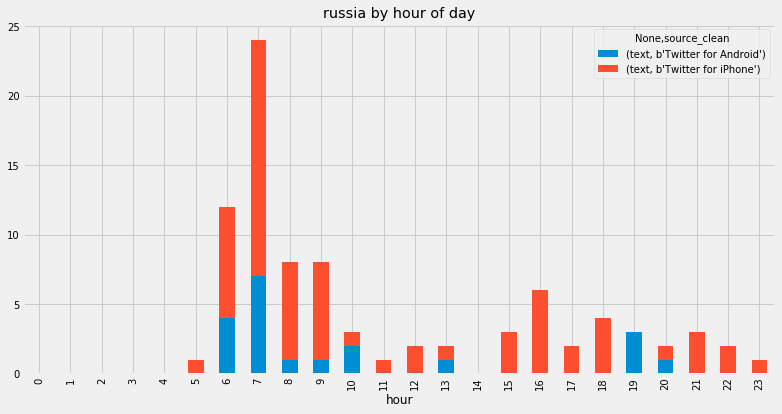

### The Tweets

[Tuesday, Aug 15, 2017 6:54 AM](https://twitter.com/realDonaldTrump/status/897411177583702016): @foxandfriends According to report just out, President Obama knew about Russian interference 3 years ago but he didn't want to anger Russia!

[Monday, Aug 7, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/894525428236464128): Interesting to watch Senator Richard Blumenthal of Connecticut talking about hoax Russian collusion when he was a  phony Vietnam con artist!

[Monday, Aug 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/894514535062790144): ...and West Virginia. The fact is the Fake News Russian collusion story, record Stock Market, border security, military strength, jobs.....

[Saturday, Aug 5, 2017 6:44 PM](https://twitter.com/realDonaldTrump/status/893965986566733824): The United Nations Security Council just voted 15-0 to sanction North Korea. China and Russia voted with us. Very big financial impact!

[Thursday, Aug 3, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/893083735633129472): Our relationship with Russia is at an all-time &amp; very dangerous  low. You can thank Congress, the same people that can't even give us HCare!

[Saturday, Jul 29, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/891253798500487168): In other words, Russia was against Trump in the 2016 Election - and why not, I want strong military &amp; low oil prices. Witch Hunt! https://t.co/mMSxj4Su5z

[Thursday, Jul 27, 2017 9:35 AM](https://twitter.com/realDonaldTrump/status/890566339462672385): "One of the things that has been lost in the politics of this situation is that the Russians collected and spread negative information.....

[Tuesday, Jul 25, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/889800510106107904): Jared Kushner did very well yesterday in proving he did not collude with the Russians. Witch Hunt. Next up, 11 year old Barron Trump!

[Monday, Jul 24, 2017 9:12 AM](https://twitter.com/realDonaldTrump/status/889473486506385409): Sleazy Adam Schiff, the totally biased Congressman looking into "Russia," spends all of his time on television pushing the Dem loss excuse!

[Monday, Jul 24, 2017 8:49 AM](https://twitter.com/realDonaldTrump/status/889467610332528641): So why aren't the Committees and investigators, and of course our beleaguered A.G., looking into Crooked Hillarys crimes &amp; Russia relations?

[Monday, Jul 24, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/889438168721874944): After 1 year of investigation with Zero evidence being found, Chuck Schumer just stated that "Democrats should blame ourselves,not Russia."

[Sunday, Jul 23, 2017 4:11 PM](https://twitter.com/realDonaldTrump/status/889216341013655552): RT @realDonaldTrump: As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Dem…

[Sunday, Jul 23, 2017 4:09 PM](https://twitter.com/realDonaldTrump/status/889215815022727168): As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Democrats and Russians!

[Saturday, Jul 22, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/888727293346156546): ...What about all of the Clinton ties to Russia, including Podesta Company, Uranium deal, Russian Reset, big dollar speeches etc.

[Sunday, Jul 16, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/886541955311816705): Thank you to former campaign adviser Michael Caputo for saying so powerfully that there was no Russian collusion in our winning campaign.

[Saturday, Jul 15, 2017 12:30 PM](https://twitter.com/realDonaldTrump/status/886261674029854721): Stock Market hit another all-time high yesterday - despite the Russian hoax story! Also, jobs numbers are starting to look very good!

[Wednesday, Jul 12, 2017 5:55 AM](https://twitter.com/realDonaldTrump/status/885075206905188352): RT @FoxNews: .@jessebwatters on @DonaldJTrumpJr meeting with Russian attorney: "I believe Don Jr. is the victim here." #TheFive https://t.c…

[Sunday, Jul 9, 2017 7:37 AM](https://twitter.com/realDonaldTrump/status/884013689736769536): ...We negotiated a ceasefire in parts of Syria which will save lives. Now it is time to move forward in working constructively with Russia!

[Sunday, Jul 9, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/884012097805406208): I strongly pressed President Putin twice about Russian meddling in our election. He vehemently denied it. I've already given my opinion.....

[Tuesday, Jun 27, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/879678356450676736): Fake News CNN is looking at big management changes now that they got caught falsely pushing their phony Russian stories. Ratings way down!

[Tuesday, Jun 27, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/879655772111679488): RT @foxandfriends: Hannity: Russia allegations 'boomeranging back' on Democrats https://t.co/lvdrpxpcp9

[Tuesday, Jun 27, 2017 6:33 AM](https://twitter.com/realDonaldTrump/status/879648931172556802): Wow, CNN had to retract big story on "Russia," with 3 employees forced to resign. What about all the other phony stories they do? FAKE NEWS!

[Monday, Jun 26, 2017 8:59 AM](https://twitter.com/realDonaldTrump/status/879323238425395200): The real story is that President Obama did NOTHING after being informed in August about Russian meddling. With 4 months looking at Russia...

[Monday, Jun 26, 2017 8:37 AM](https://twitter.com/realDonaldTrump/status/879317636164841474): The reason that President Obama did NOTHING about Russia after being notified by the CIA of meddling is that he expected Clinton would win..

[Saturday, Jun 24, 2017 4:44 PM](https://twitter.com/realDonaldTrump/status/878715504063643648): Obama Administration official said they "choked" when it came to acting on Russian meddling of election. They didn't want to hurt Hillary?

[Saturday, Jun 24, 2017 4:28 PM](https://twitter.com/realDonaldTrump/status/878711517537083392): Since the Obama Administration was told way before the 2016 Election that the Russians were meddling, why no action? Focus on them, not T!

[Friday, Jun 23, 2017 8:43 PM](https://twitter.com/realDonaldTrump/status/878413313188802560): Just out: The Obama Administration knew far in advance of November 8th about election meddling by Russia. Did nothing about it. WHY?

[Thursday, Jun 22, 2017 9:22 AM](https://twitter.com/realDonaldTrump/status/877879361130688512): By the way, if Russia was working so hard on the 2016 Election, it all took place during the Obama Admin. Why didn't they stop them?

[Thursday, Jun 22, 2017 9:18 AM](https://twitter.com/realDonaldTrump/status/877878375045447680): Former Homeland Security Advisor Jeh Johnson is latest top intelligence official to state there was no grand scheme between Trump &amp; Russia.

[Sunday, Jun 18, 2017 5:07 PM](https://twitter.com/realDonaldTrump/status/876546864669237253): RT @DiamondandSilk: The Media Says:  The President Should Stop Tweeting about Russia. 
 Well, Why Don't the Media Take Their Own Advice &amp; S…

[Friday, Jun 16, 2017 7:53 AM](https://twitter.com/realDonaldTrump/status/875682853585129472): After 7 months of investigations &amp; committee hearings about my "collusion with the Russians,"  nobody has been able to show any proof. Sad!

[Thursday, Jun 15, 2017 3:43 PM](https://twitter.com/realDonaldTrump/status/875438639823675392): Why is that Hillary Clintons family and Dems dealings with Russia are not looked at, but my non-dealings are?

[Thursday, Jun 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/875305788708974592): They made up a phony collusion with the Russians story, found zero proof, so now they go for obstruction of justice on the phony story. Nice

[Sunday, Jun 11, 2017 10:07 PM](https://twitter.com/realDonaldTrump/status/874085723762286592): RT @foxandfriends: "Yesterday's hearings provided zero evidence of collusion between our campaign and the Russians because there wasn't any…

[Wednesday, May 31, 2017 6:37 AM](https://twitter.com/realDonaldTrump/status/869865463584620544): So now it is reported that the Democrats, who have excoriated Carter Page about Russia, don't want him to testify. He blows away their....

[Tuesday, May 30, 2017 10:01 AM](https://twitter.com/realDonaldTrump/status/869554306806157312): RT @foxandfriends: Jared Kushner didn't suggest Russian communications channel in meeting, source says https://t.co/nF6bM1FEt1

[Tuesday, May 30, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/869509894688387072): Russian officials must be laughing at the U.S. &amp; how a lame excuse for why the Dems lost the election has taken over the Fake News.

[Tuesday, May 16, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/864438529472049152): ...to terrorism and airline flight safety. Humanitarian reasons, plus I want Russia to greatly step up their fight against ISIS &amp; terrorism.

[Tuesday, May 16, 2017 7:03 AM](https://twitter.com/realDonaldTrump/status/864436162567471104): As President I wanted to share with Russia (at an openly scheduled W.H. meeting) which I have the absolute right to do, facts pertaining....

[Friday, May 12, 2017 7:51 AM](https://twitter.com/realDonaldTrump/status/862998775731818496): Again, the story that there was collusion between the Russians &amp; Trump campaign was fabricated by Dems as an excuse for losing the election.

[Thursday, May 11, 2017 5:54 PM](https://twitter.com/realDonaldTrump/status/862788002594127873): Yesterday, on the same day- I had meetings with Russian Foreign Minister Sergei Lavrov and the FM of Ukraine, Pavlo… https://t.co/hm4U54DCQO

[Thursday, May 11, 2017 4:34 PM](https://twitter.com/realDonaldTrump/status/862767872879325185): Russia must be laughing up their sleeves watching as the U.S. tears itself apart over a Democrat EXCUSE for losing the election.

[Monday, May 8, 2017 6:46 PM](https://twitter.com/realDonaldTrump/status/861713823505494016): The Russia-Trump collusion story is a total hoax, when will this taxpayer funded charade end?

[Monday, May 8, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/861712617299210240): Director Clapper reiterated what everybody, including the fake media already knows- there is "no evidence" of collusion w/ Russia and Trump.

[Sunday, May 7, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/861177649179373569): When will the Fake Media ask about the Dems dealings with Russia &amp; why the DNC wouldn't allow the FBI to check their server or investigate?

[Tuesday, May 2, 2017 11:06 PM](https://twitter.com/realDonaldTrump/status/859604996236742656): ...Trump/Russia story was an excuse used by the Democrats as justification for losing the election. Perhaps Trump just ran a great campaign?

[Friday, Apr 28, 2017 10:34 PM](https://twitter.com/realDonaldTrump/status/858147464846729217): RT @foxnation: . @TuckerCarlson : #Dems Don't Really Believe #Trump Is a Pawn of #Russia - That's Just Their Political Tool  https://t.co/K…

[Thursday, Apr 13, 2017 9:16 AM](https://twitter.com/realDonaldTrump/status/852510810287075329): Things will work out fine between the U.S.A. and Russia. At the right time everyone will come to their senses &amp; there will be lasting peace!

[Monday, Apr 3, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/848856822312292354): Was the brother of John Podesta paid big money to get the sanctions on Russia lifted? Did Hillary know?

[Saturday, Apr 1, 2017 1:02 PM](https://twitter.com/realDonaldTrump/status/848219027659010051): ..not associated with Russia. Trump team spied on before he was nominated." If this is true, does not get much bigger. Would be sad for U.S.

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

[Saturday, Apr 1, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/848153860602507264): When will Sleepy Eyes Chuck Todd and @NBCNews start talking about the Obama SURVEILLANCE SCANDAL and stop with the Fake Trump/Russia story?

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Tuesday, Mar 28, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/846682464215076866): Watch @foxandfriends now on Podesta and Russia!

[Monday, Mar 27, 2017 9:35 PM](https://twitter.com/realDonaldTrump/status/846536212362018816): ...money to Bill, the Hillary Russian "reset," praise of Russia by Hillary, or Podesta Russian Company. Trump Russia story is a hoax. #MAGA!

[Monday, Mar 27, 2017 9:26 PM](https://twitter.com/realDonaldTrump/status/846533818811080704): Why isn't the House Intelligence Committee looking into the Bill &amp; Hillary deal that allowed big Uranium to go to Russia, Russian speech....

[Thursday, Mar 23, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/844886082663698436): Just watched the totally biased and fake news reports of the so-called Russia story on NBC and ABC. Such dishonesty!

[Monday, Mar 20, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/843813078076719107): What about all of the contact with the Clinton campaign and the Russians? Also, is it true that the DNC would not let the FBI in to look?

[Monday, Mar 20, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/843776582825267201): The Democrats made up and pushed the Russian story as an excuse for running a terrible campaign. Big advantage in Electoral College &amp; lost!

[Monday, Mar 20, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/843772976151642112): James Clapper and others stated that there is no evidence Potus colluded with Russia. This story is FAKE NEWS and everyone knows it!

[Tuesday, Mar 7, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/839101660886614016): For eight years Russia "ran over" President Obama, got stronger and stronger, picked-off Crimea and added missiles. Weak! @foxandfriends

[Sunday, Mar 5, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/838353481526312961): Who was it that secretly said to Russian President, "Tell Vladimir that after the election I'll have more flexibility?" @foxandfriends

[Saturday, Mar 4, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/837991759045079040): Just out: The same Russian Ambassador that met Jeff Sessions visited the Obama White House 22 times, and 4 times last year alone.

[Saturday, Mar 4, 2017 6:26 AM](https://twitter.com/realDonaldTrump/status/837987684660412416): The first meeting Jeff Sessions had with the Russian Amb was set up by the Obama Administration under education program for 100 Ambs......

[Friday, Mar 3, 2017 4:02 PM](https://twitter.com/realDonaldTrump/status/837770149767827456): I hereby demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https://t.co/qCDljfF3wN

[Friday, Mar 3, 2017 3:49 PM](https://twitter.com/realDonaldTrump/status/837767004236955649): I hearby demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https://t.co/qCDljfF3wN

[Friday, Mar 3, 2017 3:47 PM](https://twitter.com/realDonaldTrump/status/837766402937393155): I hear by demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https://t.co/qCDljfF3wN

[Friday, Mar 3, 2017 12:54 PM](https://twitter.com/realDonaldTrump/status/837722869106880517): We should start an immediate investigation into @SenSchumer and his ties to Russia and Putin. A total hypocrite! https://t.co/Ik3yqjHzsA

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Wednesday, Feb 15, 2017 7:42 AM](https://twitter.com/realDonaldTrump/status/831846101179314177): Crimea was TAKEN by Russia during the Obama Administration. Was Obama too soft on Russia?

[Wednesday, Feb 15, 2017 7:19 AM](https://twitter.com/realDonaldTrump/status/831840306161123328): Information is being illegally given to the failing @nytimes &amp; @washingtonpost by the intelligence community (NSA and FBI?).Just like Russia

[Wednesday, Feb 15, 2017 7:08 AM](https://twitter.com/realDonaldTrump/status/831837514226921472): This Russian connection non-sense is merely an attempt to cover-up the many mistakes made in Hillary Clinton's losing campaign.

[Tuesday, Feb 7, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/828939235499638784): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1 in terror, no problem!

[Tuesday, Feb 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/828937357147635713): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1in terror, no problem!

[Sunday, Jan 15, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/820789938887294977): much worse - just look at Syria (red line), Crimea, Ukraine and the build-up of Russian nukes. Not good! Was this the leaker of Fake News?

[Sunday, Jan 15, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/820786730257285120): .@FoxNews "Outgoing CIA Chief, John Brennan, blasts Pres-Elect Trump on Russia threat. Does not fully understand." Oh really, couldn't do...

[Friday, Jan 13, 2017 6:11 AM](https://twitter.com/realDonaldTrump/status/819864373988573184): Totally made up facts by sleazebag political operatives, both Democrats and Republicans - FAKE NEWS! Russia says nothing exists. Probably...

[Wednesday, Jan 11, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/819159806489591809): Russia has never tried to use leverage over me. I HAVE NOTHING TO DO WITH RUSSIA - NO DEALS, NO LOANS, NO NOTHING!

[Wednesday, Jan 11, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/819155311793700865): Russia just said the unverified report paid for by political opponents is "A COMPLETE AND TOTAL FABRICATION, UTTER NONSENSE." Very unfair!

[Tuesday, Jan 10, 2017 9:00 PM](https://twitter.com/realDonaldTrump/status/819000924207251456): 'BuzzFeed Runs Unverifiable Trump-Russia Claims' #FakeNews 
https://t.co/d6daCFZHNh

[Sunday, Jan 8, 2017 11:57 AM](https://twitter.com/realDonaldTrump/status/818139647687753733): RT @MeetThePress: Watch our interview with @KellyannePolls: Russia "did not succeed" in attempts to sway election https://t.co/EZhgUIUbYx #…

[Saturday, Jan 7, 2017 10:10 AM](https://twitter.com/realDonaldTrump/status/817750330196819968): have enough problems around the world without yet another one. When I am President, Russia will respect us far more than they do now and....

[Saturday, Jan 7, 2017 10:02 AM](https://twitter.com/realDonaldTrump/status/817748207694467072): Having a good relationship with Russia is a good thing, not a bad thing. Only "stupid" people, or fools, would think that it is bad! We.....

[Thursday, Jan 5, 2017 7:30 PM](https://twitter.com/realDonaldTrump/status/817166353266262016): The Democratic National Committee would not allow the FBI to study or see its computer info after it was supposedly hacked by Russia......

[Wednesday, Jan 4, 2017 7:22 AM](https://twitter.com/realDonaldTrump/status/816620855958601730): Julian Assange said "a 14 year old could have hacked Podesta" - why was DNC so careless? Also said Russians did not give him the info!

[Tuesday, Jan 3, 2017 8:14 PM](https://twitter.com/realDonaldTrump/status/816452807024840704): The "Intelligence" briefing on so-called "Russian hacking" was delayed until Friday, perhaps more time needed to build a case. Very strange!

---

## Search: _failing_

Number of Tweets: 29

Percent of all Tweets: 1.73%

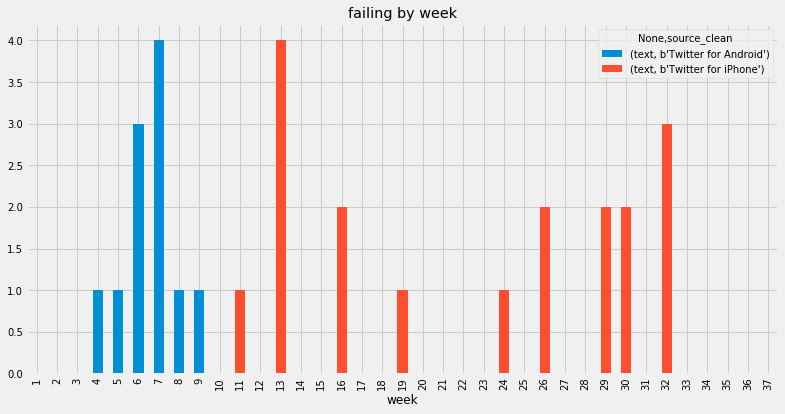

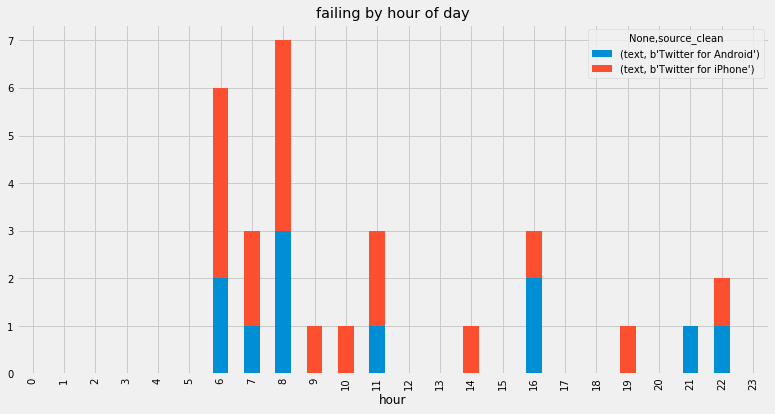

### The Tweets

[Tuesday, Aug 8, 2017 2:00 PM](https://twitter.com/realDonaldTrump/status/894981661926068228): E-mails show that the AmazonWashingtonPost and the FailingNewYorkTimes were reluctant to cover the Clinton/Lynch secret meeting in plane.

[Monday, Aug 7, 2017 4:39 PM](https://twitter.com/realDonaldTrump/status/894659355324424192): How much longer will the failing nytimes, with its big losses and massive unfunded liability (and non-existent sources), remain in business?

[Monday, Aug 7, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/894508048844279809): The failing @nytimes, which has made every wrong prediction about me including my big election win (apologized), is totally inept!

[Thursday, Jul 27, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/890524387773997056): Wow, the Failing @nytimes said about @foxandfriends "....the most powerful T.V. show in America."

[Sunday, Jul 23, 2017 7:57 PM](https://twitter.com/realDonaldTrump/status/889273320574783489): It's hard to read the Failing New York Times or the Amazon Washington Post because every story/opinion, even if should be positive, is bad!

[Saturday, Jul 22, 2017 6:45 AM](https://twitter.com/realDonaldTrump/status/888711488717934592): The Failing New York Times foiled U.S. attempt to kill the single most wanted terrorist,Al-Baghdadi.Their sick agenda over National Security

[Monday, Jul 17, 2017 10:17 PM](https://twitter.com/realDonaldTrump/status/887134287350439936): Republicans should just REPEAL failing ObamaCare now &amp; work on a new Healthcare Plan that will start from a clean slate. Dems will join in!

[Wednesday, Jun 28, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/880015261004435456): The failing @nytimes writes false story after false story about me. They don't even call to verify the facts of a story. A Fake News Joke!

[Tuesday, Jun 27, 2017 8:47 AM](https://twitter.com/realDonaldTrump/status/879682547235651584): So they caught Fake News CNN cold, but what about NBC, CBS &amp; ABC? What about the failing @nytimes &amp; @washingtonpost? They are all Fake News!

[Sunday, Jun 11, 2017 8:49 AM](https://twitter.com/realDonaldTrump/status/873884774041079808): The Democrats have no message,  not on economics, not on taxes,  not on jobs, not on failing #Obamacare. They are only OBSTRUCTIONISTS!

[Sunday, May 7, 2017 7:37 AM](https://twitter.com/realDonaldTrump/status/861183225082806272): RT @brunelldonald: I thought about jobs that went overseas failing schools open borders not my skin color when I voted @realDonaldTrump! I…

[Thursday, Apr 20, 2017 9:48 AM](https://twitter.com/realDonaldTrump/status/855055509455593472): Failing @nytimes, which has been calling me wrong for two years, just got caught in a big lie concerning New England Patriots visit to W.H.

[Wednesday, Apr 19, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/854676780527079425): Dems failed in Kansas and are now failing in Georgia. Great job Karen Handel! It is now Hollywood vs. Georgia on June 20th.

[Saturday, Apr 1, 2017 11:59 AM](https://twitter.com/realDonaldTrump/status/848203201094483972): The failing @nytimes finally gets it - "In places where no insurance company offers plans, there will be no way for ObamaCare customers to..

[Thursday, Mar 30, 2017 10:27 AM](https://twitter.com/realDonaldTrump/status/847455180912181249): The failing @nytimes has disgraced the media world. Gotten me wrong for two solid years. Change libel laws? https://t.co/QIqLgvYLLi

[Wednesday, Mar 29, 2017 8:01 AM](https://twitter.com/realDonaldTrump/status/847056211006631936): Remember when the failing @nytimes apologized to its subscribers, right after the election, because their coverage was so wrong. Now worse!

[Tuesday, Mar 28, 2017 11:26 AM](https://twitter.com/realDonaldTrump/status/846745288735887360): The failing @NYTimes would do much better if they were honest! 
https://t.co/ATy8R3knS2

[Wednesday, Mar 15, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/841967881516679168): Can you imagine what the outcry would be if @SnoopDogg, failing career and all, had aimed and fired the gun at President Obama? Jail time!

[Sunday, Feb 26, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/835817351178301440): For first time the failing @nytimes will take an ad (a bad one) to help save its failing reputation. Try reporting accurately &amp; fairly!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Friday, Feb 17, 2017 4:48 PM](https://twitter.com/realDonaldTrump/status/832708293516632065): The FAKE NEWS media (failing @nytimes, @NBCNews, @ABC, @CBS, @CNN) is not my enemy, it is the enemy of the American People!

[Friday, Feb 17, 2017 4:32 PM](https://twitter.com/realDonaldTrump/status/832704292993847296): The FAKE NEWS media (failing @nytimes, @CNN, @NBCNews and many more)    is not my enemy, it is the enemy of the American people. SICK!

[Thursday, Feb 16, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/832197515248275456): Leaking, and even illegal classified leaking, has been a big problem in Washington for years. Failing @nytimes (and others) must apologize!

[Wednesday, Feb 15, 2017 7:19 AM](https://twitter.com/realDonaldTrump/status/831840306161123328): Information is being illegally given to the failing @nytimes &amp; @washingtonpost by the intelligence community (NSA and FBI?).Just like Russia

[Friday, Feb 10, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/830047626414477312): The failing @nytimes does major FAKE NEWS China story saying "Mr.Xi has not spoken to Mr. Trump since Nov.14." We spoke at length yesterday!

[Monday, Feb 6, 2017 9:33 PM](https://twitter.com/realDonaldTrump/status/828793887275761665): The failing @nytimes was forced to apologize to its subscribers for the poor reporting it did on my election win. Now they are worse!

[Monday, Feb 6, 2017 11:32 AM](https://twitter.com/realDonaldTrump/status/828642511698669569): The failing @nytimes writes total fiction concerning me. They have gotten it wrong for two years, and now are making up stories &amp; sources!

[Sunday, Jan 29, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/825690087857995776): Somebody with aptitude and conviction should buy the FAKE NEWS and failing @nytimes and either run it correctly or let it fold with dignity!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

---

## Search: _election_

Number of Tweets: 64

Percent of all Tweets: 3.82%

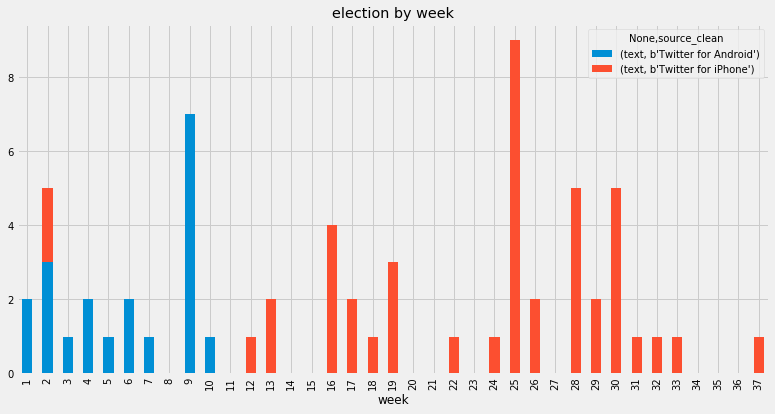

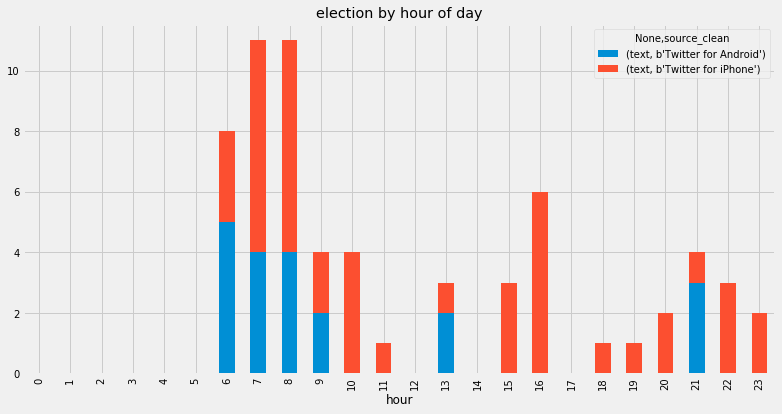

### The Tweets

[Wednesday, Sep 13, 2017 10:47 PM](https://twitter.com/realDonaldTrump/status/908160218995068928): Crooked Hillary Clinton blames everybody (and every thing) but herself for her election loss. She lost the debates and lost her direction!

[Thursday, Aug 17, 2017 6:24 AM](https://twitter.com/realDonaldTrump/status/898128290698989568): ...and people like Ms. Heyer. Such a disgusting lie. He just can't forget his election trouncing.The people of South Carolina will remember!

[Monday, Aug 7, 2017 6:38 AM](https://twitter.com/realDonaldTrump/status/894508048844279809): The failing @nytimes, which has made every wrong prediction about me including my big election win (apologized), is totally inept!

[Tuesday, Aug 1, 2017 8:49 AM](https://twitter.com/realDonaldTrump/status/892366646542782464): Stock Market could hit all-time high (again) 22,000 today. Was 18,000 only 6 months ago on Election Day. Mainstream media seldom mentions!

[Saturday, Jul 29, 2017 7:15 PM](https://twitter.com/realDonaldTrump/status/891437168798965761): I love reading about all of the "geniuses" who were so instrumental in my election success. Problem is, most don't exist. #Fake News! MAGA

[Saturday, Jul 29, 2017 1:04 PM](https://twitter.com/realDonaldTrump/status/891343645529567232): U.S. Stock Market up almost 20% since Election!

[Saturday, Jul 29, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/891253798500487168): In other words, Russia was against Trump in the 2016 Election - and why not, I want strong military &amp; low oil prices. Witch Hunt! https://t.co/mMSxj4Su5z

[Sunday, Jul 23, 2017 4:11 PM](https://twitter.com/realDonaldTrump/status/889216341013655552): RT @realDonaldTrump: As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Dem…

[Sunday, Jul 23, 2017 4:09 PM](https://twitter.com/realDonaldTrump/status/889215815022727168): As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Democrats and Russians!

[Tuesday, Jul 18, 2017 9:03 PM](https://twitter.com/realDonaldTrump/status/887478019346051075): RT @FoxNews: U.S. Markets since election. https://t.co/rlWSt30GUd

[Sunday, Jul 16, 2017 10:10 AM](https://twitter.com/realDonaldTrump/status/886588838902206464): The ABC/Washington Post Poll, even though almost 40% is not bad at this time, was just about the most inaccurate poll around election time!

[Saturday, Jul 15, 2017 4:29 PM](https://twitter.com/realDonaldTrump/status/886321948275429381): Just got to the #USWomensOpen in Bedminster, New Jersey. People are really happy with record high stock market - up over 17% since election!

[Wednesday, Jul 12, 2017 8:12 AM](https://twitter.com/realDonaldTrump/status/885109663217352704): .@WashTimes states "Democrats have willfully used Moscow disinformation to influence the presidential election against Donald Trump."

[Sunday, Jul 9, 2017 8:06 AM](https://twitter.com/realDonaldTrump/status/884020939264073728): ...have it. Fake News said 17 intel agencies when actually 4 (had to apologize). Why did Obama do NOTHING when he had info before election?

[Sunday, Jul 9, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/884016887692234753): Putin &amp; I discussed forming an impenetrable Cyber Security unit    so that election hacking, &amp; many other negative things, will be guarded..

[Sunday, Jul 9, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/884012097805406208): I strongly pressed President Putin twice about Russian meddling in our election. He vehemently denied it. I've already given my opinion.....

[Saturday, Jul 1, 2017 6:02 PM](https://twitter.com/realDonaldTrump/status/881271809433374721): ....the 2016 election with interviews, speeches and social media. I had to beat #FakeNews, and did. We will continue to WIN!

[Monday, Jun 26, 2017 10:24 PM](https://twitter.com/realDonaldTrump/status/879525817361068032): From @FoxNews "Bombshell: In 2016, Obama dismissed idea that anyone could rig an American election."  Check out his statement - Witch Hunt!

[Saturday, Jun 24, 2017 4:44 PM](https://twitter.com/realDonaldTrump/status/878715504063643648): Obama Administration official said they "choked" when it came to acting on Russian meddling of election. They didn't want to hurt Hillary?

[Saturday, Jun 24, 2017 4:28 PM](https://twitter.com/realDonaldTrump/status/878711517537083392): Since the Obama Administration was told way before the 2016 Election that the Russians were meddling, why no action? Focus on them, not T!

[Friday, Jun 23, 2017 8:43 PM](https://twitter.com/realDonaldTrump/status/878413313188802560): Just out: The Obama Administration knew far in advance of November 8th about election meddling by Russia. Did nothing about it. WHY?

[Thursday, Jun 22, 2017 10:08 AM](https://twitter.com/realDonaldTrump/status/877891129194102785): ...Why did the DNC REFUSE to turn over its Server to the FBI, and still hasn't? It's all a big Dem scam and excuse for losing the election!

[Thursday, Jun 22, 2017 10:01 AM](https://twitter.com/realDonaldTrump/status/877889199353077760): ...Why did Democratic National Committee turn down the DHS offer to protect against hacks (long prior to election). It's all a big Dem HOAX!

[Thursday, Jun 22, 2017 9:22 AM](https://twitter.com/realDonaldTrump/status/877879361130688512): By the way, if Russia was working so hard on the 2016 Election, it all took place during the Obama Admin. Why didn't they stop them?

[Tuesday, Jun 20, 2017 11:48 PM](https://twitter.com/realDonaldTrump/status/877372660455546880): Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0

[Tuesday, Jun 20, 2017 10:33 PM](https://twitter.com/realDonaldTrump/status/877353797760286720): Thank you @FoxNews "Huge win for President Trump and GOP in Georgia Congressional Special Election."

[Sunday, Jun 18, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/876394578777174021): The new Rasmussen Poll, one of the most accurate in the 2016 Election, just out with a Trump 50% Approval Rating.That's higher than O's #'s!

[Sunday, Jun 11, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/873878061778907137): The #FakeNews MSM doesn't report the great economic news since Election Day. #DOW up 16%. #NASDAQ up 19.5%. Drilling &amp; energy sector...

[Tuesday, May 30, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/869509894688387072): Russian officials must be laughing at the U.S. &amp; how a lame excuse for why the Dems lost the election has taken over the Fake News.

[Friday, May 12, 2017 7:51 AM](https://twitter.com/realDonaldTrump/status/862998775731818496): Again, the story that there was collusion between the Russians &amp; Trump campaign was fabricated by Dems as an excuse for losing the election.

[Thursday, May 11, 2017 4:34 PM](https://twitter.com/realDonaldTrump/status/862767872879325185): Russia must be laughing up their sleeves watching as the U.S. tears itself apart over a Democrat EXCUSE for losing the election.

[Thursday, May 11, 2017 3:35 PM](https://twitter.com/realDonaldTrump/status/862753016193089536): 'Presidential Executive Order on the Establishment of Presidential Advisory Commission on Election Integrity'
➡️… https://t.co/kVG8r7qZS5

[Tuesday, May 2, 2017 11:06 PM](https://twitter.com/realDonaldTrump/status/859604996236742656): ...Trump/Russia story was an excuse used by the Democrats as justification for losing the election. Perhaps Trump just ran a great campaign?

[Sunday, Apr 23, 2017 3:55 PM](https://twitter.com/realDonaldTrump/status/856234989591121922): ...popular vote. ABC News/Washington Post Poll (wrong big on election) said almost all stand by their vote on me &amp; 53% said strong leader.

[Sunday, Apr 23, 2017 10:05 AM](https://twitter.com/realDonaldTrump/status/856146924705120256): Very interesting election currently taking place in France.

[Friday, Apr 21, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/855368516920332289): Another terrorist attack in Paris. The people of France will not take much more of this. Will have a big effect on presidential election!

[Monday, Apr 17, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/853945633903923200): The Fake Media (not Real Media) has gotten even worse since the election. Every story is badly slanted. We have to hold them to the truth!

[Sunday, Apr 16, 2017 8:45 PM](https://twitter.com/realDonaldTrump/status/853771244579282944): The recent Kansas election (Congress) was a really big media event, until the Republicans won. Now they play the same game with Georgia-BAD!

[Sunday, Apr 16, 2017 9:13 AM](https://twitter.com/realDonaldTrump/status/853597199619543041): Someone should look into who paid for the small organized rallies yesterday. The election is over!

[Friday, Mar 31, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/847766558520856578): Mike Flynn should ask for immunity in that this is a witch hunt (excuse for big election loss), by media &amp; Dems, of historic proportion!

[Wednesday, Mar 29, 2017 8:01 AM](https://twitter.com/realDonaldTrump/status/847056211006631936): Remember when the failing @nytimes apologized to its subscribers, right after the election, because their coverage was so wrong. Now worse!

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Sunday, Mar 5, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/838353481526312961): Who was it that secretly said to Russian President, "Tell Vladimir that after the election I'll have more flexibility?" @foxandfriends

[Saturday, Mar 4, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/837996746236182529): How low has President Obama gone to tapp my phones during the very sacred election process. This is Nixon/Watergate. Bad (or sick) guy!

[Saturday, Mar 4, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/837994257566863360): I'd bet a good lawyer could make a great case out of the fact that President Obama was tapping my phones in October, just prior to Election!

[Saturday, Mar 4, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/837993273679560704): Is it legal for a sitting President to be "wire tapping" a race for president prior to an election? Turned down by court earlier. A NEW LOW!

[Thursday, Mar 2, 2017 9:35 PM](https://twitter.com/realDonaldTrump/status/837491607171629057): ...to win. The Democrats are overplaying their hand. They lost the election, and now they have lost their grip on reality. The real story...

[Thursday, Mar 2, 2017 9:27 PM](https://twitter.com/realDonaldTrump/status/837489578193846278): ...intentional. This whole narrative is a way of saving face for Democrats losing an election that everyone thought they were supposed.....

[Thursday, Mar 2, 2017 6:00 AM](https://twitter.com/realDonaldTrump/status/837256338203881472): Since November 8th, Election Day, the Stock Market has posted $3.2 trillion in GAINS and consumer confidence is at a 15 year high. Jobs!

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Monday, Feb 6, 2017 9:33 PM](https://twitter.com/realDonaldTrump/status/828793887275761665): The failing @nytimes was forced to apologize to its subscribers for the poor reporting it did on my election win. Now they are worse!

[Monday, Feb 6, 2017 7:01 AM](https://twitter.com/realDonaldTrump/status/828574430800539648): Any negative polls are fake news, just like the CNN, ABC, NBC polls in the election. Sorry, people want border security and extreme vetting.

[Saturday, Feb 4, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/827874208021639168): After being forced to apologize for its bad and inaccurate coverage of me after winning the election, the FAKE NEWS @nytimes is still lost!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

[Sunday, Jan 22, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/823150055418920960): Watched protests yesterday but was under the impression that we just had an election! Why didn't these people vote? Celebs hurt cause badly.

[Tuesday, Jan 17, 2017 8:11 AM](https://twitter.com/realDonaldTrump/status/821344302651555840): The same people who did the phony election polls, and were so wrong, are now doing approval rating polls. They are rigged just like before.

[Saturday, Jan 14, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/820255947956383744): mention crime infested) rather than falsely complaining about the election results. All talk, talk, talk - no action or results. Sad!

[Thursday, Jan 12, 2017 9:22 AM](https://twitter.com/realDonaldTrump/status/819550083742109696): .@CNN is in a total meltdown with their FAKE NEWS because their ratings are tanking since election and their credibility will soon be gone!

[Wednesday, Jan 11, 2017 7:44 AM](https://twitter.com/realDonaldTrump/status/819162968592183298): I win an election easily, a great "movement" is verified, and crooked opponents try to belittle our victory with FAKE NEWS. A sorry state!

[Tuesday, Jan 10, 2017 3:50 PM](https://twitter.com/realDonaldTrump/status/818922995980845056): 'Small business optimism soars after Trump election' https://t.co/WjBaTp824U

[Sunday, Jan 8, 2017 11:57 AM](https://twitter.com/realDonaldTrump/status/818139647687753733): RT @MeetThePress: Watch our interview with @KellyannePolls: Russia "did not succeed" in attempts to sway election https://t.co/EZhgUIUbYx #…

[Saturday, Jan 7, 2017 6:56 AM](https://twitter.com/realDonaldTrump/status/817701436096126977): Intelligence stated very strongly there was absolutely no evidence that hacking affected the election results. Voting machines not touched!

[Monday, Jan 2, 2017 1:37 PM](https://twitter.com/realDonaldTrump/status/815990335318982656): Various media outlets and pundits say that I thought I was going to lose the election. Wrong, it all came together in the last week and.....

---

In [34]:
searches = ['great', 'fake', 'mexic', 'fox', 'terror', 'ivanka', 'ms 13', 'russia', 'failing', 'election']
for search in searches:
    analyzeText(search)